# Equity trading strategies with macro and random forests

The random forest is a machine learning model composed of many different "decision tree" models. Decision trees are sequences of "if-else" statements, where "learning" in the regression case corresponds to learning good decision rules from data. The random forest constructs each of these trees to, hopefully, be both reasonable forecasters and be as uncorrelated with one another as possible. The average prediction made by the trees is the prediction made by the random forest.

## Get packages and JPMaQS data

### Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from macrosynergy.download import JPMaQSDownload
import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.pnl as msn
import macrosynergy.signal as mss
import macrosynergy.learning as msl
import macrosynergy.visuals as msv

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from timeit import default_timer as timer
from datetime import timedelta, date, datetime

import warnings

from IPython.display import HTML

warnings.filterwarnings("ignore")

### Previously prepared quantamental categories

In [2]:
# Import data from csv file created preparation notebook
# https://macrosynergy.com/academy/notebooks/sectoral-equity-indicators/

INPUT_PATH = os.path.join(os.getcwd(), r"../../../equity_sectoral_notebook_data.csv")

df_csv = pd.read_csv(INPUT_PATH, index_col=0)
df_csv["real_date"] = pd.to_datetime(df_csv["real_date"]).dt.date

df_csv = msm.utils.standardise_dataframe(df_csv)
df_csv = df_csv.sort_values(["cid", "xcat", "real_date"])

In [3]:
# Equity sector labels and cross sections

sector_labels = {
    "ALL": "All sectors",
    "COD": "Cons. discretionary",
    "COS": "Cons. staples",
    "CSR": "Communication services",
    "ENR": "Energy",
    "FIN": "Financials",
    "HLC": "Healthcare",
    "IND": "Industrials",
    "ITE": "Information tech",
    "MAT": "Materials",
    "REL": "Real estate",
    "UTL": "Utilities",
}
cids_secs = list(sector_labels.keys())

# Equity countries cross sections

cids_eq = [
    "AUD",
    "CAD",
    "CHF",
    "EUR",
    "GBP",
    "ILS",
    "JPY",
    "NOK",
    "NZD",
    "SEK",
    "SGD",
    "USD",
]

In [4]:
# Base category tickes of quantamental categories created by data preparation notebook:
# https://macrosynergy.com/academy/notebooks/sectoral-equity-indicators/

output_growth = [
    # industrial prod
    "XIP_SA_P1M1ML12_3MMA",
    "XIP_SA_P1M1ML12_3MMA_WG",
    # construction
    "XCSTR_SA_P1M1ML12_3MMA",
    "XCSTR_SA_P1M1ML12_3MMA_WG",
    # Excess GDP growth
    "XRGDPTECH_SA_P1M1ML12_3MMA",
    "XRGDPTECH_SA_P1M1ML12_3MMA_WG",
]
private_consumption = [
    # Consumer surveys
    "CCSCORE_SA",
    "CCSCORE_SA_D3M3ML3",
    "CCSCORE_SA_WG",
    "CCSCORE_SA_D3M3ML3_WG",
    
    "XNRSALES_SA_P1M1ML12_3MMA",
    "XRRSALES_SA_P1M1ML12_3MMA",
    "XNRSALES_SA_P1M1ML12_3MMA_WG",
    "XRRSALES_SA_P1M1ML12_3MMA_WG",
    "XRPCONS_SA_P1M1ML12_3MMA",
    "XRPCONS_SA_P1M1ML12_3MMA_WG",    
]
export = [
    "XEXPORTS_SA_P1M1ML12_3MMA",
]
labour_market = [
    "UNEMPLRATE_NSA_3MMA_D1M1ML12",
    "UNEMPLRATE_SA_3MMAv5YMA",
    "UNEMPLRATE_NSA_3MMA_D1M1ML12_WG",
    "UNEMPLRATE_SA_3MMAv5YMA_WG",
    "XEMPL_NSA_P1M1ML12_3MMA",
    "XEMPL_NSA_P1M1ML12_3MMA_WG",
    "XRWAGES_NSA_P1M1ML12",
]
business_surveys = [
    # Manufacturing
    "MBCSCORE_SA",
    "MBCSCORE_SA_D3M3ML3",
    "MBCSCORE_SA_WG",
    "MBCSCORE_SA_D3M3ML3_WG",
    # Services
    "SBCSCORE_SA",
    "SBCSCORE_SA_D3M3ML3",
    "SBCSCORE_SA_WG",
    "SBCSCORE_SA_D3M3ML3_WG",
    # Construction
    "CBCSCORE_SA",
    "CBCSCORE_SA_D3M3ML3",
    "CBCSCORE_SA_WG",
    "CBCSCORE_SA_D3M3ML3_WG",
]
private_credit = [
    "XPCREDITBN_SJA_P1M1ML12",
    "XPCREDITBN_SJA_P1M1ML12_WG",
    # liquidity conditions
    "INTLIQGDP_NSA_D1M1ML1",
    "INTLIQGDP_NSA_D1M1ML6",
]
broad_inflation = [
    # Inflation
    "XCPIC_SA_P1M1ML12",
    "XCPIH_SA_P1M1ML12",
    "XPPIH_NSA_P1M1ML12",    
]
specific_inflation = [
    "XCPIE_SA_P1M1ML12",
    "XCPIF_SA_P1M1ML12",
    "XCPIE_SA_P1M1ML12_WG",
    "XCPIF_SA_P1M1ML12_WG",
]
private_and_public_debt = [
    "HHINTNETGDP_SA_D1M1ML12",
    "HHINTNETGDP_SA_D1M1ML12_WG",
    "CORPINTNETGDP_SA_D1Q1QL4",
    "CORPINTNETGDP_SA_D1Q1QL4_WG",
    "XGGDGDPRATIOX10_NSA",
]
commodity_inventories = [
    "BMLXINVCSCORE_SA",
    "REFIXINVCSCORE_SA",
    "BASEXINVCSCORE_SA",
]
commodity_markets = [
    "BMLCOCRY_SAVT10_21DMA",
    "COXR_VT10vWTI_21DMA"    
]
real_appreciation_tot = [
    "CXPI_NSA_P1M12ML1",
    "CMPI_NSA_P1M12ML1",
    "CTOT_NSA_P1M12ML1",
    "REEROADJ_NSA_P1M12ML1",
]
interest_rates = [
    "RIR_NSA",
    "RYLDIRS02Y_NSA",
    "RYLDIRS05Y_NSA",
    "RSLOPEMIDDLE_NSA",
]

# All economic categories
ecos = output_growth + private_consumption + export + labour_market + business_surveys + private_credit + broad_inflation + specific_inflation + private_and_public_debt + commodity_inventories + commodity_markets + real_appreciation_tot + interest_rates

# Equity categories
eqrets = [
    "EQC" + sec + ret for sec in cids_secs for ret in ["XR_NSA", "R_NSAvALL", "R_VT10vALL"]
]

# All categories
all_xcats = [x + suff for x in ecos + ecos for suff in ["_ZN", "_ZN_NEG"]] + eqrets 

# Resultant tickers

tickers = [cid + "_" + xcat for cid in cids_eq for xcat in all_xcats]
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 3552


### Download additional data from JPMaQS

In [5]:
# Additional tickers for download from JPMaQS

untradeable = [
    "EQCCODUNTRADABLE_NSA",
    "EQCCOSUNTRADABLE_NSA",
    "EQCCSRUNTRADABLE_NSA",
    "EQCENRUNTRADABLE_NSA",
    "EQCFINUNTRADABLE_NSA",
    "EQCHLCUNTRADABLE_NSA",
    "EQCINDUNTRADABLE_NSA",
    "EQCITEUNTRADABLE_NSA",
    "EQCMATUNTRADABLE_NSA",
    "EQCRELUNTRADABLE_NSA",
    "EQCUTLUNTRADABLE_NSA",   
]  # dummy variables for dates where certain sectors were untradeable

bmrs = [
    "USD_EQXR_NSA",
    "USD_EQXR_VT10"
]  # U.S. equity returns for correlation analysis

xtickers = [cid + "_" + xcat for cid in cids_eq for xcat in untradeable] + bmrs
print(f"Maximum number of tickers is {len(xtickers)}")

Maximum number of tickers is 134


In [6]:
# Download series from J.P. Morgan DataQuery by tickers
start_date = "2000-01-01"

# Retrieve credentials

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

# Download from DataQuery
with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as downloader:
    start = timer()
    assert downloader.check_connection()
    df_jpmaqs = downloader.download(
        tickers=xtickers,
        start_date=start_date,
        metrics=["value"],
        suppress_warning=True,
        show_progress=True,
    )
    end = timer()

print("Download time from DQ: " + str(timedelta(seconds=end - start)))

Timestamp UTC:  2025-03-18 13:03:01
Connection successful!


Requesting data: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  4.61it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
1 out of 134 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
3 out of 6579 dates are missing.
Download time from DQ: 0:00:44.461112


In [7]:
df = msm.update_df(df_csv, df_jpmaqs)

In [8]:
# Dictionary of featire category labels

cat_labels = {
    "BASEXINVCSCORE_SA_ZN": {
        "Group": "Commodity inventories",
        "Label": "Excess crude inventory score",
        "Description": "Crude oil excess inventory z-score, seasonally adjusted",
        "Geography": "global",
    },
    "BMLCOCRY_SAVT10_21DMA_ZN": {
        "Group": "Market metrics",
        "Label": "Base metals carry",
        "Description": "Nominal carry for base metals basket, seasonally and vol-adjusted, 21 days moving average",
        "Geography": "global",
    },
    "BMLXINVCSCORE_SA_ZN": {
        "Group": "Commodity inventories",
        "Label": "Excess metal inventory score",
        "Description": "Base metal excess inventory z-score, seasonally adjusted",
        "Geography": "global",
    },
    "CBCSCORE_SA_D3M3ML3_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Construction confidence, q/q",
        "Description": "Construction business confidence score, seas. adjusted, change q/q",
        "Geography": "weighted",
    },
    "CBCSCORE_SA_D3M3ML3_ZN": {
        "Group": "Business surveys",
        "Label": "Construction confidence, q/q",
        "Description": "Construction business confidence score, seas. adjusted, change q/q",
        "Geography": "local",
    },
    "CBCSCORE_SA_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Construction confidence",
        "Description": "Construction business confidence score, seas. adjusted",
        "Geography": "weighted",
    },
    "CBCSCORE_SA_ZN": {
        "Group": "Business surveys",
        "Label": "Construction confidence",
        "Description": "Construction business confidence score, seas. adjusted",
        "Geography": "local",
    },
    "CCSCORE_SA_D3M3ML3_WG_ZN": {
        "Group": "Private consumption",
        "Label": "Consumer confidence, q/q",
        "Description": "Consumer confidence score, seasonally adjusted, change q/q",
        "Geography": "weighted",
    },
    "CCSCORE_SA_D3M3ML3_ZN": {
        "Group": "Private consumption",
        "Label": "Consumer confidence, q/q",
        "Description": "Consumer confidence score, seasonally adjusted, change q/q",
        "Geography": "local",
    },
    "CCSCORE_SA_WG_ZN": {
        "Group": "Private consumption",
        "Label": "Consumer confidence",
        "Description": "Consumer confidence score, seasonally adjusted",
        "Geography": "weighted",
    },
    "CCSCORE_SA_ZN": {
        "Group": "Private consumption",
        "Label": "Consumer confidence",
        "Description": "Consumer confidence score, seasonally adjusted",
        "Geography": "local",
    },
    "CMPI_NSA_P1M12ML1_ZN": {
        "Group": "Real appreciation",
        "Label": "Import prices, %oya",
        "Description": "Commodity-based import price index, %oya",
        "Geography": "local",
    },
    "CTOT_NSA_P1M12ML1_ZN": {
        "Group": "Real appreciation",
        "Label": "Terms-of-trade, %oya",
        "Description": "Commodity-based terms-of-trade, %oya",
        "Geography": "local",
    },
    "CXPI_NSA_P1M12ML1_ZN": {
        "Group": "Real appreciation",
        "Label": "Export prices, %oya",
        "Description": "Commodity-based export price index, %oya",
        "Geography": "local",
    },
    "COXR_VT10vWTI_21DMA_ZN": {
        "Group": "Market metrics",
        "Label": "Refined vs crude oil returns",
        "Description": "Refined oil products vs crude oil vol-targeted return differential, 21 days moving average",
        "Geography": "global",
    },
    "INTLIQGDP_NSA_D1M1ML1_ZN": {
        "Group": "Private credit",
        "Label": "Intervention liquidity, diff m/m",
        "Description": "Intervention liquidity to GDP ratio, change over the last month",
        "Geography": "local",
    },
    "INTLIQGDP_NSA_D1M1ML6_ZN": {
        "Group": "Private credit",
        "Label": "Intervention liquidity, diff 6m",
        "Description": "Intervention liquidity to GDP ratio, change overlast 6 months",
        "Geography": "local",
    },
    "MBCSCORE_SA_D3M3ML3_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Manufacturing confidence, q/q",
        "Description": "Manufacturing business confidence score, seas. adj., change q/q",
        "Geography": "weighted",
    },
    "MBCSCORE_SA_D3M3ML3_ZN": {
        "Group": "Business surveys",
        "Label": "Manufacturing confidence, q/q",
        "Description": "Manufacturing business confidence score, seas. adj., change q/q",
        "Geography": "local",
    },
    "MBCSCORE_SA_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Manufacturing confidence",
        "Description": "Manufacturing business confidence score, seasonally adjusted",
        "Geography": "weighted",
    },
    "MBCSCORE_SA_ZN": {
        "Group": "Business surveys",
        "Label": "Manufacturing confidence",
        "Description": "Manufacturing business confidence score, seasonally adjusted",
        "Geography": "local",
    },
    "REEROADJ_NSA_P1M12ML1_ZN": {
        "Group": "Real appreciation",
        "Label": "Open-adj REER, %oya",
        "Description": "Openness-adjusted real effective exchange rate, %oya",
        "Geography": "local",
    },
    "REFIXINVCSCORE_SA_ZN": {
        "Group": "Commodity inventories",
        "Label": "Excess refined oil inventory score",
        "Description": "Refined oil product excess inventory z-score, seas. adjusted",
        "Geography": "global",
    },
    "RIR_NSA_ZN": {
        "Group": "Market metrics",
        "Label": "Real 1-month rate",
        "Description": "Real 1-month interest rate",
        "Geography": "local",
    },
    "RSLOPEMIDDLE_NSA_ZN": {
        "Group": "Market metrics",
        "Label": "Real 5y-2y yield",
        "Description": "Real IRS yield differentials, 5-years versus 2-years",
        "Geography": "local",
    },
    "RYLDIRS02Y_NSA_ZN": {
        "Group": "Market metrics",
        "Label": "Real 2-year yield",
        "Description": "Real 2-year IRS yield",
        "Geography": "local",
    },
    "RYLDIRS05Y_NSA_ZN": {
        "Group": "Market metrics",
        "Label": "Real 5-year yield",
        "Description": "Real 5-year IRS yield",
        "Geography": "local",
    },
    "SBCSCORE_SA_D3M3ML3_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Service confidence, q/q",
        "Description": "Services business confidence score, seas. adjusted, change q/q",
        "Geography": "weighted",
    },
    "SBCSCORE_SA_D3M3ML3_ZN": {
        "Group": "Business surveys",
        "Label": "Service confidence, q/q",
        "Description": "Services business confidence score, seas. adjusted, change q/q",
        "Geography": "local",
    },
    "SBCSCORE_SA_WG_ZN": {
        "Group": "Business surveys",
        "Label": "Service confidence",
        "Description": "Services business confidence score, seasonally adjusted",
        "Geography": "weighted",
    },
    "SBCSCORE_SA_ZN": {
        "Group": "Business surveys",
        "Label": "Service confidence",
        "Description": "Services business confidence score, seasonally adjusted",
        "Geography": "local",
    },
    "UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN": {
        "Group": "Labour market",
        "Label": "Unemployment rate, diff oya",
        "Description": "Unemployment rate, change oya",
        "Geography": "weighted",
    },
    "UNEMPLRATE_NSA_3MMA_D1M1ML12_ZN": {
        "Group": "Labour market",
        "Label": "Unemployment rate, diff oya",
        "Description": "Unemployment rate, change oya",
        "Geography": "local",
    },
    "UNEMPLRATE_SA_3MMAv5YMA_WG_ZN": {
        "Group": "Labour market",
        "Label": "Unemployment rate, diff vs 5yma",
        "Description": "Unemployment rate, difference vs 5-year moving average",
        "Geography": "weighted",
    },
    "UNEMPLRATE_SA_3MMAv5YMA_ZN": {
        "Group": "Labour market",
        "Label": "Unemployment rate, diff vs 5yma",
        "Description": "Unemployment rate, difference vs 5-year moving average",
        "Geography": "local",
    },
    "XCPIC_SA_P1M1ML12_ZN": {
        "Group": "Inflation - broad",
        "Label": "Excess core CPI, %oya",
        "Description": "Core CPI, %oya, in excess of effective inflation target",
        "Geography": "local",
    },
    "XCPIE_SA_P1M1ML12_WG_ZN": {
        "Group": "Inflation - specific",
        "Label": "Excess energy CPI, %oya",
        "Description": "Energy CPI, %oya, in excess of effective inflation target",
        "Geography": "weighted",
    },
    "XCPIE_SA_P1M1ML12_ZN": {
        "Group": "Inflation - specific",
        "Label": "Excess energy CPI, %oya",
        "Description": "Energy CPI, %oya, in excess of effective inflation target",
        "Geography": "local",
    },
    "XCPIF_SA_P1M1ML12_WG_ZN": {
        "Group": "Inflation - specific",
        "Label": "Excess food CPI, %oya",
        "Description": "Food CPI, %oya, in excess of effective inflation target",
        "Geography": "weighted",
    },
    "XCPIF_SA_P1M1ML12_ZN": {
        "Group": "Inflation - specific",
        "Label": "Excess food CPI, %oya",
        "Description": "Food CPI, %oya, in excess of effective inflation target",
        "Geography": "local",
    },
    "XCPIH_SA_P1M1ML12_ZN": {
        "Group": "Inflation - broad",
        "Label": "Excess headline CPI, %oya",
        "Description": "Headline CPI, %oya, in excess of effective inflation target",
        "Geography": "local",
    },
    "XCSTR_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Output growth",
        "Label": "Excess construction growth",
        "Description": "Construction output, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XCSTR_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Output growth",
        "Label": "Excess construction growth",
        "Description": "Construction output, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XEMPL_NSA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Labour market",
        "Label": "Excess employment growth",
        "Description": "Employment growth, %oya, 3mma, in excess of population growth",
        "Geography": "weighted",
    },
    "XEMPL_NSA_P1M1ML12_3MMA_ZN": {
        "Group": "Labour market",
        "Label": "Excess employment growth",
        "Description": "Employment growth, %oya, 3mma, in excess of population growth",
        "Geography": "local",
    },
    "XEXPORTS_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Exports",
        "Label": "Excess export growth",
        "Description": "Exports growth, %oya, 3mma, in excess of 5-year median GDP growth",
        "Geography": "local",
    },
    "XGGDGDPRATIOX10_NSA_ZN": {
        "Group": "Debt",
        "Label": "Excess projected gov. debt",
        "Description": "Government debt-to-GDP ratio proj. in 10 years, in excess of 100%",
        "Geography": "local",
    },
    "CORPINTNETGDP_SA_D1Q1QL4_WG_ZN": {
        "Group": "Debt",
        "Label": "Corporate debt servicing, %oya",
        "Description": "Corporate net debt servicing-to-GDP ratio, seasonally-adjusted, %oya",
        "Geography": "weighted",
    },
    "CORPINTNETGDP_SA_D1Q1QL4_ZN": {
        "Group": "Debt",
        "Label": "Corporate debt servicing, %oya",
        "Description": "Corporate net debt servicing-to-GDP ratio, seasonally-adjusted, %oya",
        "Geography": "local",
    },
    "HHINTNETGDP_SA_D1M1ML12_WG_ZN": {
        "Group": "Debt",
        "Label": "Households debt servicing, %oya",
        "Description": "Households net debt servicing-to-GDP ratio, seasonally-adjusted, %oya",
        "Geography": "weighted",
    },
    "HHINTNETGDP_SA_D1M1ML12_ZN": {
        "Group": "Debt",
        "Label": "Households debt servicing, %oya",
        "Description": "Households net debt servicing-to-GDP ratio, seasonally-adjusted, %oya",
        "Geography": "local",
    },
    "XIP_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Output growth",
        "Label": "Excess industry growth",
        "Description": "Industrial output, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XIP_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Output growth",
        "Label": "Excess industry growth",
        "Description": "Industrial output, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XNRSALES_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Private consumption",
        "Label": "Excess retail sales growth",
        "Description": "Nominal retail sales, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XNRSALES_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Private consumption",
        "Label": "Excess retail sales growth",
        "Description": "Nominal retail sales, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XRRSALES_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Private consumption",
        "Label": "Excess real retail growth",
        "Description": "Real retail sales, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XRRSALES_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Private consumption",
        "Label": "Excess real retail growth",
        "Description": "Real retail sales, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XPCREDITBN_SJA_P1M1ML12_WG_ZN": {
        "Group": "Private credit",
        "Label": "Excess credit growth",
        "Description": "Private credit, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XPCREDITBN_SJA_P1M1ML12_ZN": {
        "Group": "Private credit",
        "Label": "Excess credit growth",
        "Description": "Private credit, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XPPIH_NSA_P1M1ML12_ZN": {
        "Group": "Inflation - broad",
        "Label": "Excess PPI, %oya",
        "Description": "Producer price inflation, %oya, in excess of eff. inflation target",
        "Geography": "local",
    },
    "XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Output growth",
        "Label": "Excess GDP growth",
        "Description": "Real GDP, %oya, 3mma, using HF data, in excess of 5-y med. GDP growth",
        "Geography": "weighted",
    },
    "XRGDPTECH_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Output growth",
        "Label": "Excess GDP growth",
        "Description": "Real GDP, %oya, 3mma, using HF data, in excess of 5-y med. GDP growth",
        "Geography": "local",
    },
    "XRPCONS_SA_P1M1ML12_3MMA_WG_ZN": {
        "Group": "Private consumption",
        "Label": "Excess consumption growth",
        "Description": "Real private consumption, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "weighted",
    },
    "XRPCONS_SA_P1M1ML12_3MMA_ZN": {
        "Group": "Private consumption",
        "Label": "Excess real consum growth",
        "Description": "Real private consumption, %oya, 3mma, in excess of 5-y median GDP growth",
        "Geography": "local",
    },
    "XRWAGES_NSA_P1M1ML12_ZN": {
        "Group": "Labour market",
        "Label": "Excess real wage growth",
        "Description": "Real wage growth, %oya, in excess of medium-term productivity growth",
        "Geography": "local",
    },
}

cat_labels = pd.DataFrame(cat_labels).T
cat_alllabel_dict = cat_labels[["Label", "Geography"]].agg(", ".join, axis=1).to_dict()

cat_labels = (
    cat_labels
    .reset_index(drop=False)
    .rename(columns={"index": "Category"})
    .set_index(["Group", "Category"])
    .sort_index()
)

[]

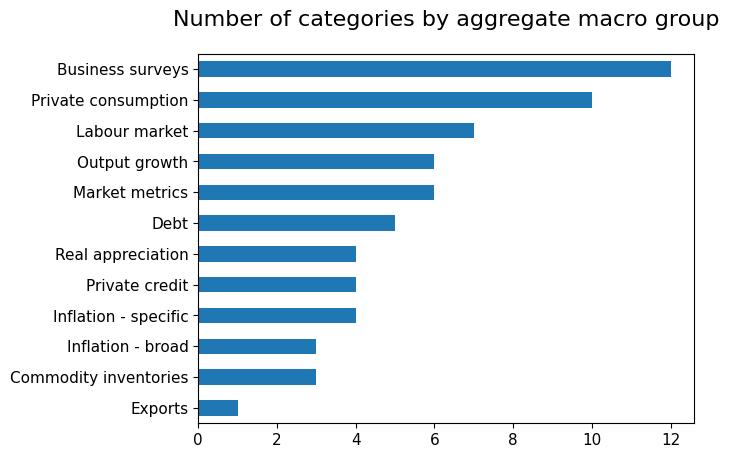

In [9]:
cat_groups_count = (
    cat_labels.index.to_frame()
    .reset_index(drop=True)
    .groupby("Group")["Category"].count()
    .sort_values(ascending=True)
)

fig = cat_groups_count.plot.barh(
    ylabel="",
    fontsize=11
)
fig.set_title(label="Number of categories by aggregate macro group", pad=20)
fig.title.set_size(16)

plt.plot()

## Feature filtering and imputation

### Cross-section availability requirement

In [10]:
# All normalized macroeconomic categories
all_macroz = [x + "_ZN" for x in ecos] 

# Identify categories with less than 10 cross sections
df_macro = df[df["xcat"].isin(all_macroz)]
cid_counts = df_macro.groupby('xcat')['cid'].nunique()
xcatx_low_cid = cid_counts[cid_counts < 10].index.tolist()
print("Categories with less than 10 cross sections:\n")
for xcat in xcatx_low_cid:
    print(xcat)

# Remove categories with less than 10 cross sections
macroz = [x for x in all_macroz if not x in xcatx_low_cid]

# Identify categories that have short history

df_macro = df[df["xcat"].isin(macroz)]
cutoff_date = pd.Timestamp("2003-01-01")
min_dates = df_macro.groupby('xcat')['real_date'].min()
xcatx_late_start = min_dates[min_dates >= cutoff_date].index.tolist()
print("\nCategories that start after 2002:\n")
for xcat in xcatx_late_start:
    print(xcat)

# Remove categories that start late
macroz = [x for x in macroz if not x in xcatx_late_start]

Categories with less than 10 cross sections:

CBCSCORE_SA_D3M3ML3_WG_ZN
CBCSCORE_SA_D3M3ML3_ZN
CBCSCORE_SA_WG_ZN
CBCSCORE_SA_ZN
CORPINTNETGDP_SA_D1Q1QL4_WG_ZN
CORPINTNETGDP_SA_D1Q1QL4_ZN
HHINTNETGDP_SA_D1M1ML12_WG_ZN
HHINTNETGDP_SA_D1M1ML12_ZN

Categories that start after 2002:

COXR_VT10vWTI_21DMA_ZN


In [11]:
# Reduce label dictionary

cat_label_dict = {k:v for k, v in cat_alllabel_dict.items() if k in macroz}

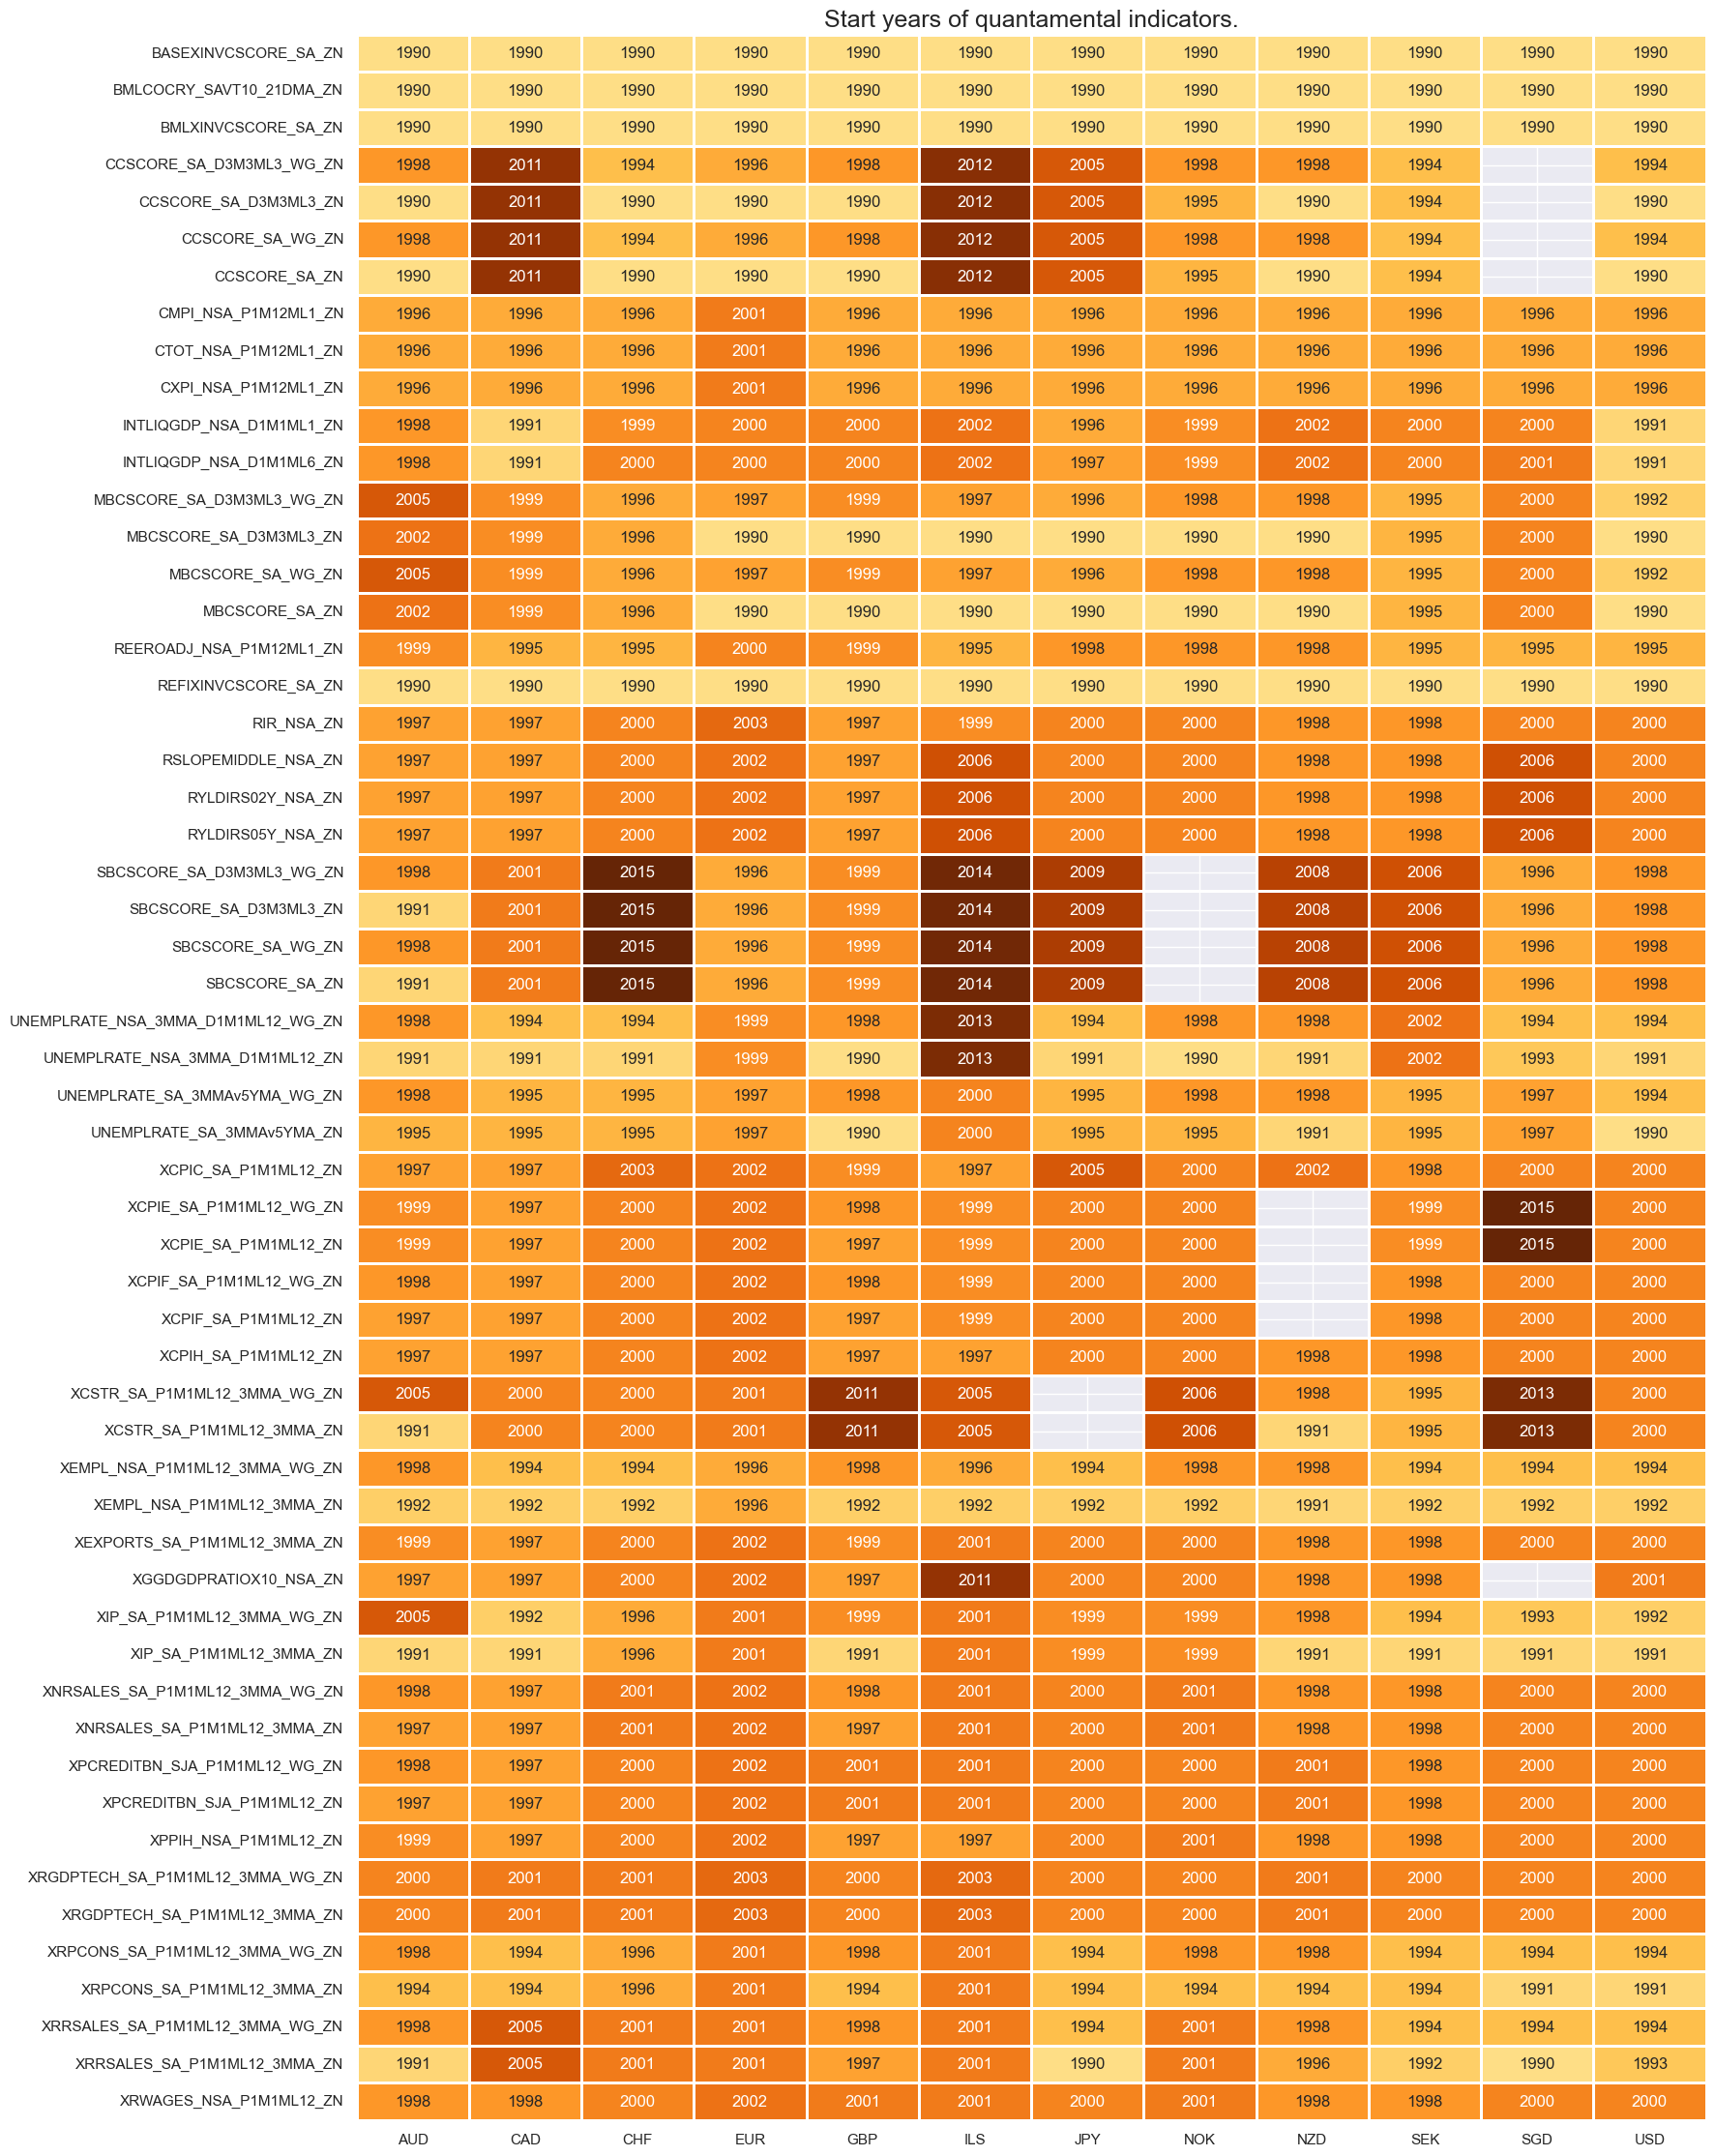

In [12]:
# Visualize remaining macroeconomic categories
msm.check_availability(df, xcats=macroz, cids=cids_eq, missing_recent=False)

### Conditional imputation of missing cross-sections

In [13]:
# Impute cross-sectional values if majority of cross sections are available

# Set parameters
impute_missing_cids = True
min_ratio_cids = 0.4

# Exclude categories than cannot logically be imputed
non_imputables = [
    "CXPI_NSA_P1M12ML1_ZN",
    "CMPI_NSA_P1M12ML1_ZN",
    "CTOT_NSA_P1M12ML1_ZN",
    "REEROADJ_NSA_P1M12ML1_ZN",
]
imputables = list(set(macroz) - set(non_imputables))

if impute_missing_cids:
    df_impute = msp.impute_panel(
        df=df, xcats=imputables, cids=cids_eq, threshold=min_ratio_cids
    )
    dfx = msm.update_df(df, df_impute)
else:
    dfx = df.copy()

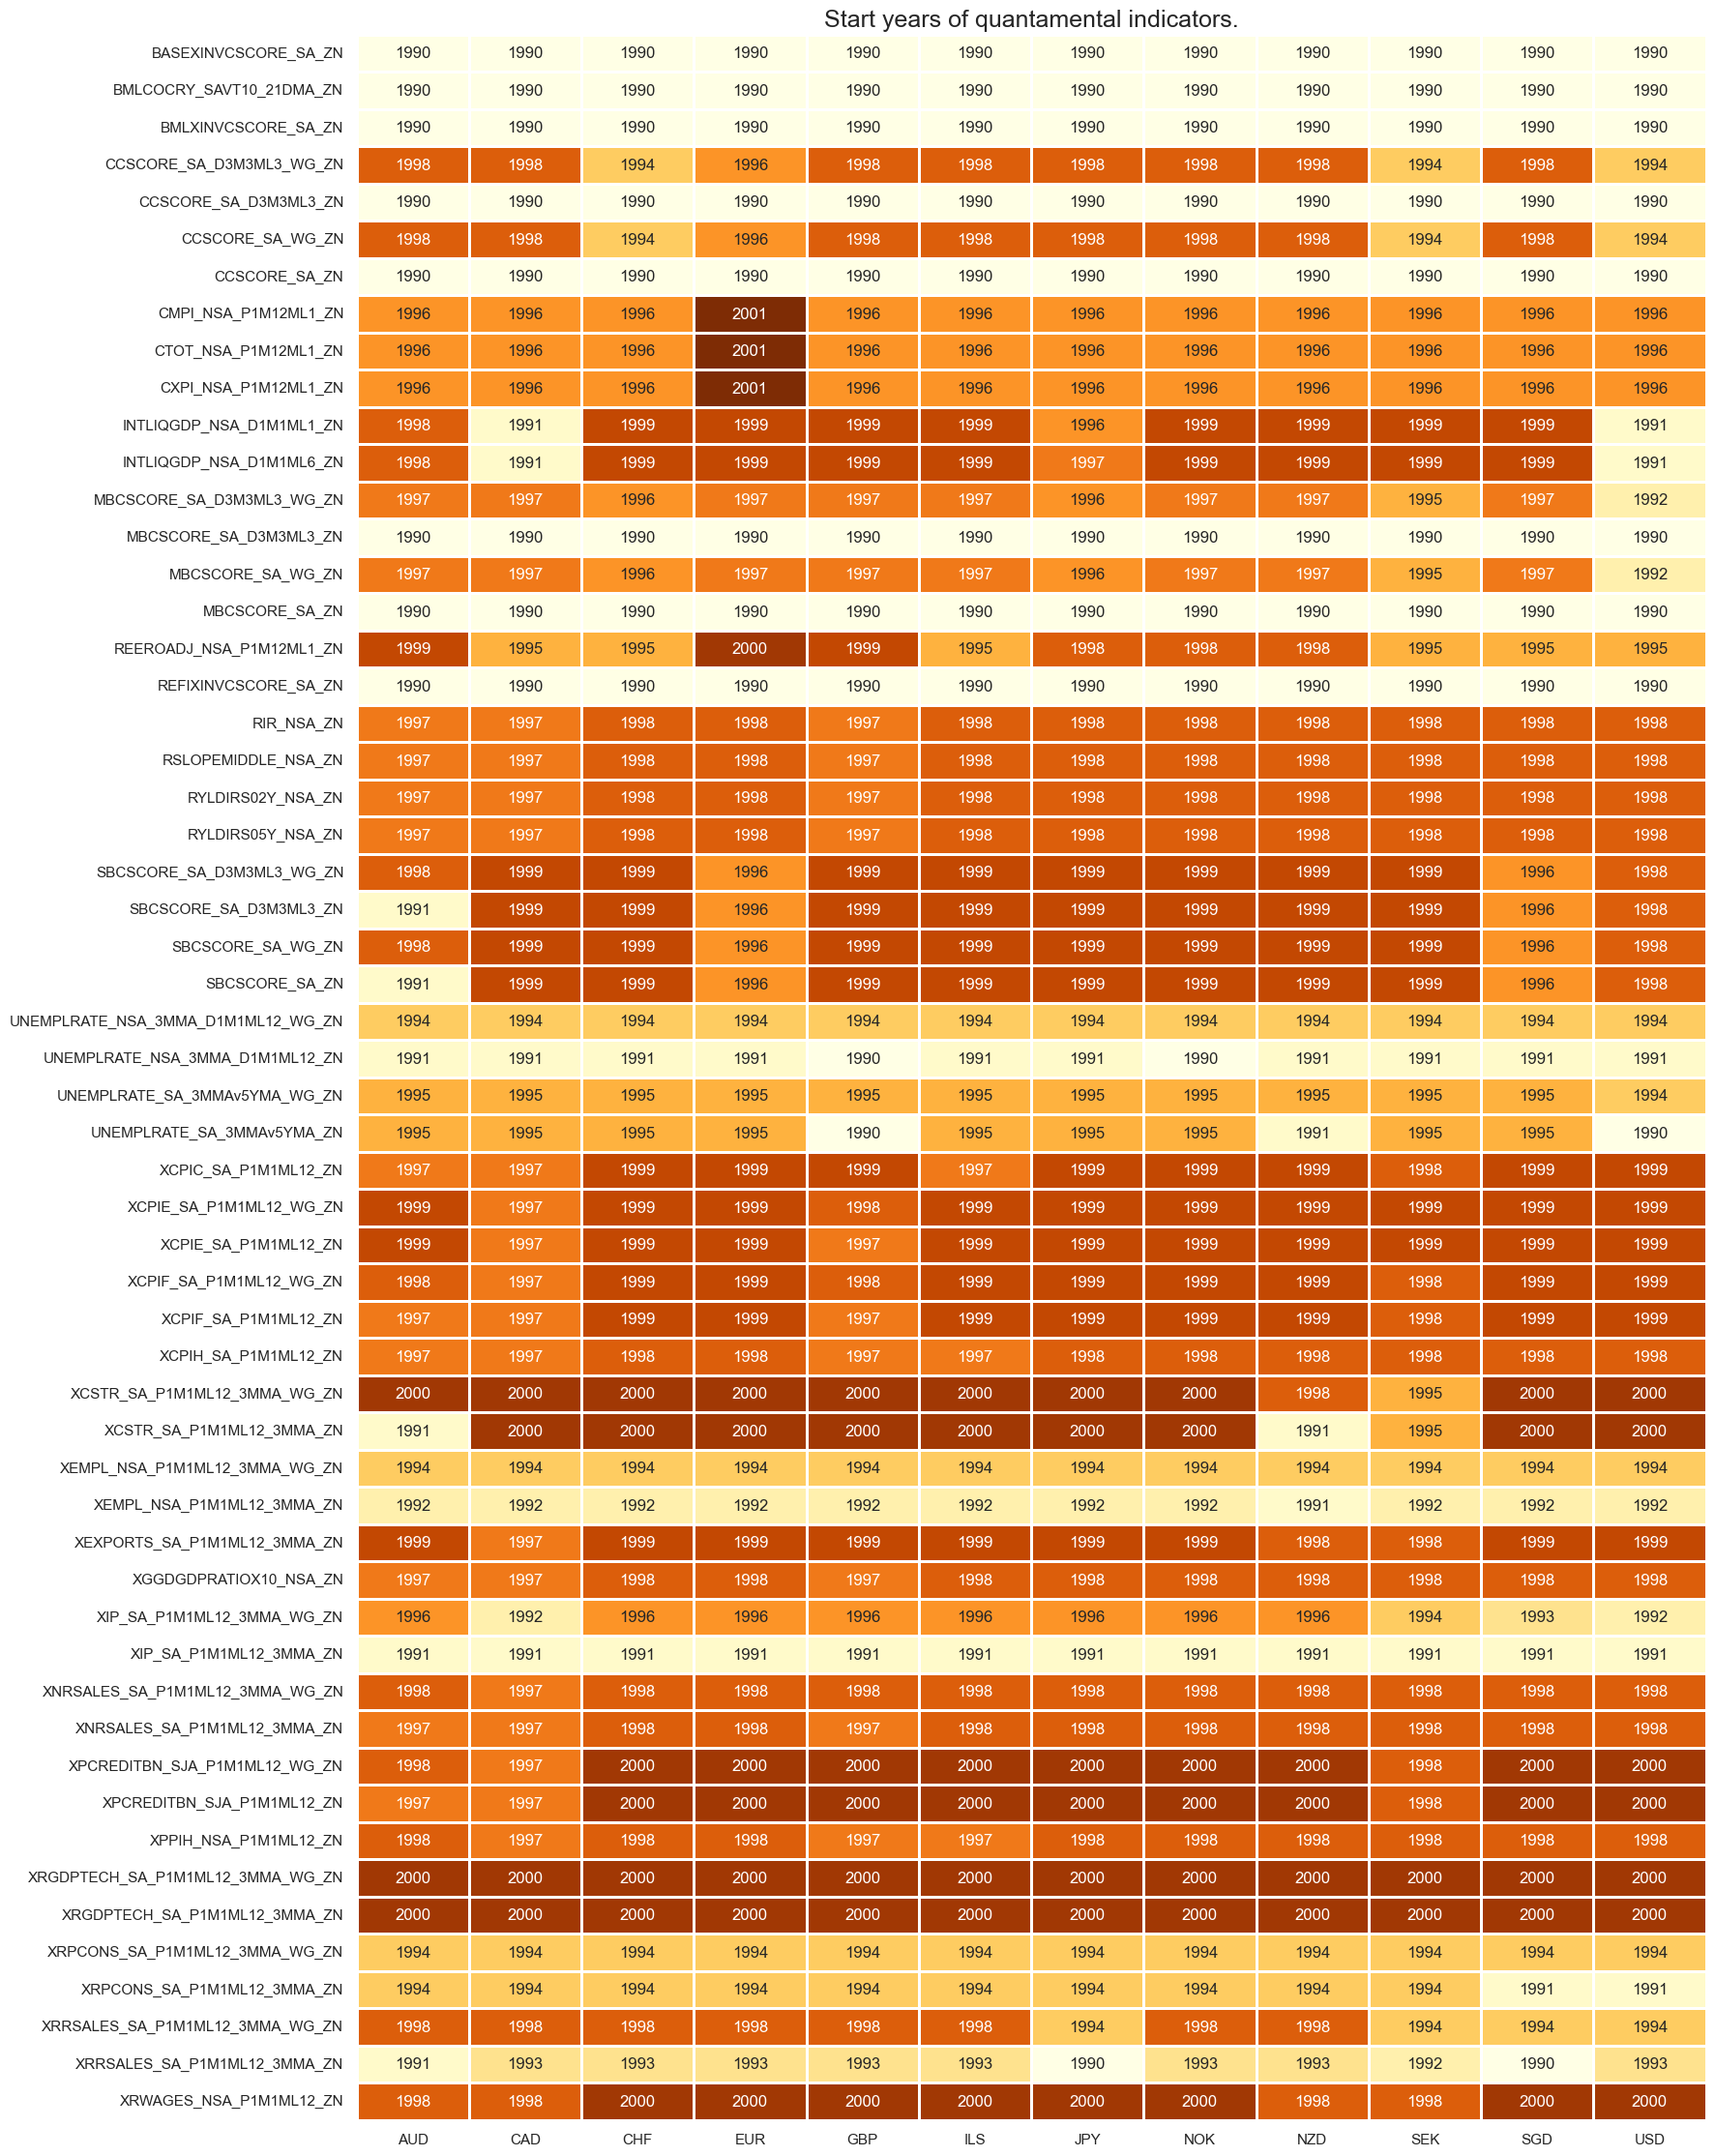

In [14]:
# Visualize imputed macroeconomic categories
msm.check_availability(dfx, xcats=macroz, cids=cids_eq, missing_recent=False)

### Equity sectoral return blacklisting

In [15]:
sector_blacklist = {}

for sec in list(set(cids_secs) - {"ALL"}):
    
    dfb = df[df["xcat"] == f"EQC{sec}UNTRADABLE_NSA"].loc[:, ["cid", "xcat", "real_date", "value"]]
    dfba = (
        dfb.groupby(["cid", "real_date"])
        .aggregate(value=pd.NamedAgg(column="value", aggfunc="max"))
        .reset_index()
    )
    dfba["xcat"] = f"EQC{sec}BLACK"
    
    sector_blacklist[sec] = msp.make_blacklist(dfba, f"EQC{sec}BLACK")

## Visualize target availability

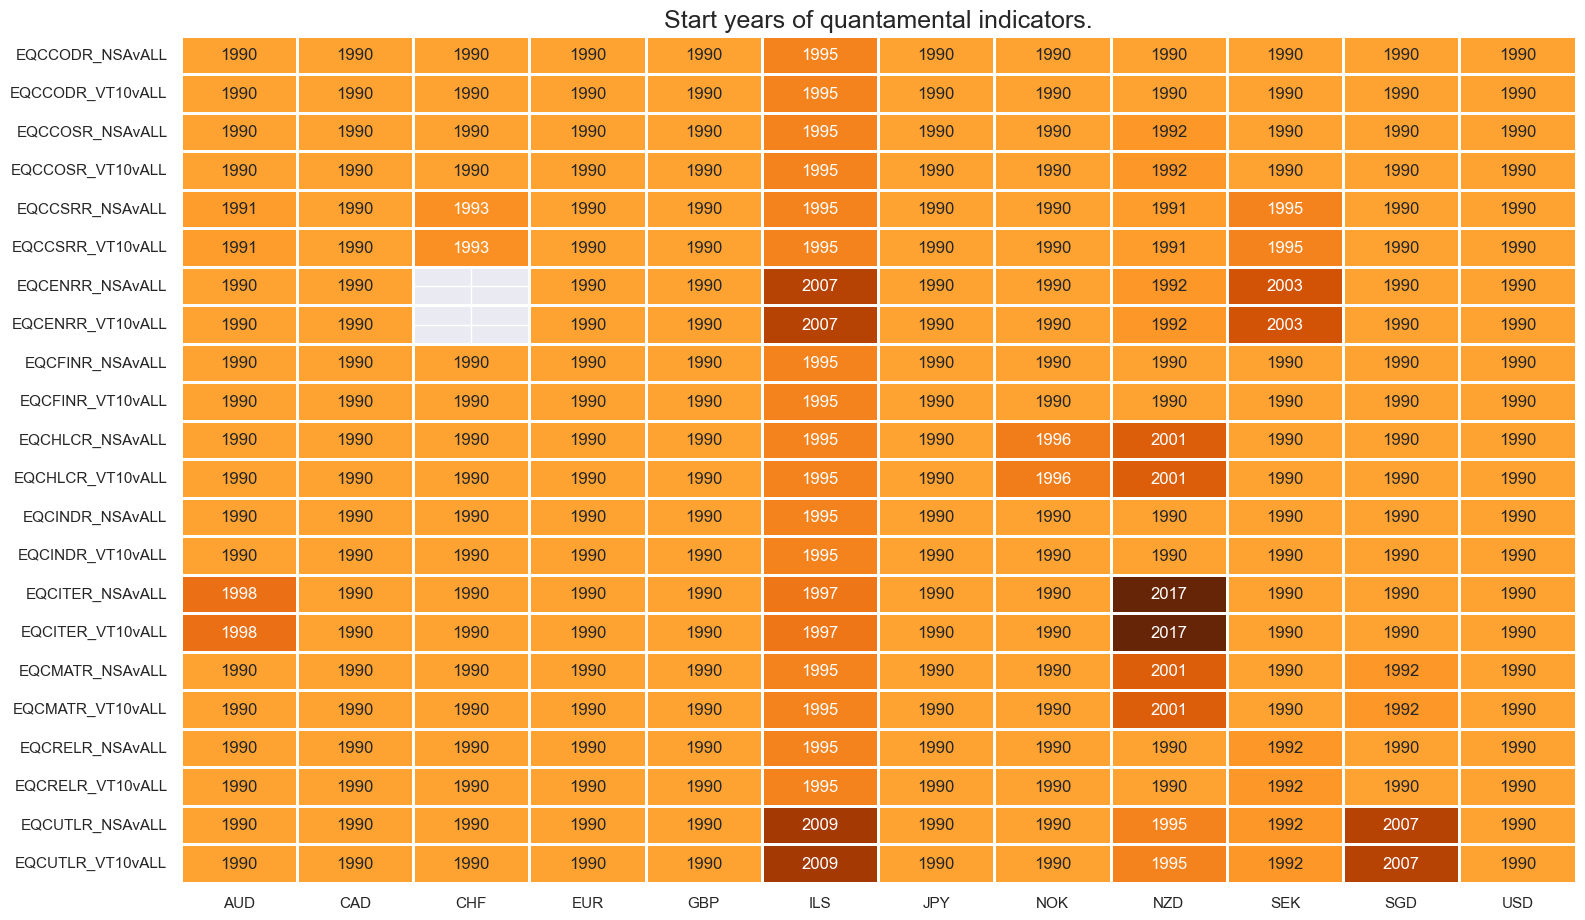

In [16]:
targets = [
    x for x in eqrets if x.endswith(("R_NSAvALL", "R_VT10vALL"))
]
msm.check_availability(dfx, targets, missing_recent=False)

## Sectoral signals and naive PnLs

### Common pipeline for all sectors

In [17]:
default_target_type = "R_VT10vALL"

#### Model hyperparameters

In [18]:
# Model dictionary
default_models = {
    "rf": RandomForestRegressor(
        n_estimators = 100,
        random_state = 42,
    )
}

# Hyperparameter grid   
default_hparam_grid = {
    "rf": {
        "max_samples": [0.1, 0.25],
        "max_features": ["sqrt", 0.5],
        "min_samples_leaf": [1, 3, 6, 9]
    },
}

#### Cross-validation splitter

In [142]:
default_splitter = {"Validation": msl.RecencyKFoldPanelSplit(n_periods=12, n_splits = 1)}

#### Validation metric

We use the probability of significance of correlation over the panel, arising from the MAP test, accounting for cross-sectional correlations in the panel, as a suitable performance metric. This should encourage the model selection process to favour models with evidence of predictive power, as well as capturing sufficient cross-sectional variation.

In [143]:
default_metric = {
    "MAP": make_scorer(msl.panel_significance_probability, greater_is_better=True),
}

#### Dynamics of the backtest

The initial training set is the smallest possible training set comprising two years' of data for two cross-sections. This is specified by setting `min_periods = 24` and `min_cids = 2`. Model selection occurs each month, by specifying `test_size = 1`. The start date of the backtest is January 2003, since the initial training set absorbs data. 

In [144]:
# Default parameters
default_test_size = 1  # retraining interval in months
default_min_cids = 2  # minimum number of cids to start predicting
default_min_periods = 24  # minimum number of periods to start predicting
default_split_functions = None
default_start_date = "2003-01-31"  # start date for the analysis

### Energy

#### Factor selection and signal generation

In [145]:
sector = "ENR"

enr_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": list(set(cids_eq)-set(["CHF"])), # CHF has no energy companies
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [146]:
xcatx = enr_dict["xcatx"] + [enr_dict["ret"]]
cidx = enr_dict["cidx"]

so_enr = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=enr_dict["black"],
    freq=enr_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

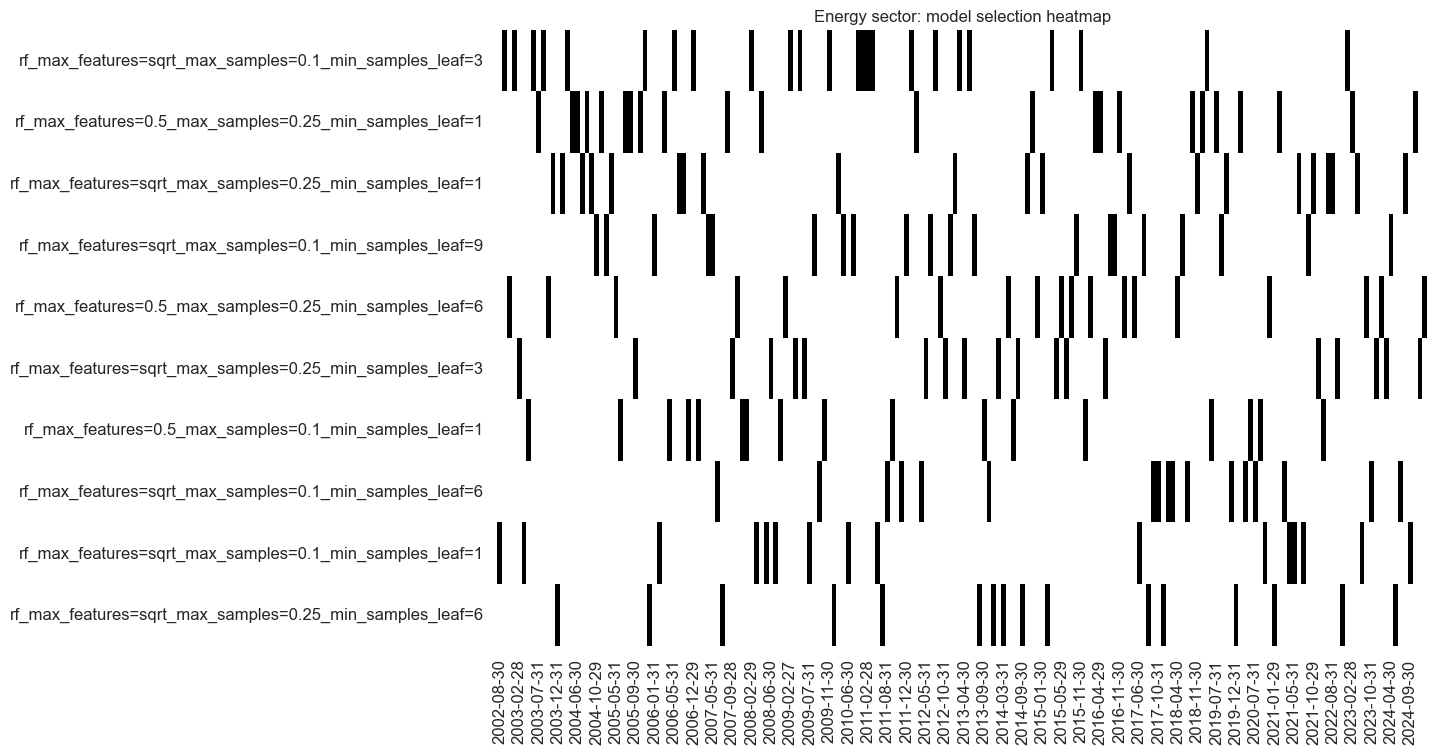

In [147]:
secname = enr_dict["sector_name"]
signal_name = enr_dict["signal_name"]

so_enr.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_enr.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_enr.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [148]:
enr_importances = (
    so_enr.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

enr_importances

BMLXINVCSCORE_SA_ZN  BMLCOCRY_SAVT10_21DMA_ZN  REFIXINVCSCORE_SA_ZN  \
count           271.000000                271.000000            271.000000   
mean              0.030927                  0.030094              0.024739   
min               0.000000                  0.009212              0.004156   
25%               0.024789                  0.025452              0.020337   
50%               0.029669                  0.029542              0.024300   
75%               0.036705                  0.034473              0.028142   
max               0.068146                  0.065267              0.048316   
std               0.011594                  0.007470              0.007346   

       BASEXINVCSCORE_SA_ZN  REEROADJ_NSA_P1M12ML1_ZN  RYLDIRS05Y_NSA_ZN  \
count            271.000000                271.000000         271.000000   
mean               0.022718                  0.021585           0.020675   
min                0.005009                  0.011105           0.007890   
25%                0.019671                  0.018761           0.017459   
50%                0.023108                  0.021182           0.020781   
75%                0.026200                  0.024050           0.023294   
max                0.045445                  0.050443           0.055328   
std                0.005843                  0.004575           0.005386   

       XPPIH_NSA_P1M1ML12_ZN  XRWAGES_NSA_P1M1ML12_ZN  \
count             271.000000               271.000000   
mean                0.020389                 0.020245   
min                 0.008432                 0.007092   
25%                 0.016626                 0.017363   
50%                 0.019060                 0.020288   
75%                 0.022669                 0.022118   
max                 0.045022                 0.041524   
std                 0.005957                 0.004405   

       XCSTR_SA_P1M1ML12_3MMA_WG_ZN  CCSCORE_SA_WG_ZN  ...  \
count                    271.000000        271.000000  ...   
mean                       0.019975          0.019587  ...   
min                        0.002683          0.003043  ...   
25%                        0.017500          0.016902  ...   
50%                        0.019665          0.018822  ...   
75%                        0.022515          0.022045  ...   
max                        0.037962          0.040932  ...   
std                        0.004936          0.004658  ...   

       UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  CTOT_NSA_P1M12ML1_ZN  \
count                          271.000000            271.000000   
mean                             0.015361              0.015102   
min                              0.002792              0.007286   
25%                              0.013154              0.013047   
50%                              0.015214              0.014534   
75%                              0.017299              0.016414   
max                              0.030651              0.040133   
std                              0.003907              0.003629   

       XEMPL_NSA_P1M1ML12_3MMA_ZN  MBCSCORE_SA_ZN  \
count                  271.000000      271.000000   
mean                     0.015038        0.014972   
min                      0.000000        0.003520   
25%                      0.012971        0.012874   
50%                      0.015272        0.014778   
75%                      0.017252        0.016932   
max                      0.039301        0.035290   
std                      0.003765        0.003564   

       XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN  XIP_SA_P1M1ML12_3MMA_ZN  \
count                        271.000000               271.000000   
mean                           0.014865                 0.014725   
min                            0.004578                 0.000388   
25%                            0.012466                 0.012885   
50%                            0.014652                 0.014541   
75%                            0.016736                 

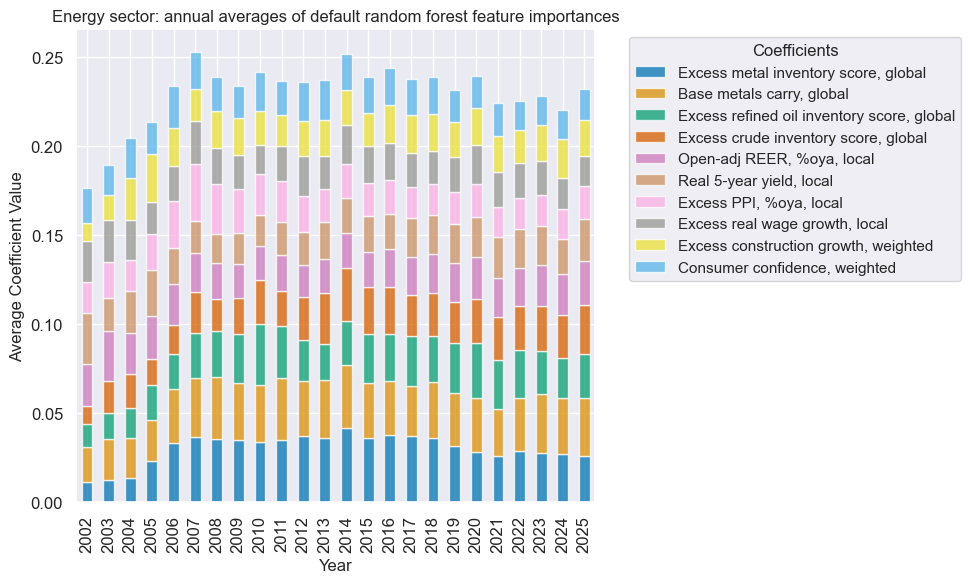

In [149]:
xcatx = enr_dict["signal_name"]
secname = enr_dict["sector_name"]

so_enr.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(enr_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

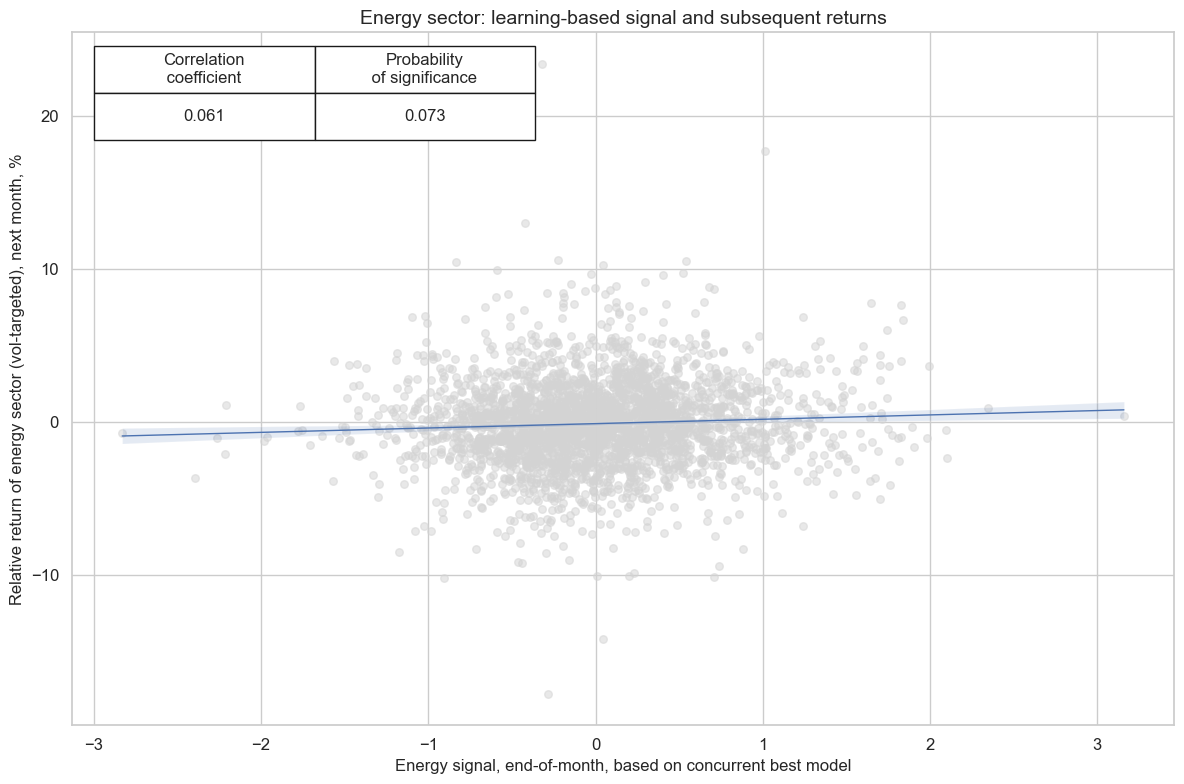

In [150]:
xcatx = [enr_dict["signal_name"], enr_dict["ret"]]
cidx = enr_dict["cidx"]
secname = enr_dict["sector_name"]

cr_enr = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=enr_dict["freq"],
    lag=1,
    blacklist=enr_dict["black"],
    xcat_aggs=["last", "sum"],
    slip=1,
    xcat_trims=[30, 30],  # trim dodgy data point
)

cr_enr.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

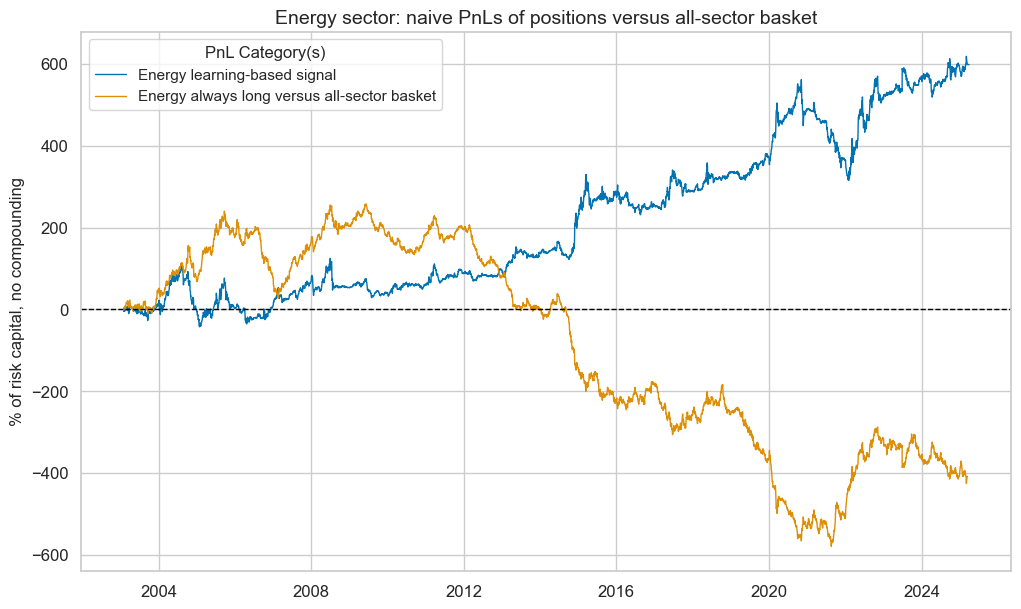

xcat                     Energy learning-based signal  \
Return %                                    27.019865   
St. Dev. %                                  57.909781   
Sharpe Ratio                                 0.466586   
Sortino Ratio                                0.675189   
Max 21-Day Draw %                          -87.604987   
Max 6-Month Draw %                        -147.524394   
Peak to Trough Draw %                     -246.496899   
Top 5% Monthly PnL Share                     0.952336   
USD_EQXR_NSA correl                         -0.058604   
Traded Months                                     267   

xcat                     Energy always long versus all-sector basket  
Return %                                                  -18.469388  
St. Dev. %                                                 53.016948  
Sharpe Ratio                                               -0.348368  
Sortino Ratio                                              -0.478872  
Max 21-Day Draw %                                         -78.404808  
Max 6-Month Draw %                                        -186.69396  
Peak to Trough Draw %                                    -837.214078  
Top 5% Monthly PnL Share                                   -1.395043  
USD_EQXR_NSA correl                                        -0.047811  
Traded Months                                                    267

In [151]:
xcatx = [enr_dict["signal_name"]]
cidx = enr_dict["cidx"]
secname = enr_dict["sector_name"]

pnl_enr = msn.NaivePnL(
    df=dfx,
    ret=enr_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=enr_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_enr.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=enr_dict["pnl_name"],
    )
pnl_enr.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_enr.plot_pnls(
    pnl_cats=pnl_enr.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

enr_dict["pnls"] = pnl_enr
pnl_enr.evaluate_pnls(pnl_cats=pnl_enr.pnl_names)

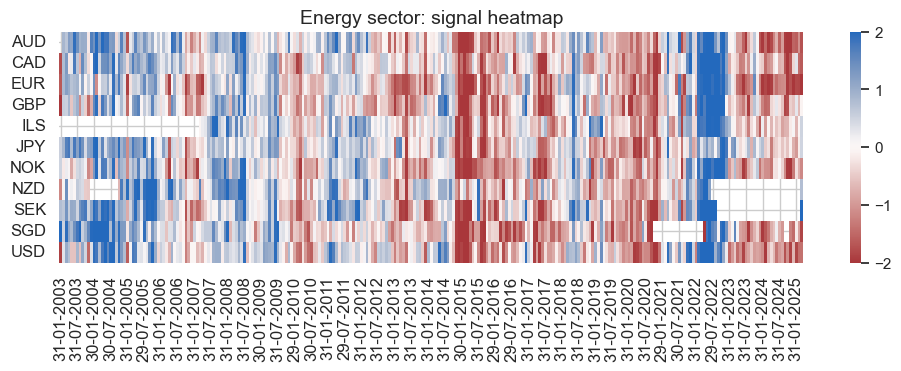

In [152]:
secname = enr_dict["sector_name"]

pnl_enr.signal_heatmap(
    pnl_name=enr_dict["pnl_name"],
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Materials

#### Factor selection and signal generation

In [153]:
sector = "MAT"

mat_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [154]:
xcatx = mat_dict["xcatx"] + [mat_dict["ret"]]
cidx = mat_dict["cidx"]

so_mat = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=mat_dict["black"],
    freq=mat_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

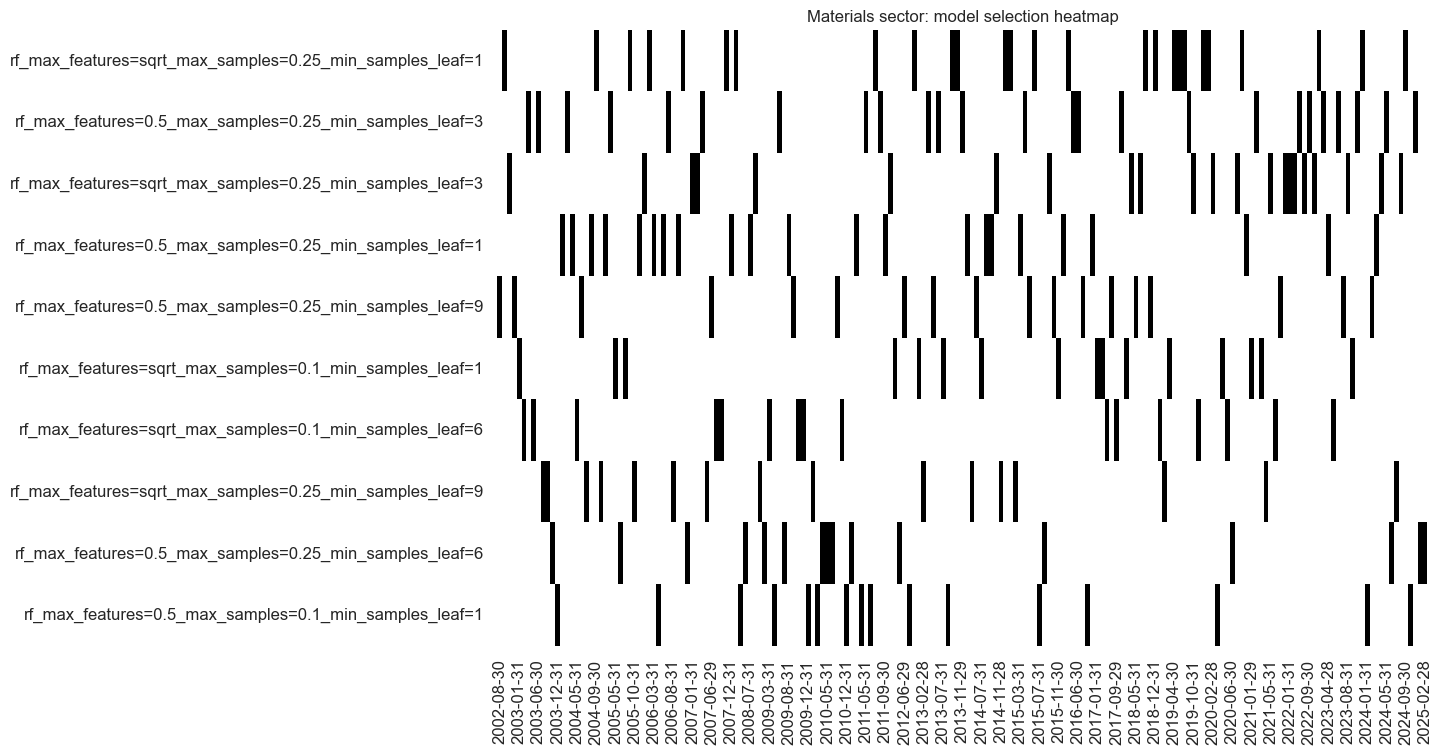

In [155]:
secname = mat_dict["sector_name"]
signal_name = mat_dict["signal_name"]

so_mat.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_mat.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_mat.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [156]:
mat_importances = (
    so_mat.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

mat_importances

REFIXINVCSCORE_SA_ZN  BMLCOCRY_SAVT10_21DMA_ZN  \
count            271.000000                271.000000   
mean               0.027414                  0.027049   
min                0.007395                  0.014302   
25%                0.023650                  0.023519   
50%                0.027418                  0.026524   
75%                0.030734                  0.029970   
max                0.043441                  0.059587   
std                0.006042                  0.006272   

       REEROADJ_NSA_P1M12ML1_ZN  SBCSCORE_SA_D3M3ML3_WG_ZN  CCSCORE_SA_WG_ZN  \
count                271.000000                 271.000000        271.000000   
mean                   0.022460                   0.022121          0.021919   
min                    0.010688                   0.006639          0.009518   
25%                    0.019665                   0.019426          0.019022   
50%                    0.022170                   0.021804          0.021169   
75%                    0.024573                   0.024508          0.023796   
max                    0.041570                   0.037830          0.038766   
std                    0.004554                   0.004668          0.004484   

       XCPIF_SA_P1M1ML12_WG_ZN  SBCSCORE_SA_D3M3ML3_ZN  RIR_NSA_ZN  \
count               271.000000              271.000000  271.000000   
mean                  0.021428                0.021095    0.020548   
min                   0.009580                0.007751    0.008293   
25%                   0.018857                0.018734    0.017751   
50%                   0.020629                0.020799    0.020361   
75%                   0.023231                0.023141    0.023172   
max                   0.041611                0.034210    0.035389   
std                   0.004530                0.004227    0.004572   

       BASEXINVCSCORE_SA_ZN  BMLXINVCSCORE_SA_ZN  ...  RSLOPEMIDDLE_NSA_ZN  \
count            271.000000           271.000000  ...           271.000000   
mean               0.020401             0.020377  ...             0.015399   
min                0.006952             0.001908  ...             0.003000   
25%                0.017253             0.015761  ...             0.013849   
50%                0.019915             0.020936  ...             0.015407   
75%                0.023492             0.024669  ...             0.016882   
max                0.041623             0.038614  ...             0.028934   
std                0.005204             0.006792  ...             0.002997   

       UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  XCPIE_SA_P1M1ML12_ZN  \
count                          271.000000            271.000000   
mean                             0.015342              0.015168   
min                              0.007019              0.006584   
25%                              0.013341              0.013634   
50%                              0.014969              0.014956   
75%                              0.016645              0.016761   
max                              0.031476              0.031369   
std                              0.003495              0.002820   

       MBCSCORE_SA_WG_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN  MBCSCORE_SA_ZN  \
count         271.000000                        271.000000      271.000000   
mean            0.015146                          0.015032        0.014260   
min             0.004917                          0.000000        0.004926   
25%             0.012960                          0.013299        0.012679   
50%             0.014993                          0.014808        0.014342   
75%             0.016988                          0.016928        0.016275   
max             0.031679                          0.027276        0.023415   
std             0.003364                          0.003275        0.002851   

       XRGDPTECH_SA_P1M1ML12_3MMA_ZN  XIP_SA_P1M1ML12_3MMA_ZN  \
count                     271.000000               271.000000   
m

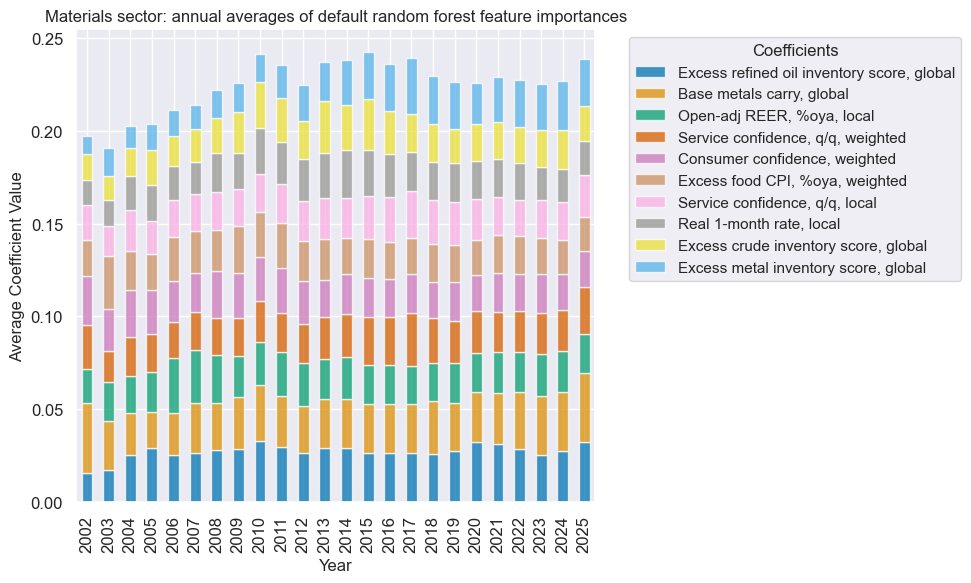

In [157]:
xcatx = mat_dict["signal_name"]
secname = mat_dict["sector_name"]

so_mat.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(mat_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

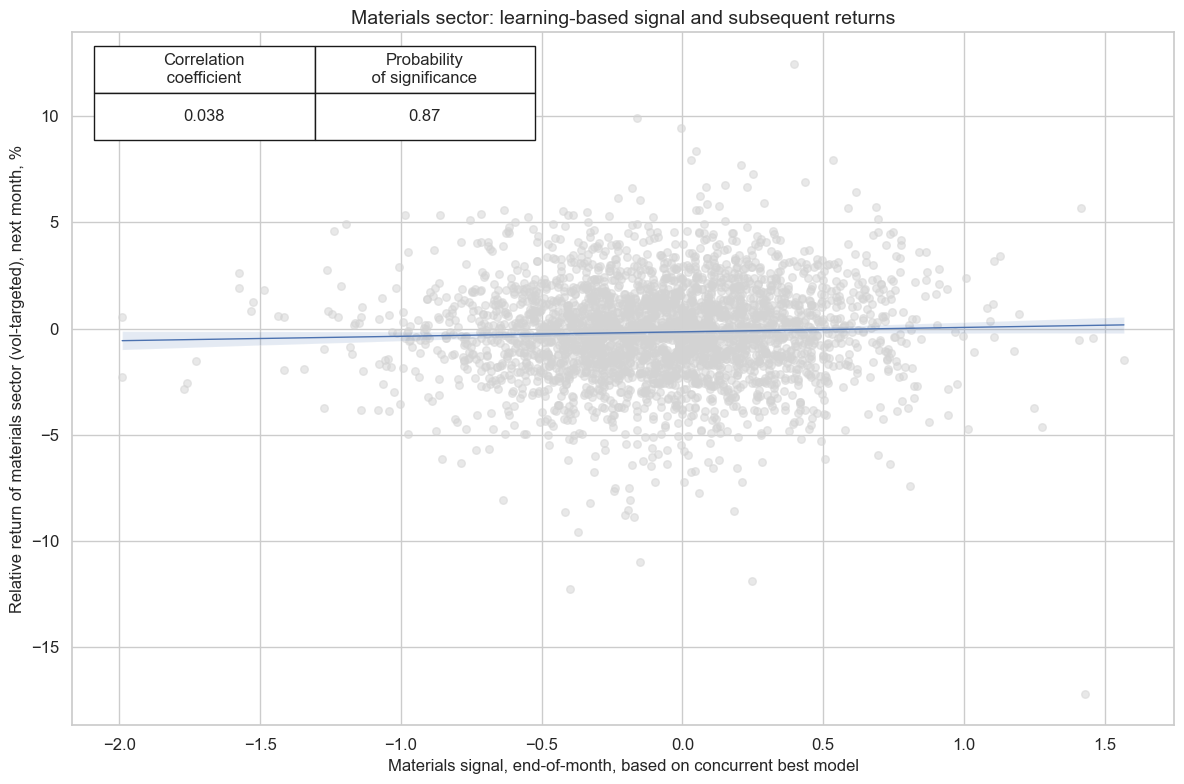

In [158]:
xcatx = [mat_dict["signal_name"], mat_dict["ret"]]
cidx = mat_dict["cidx"]
secname = mat_dict["sector_name"]

cr_mat = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=mat_dict["freq"],
    blacklist=mat_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
    xcat_trims=[2, 20],
)

cr_mat.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

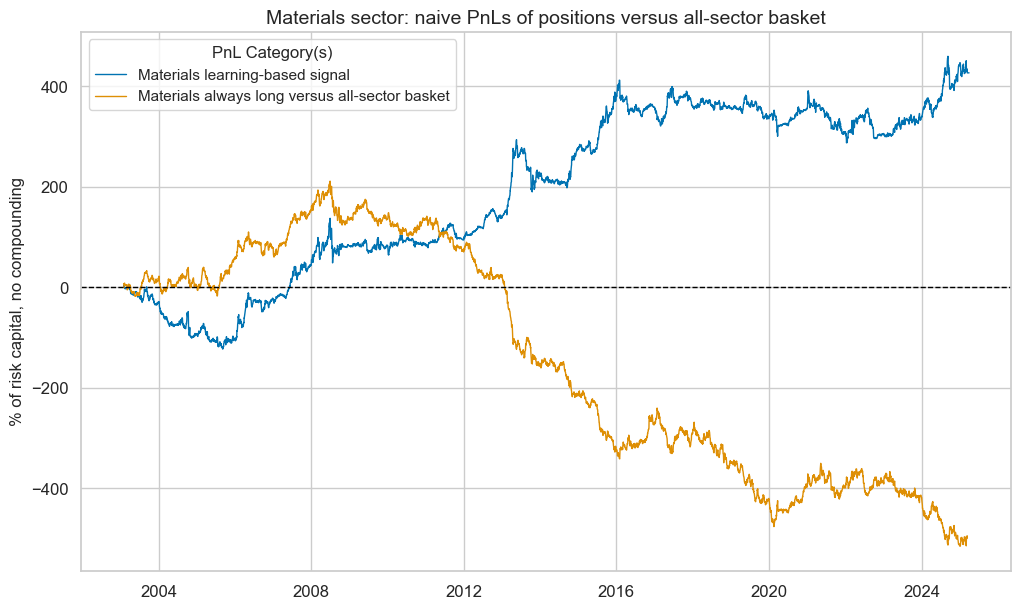

xcat                     Materials learning-based signal  \
Return %                                       19.239838   
St. Dev. %                                     43.681819   
Sharpe Ratio                                    0.440454   
Sortino Ratio                                   0.619307   
Max 21-Day Draw %                             -74.894154   
Max 6-Month Draw %                            -92.416881   
Peak to Trough Draw %                        -127.270629   
Top 5% Monthly PnL Share                        1.175033   
USD_EQXR_NSA correl                            -0.015116   
Traded Months                                        267   

xcat                     Materials always long versus all-sector basket  
Return %                                                       -22.3526  
St. Dev. %                                                    40.209911  
Sharpe Ratio                                                  -0.555898  
Sortino Ratio                                                  -0.76508  
Max 21-Day Draw %                                            -61.657388  
Max 6-Month Draw %                                          -152.838949  
Peak to Trough Draw %                                        -725.96649  
Top 5% Monthly PnL Share                                      -0.718067  
USD_EQXR_NSA correl                                             0.02638  
Traded Months                                                       267

In [162]:
xcatx = [mat_dict["signal_name"]]
cidx = mat_dict["cidx"]
secname = mat_dict["sector_name"]
pnl_name = mat_dict["pnl_name"]

pnl_mat = msn.NaivePnL(
    df=dfx,
    ret=mat_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=mat_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_mat.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_mat.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_mat.plot_pnls(
    pnl_cats=pnl_mat.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

mat_dict["pnls"] = pnl_mat
pnl_mat.evaluate_pnls(pnl_cats=pnl_mat.pnl_names)

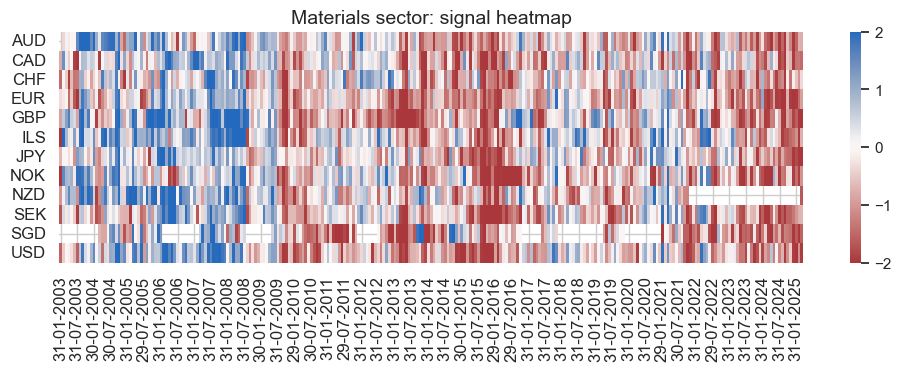

In [163]:
secname = mat_dict["sector_name"]
xcatx = mat_dict["signal_name"]

pnl_mat.signal_heatmap(
    pnl_name=f"{secname} learning-based signal",
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Industrials

#### Factor selection and signal generation

In [164]:
sector = "IND"

ind_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [165]:
xcatx = ind_dict["xcatx"] + [ind_dict["ret"]]
cidx = ind_dict["cidx"]

so_ind = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=ind_dict["black"],
    freq=ind_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

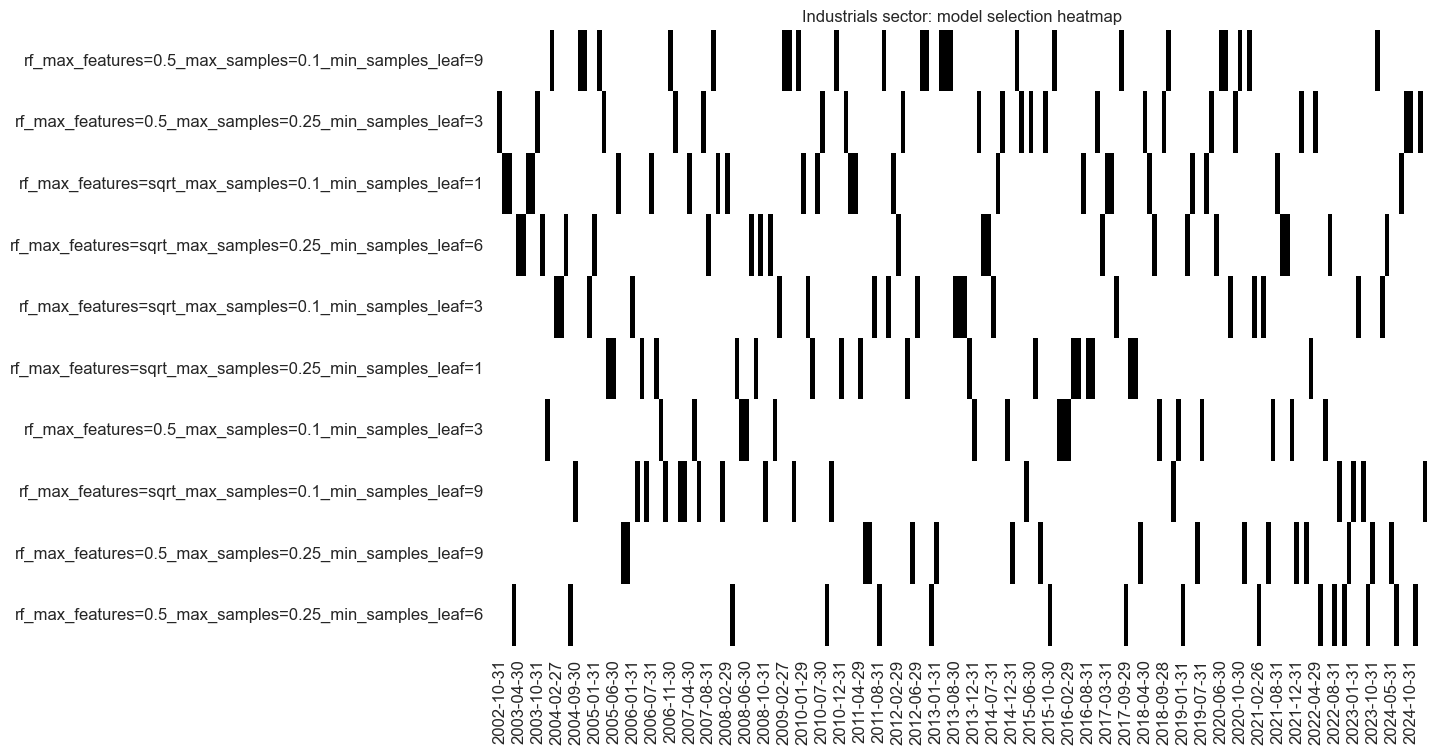

In [166]:
secname = ind_dict["sector_name"]
signal_name = ind_dict["signal_name"]

so_ind.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_ind.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_ind.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [167]:
ind_importances = (
    so_ind.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

ind_importances

BMLCOCRY_SAVT10_21DMA_ZN  BMLXINVCSCORE_SA_ZN  CCSCORE_SA_WG_ZN  \
count                271.000000           271.000000        271.000000   
mean                   0.035782             0.026190          0.021598   
min                    0.001200             0.001582          0.008547   
25%                    0.029026             0.021877          0.018609   
50%                    0.033740             0.026367          0.020932   
75%                    0.040701             0.031144          0.023798   
max                    0.087346             0.048761          0.057077   
std                    0.011091             0.008236          0.005121   

       XCPIC_SA_P1M1ML12_ZN  BASEXINVCSCORE_SA_ZN  XRWAGES_NSA_P1M1ML12_ZN  \
count            271.000000            271.000000               271.000000   
mean               0.020993              0.020895                 0.020396   
min                0.008321              0.001103                 0.010902   
25%                0.018905              0.018042                 0.017701   
50%                0.020921              0.021057                 0.019834   
75%                0.023198              0.024177                 0.021917   
max                0.034853              0.036690                 0.045568   
std                0.003976              0.005166                 0.004871   

       XGGDGDPRATIOX10_NSA_ZN  MBCSCORE_SA_D3M3ML3_ZN  \
count              271.000000              271.000000   
mean                 0.020269                0.019732   
min                  0.005734                0.009563   
25%                  0.017809                0.017123   
50%                  0.020234                0.019195   
75%                  0.023116                0.021464   
max                  0.033274                0.038618   
std                  0.004086                0.004233   

       XCPIE_SA_P1M1ML12_WG_ZN  REEROADJ_NSA_P1M12ML1_ZN  ...  \
count               271.000000                271.000000  ...   
mean                  0.019598                  0.019488  ...   
min                   0.000398                  0.009110  ...   
25%                   0.016979                  0.017398  ...   
50%                   0.019106                  0.019147  ...   
75%                   0.021519                  0.021143  ...   
max                   0.035167                  0.036525  ...   
std                   0.004670                  0.003669  ...   

       UNEMPLRATE_NSA_3MMA_D1M1ML12_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_ZN  \
count                       271.000000                     271.000000   
mean                          0.015653                       0.015401   
min                           0.001919                       0.005062   
25%                           0.013528                       0.013470   
50%                           0.015182                       0.015275   
75%                           0.017085                       0.017002   
max                           0.033791                       0.025962   
std                           0.003430                       0.002867   

       XRPCONS_SA_P1M1ML12_3MMA_WG_ZN  XEMPL_NSA_P1M1ML12_3MMA_WG_ZN  \
count                      271.000000                     271.000000   
mean                         0.015255                       0.015094   
min                          0.005769                       0.004008   
25%                          0.013813                       0.013272   
50%                          0.015160                       0.015190   
75%                          0.016606                       0.016932   
max                          0.043339                       0.027769   
std                          0.003433                       0.003176   

       XIP_SA_P1M1ML12_3MMA_ZN  XRPCONS_SA_P1M1ML12_3MMA_ZN  \
count               271.000000                   271.000000   
mean                  0.015050                     0.014864   
min                   0.002141           

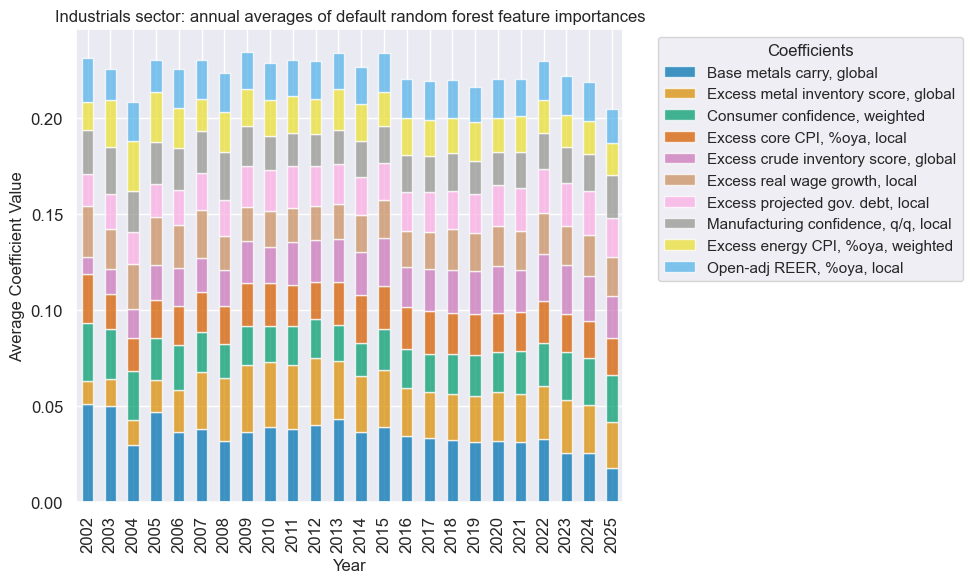

In [168]:
xcatx = ind_dict["signal_name"]
secname = ind_dict["sector_name"]

so_ind.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(ind_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

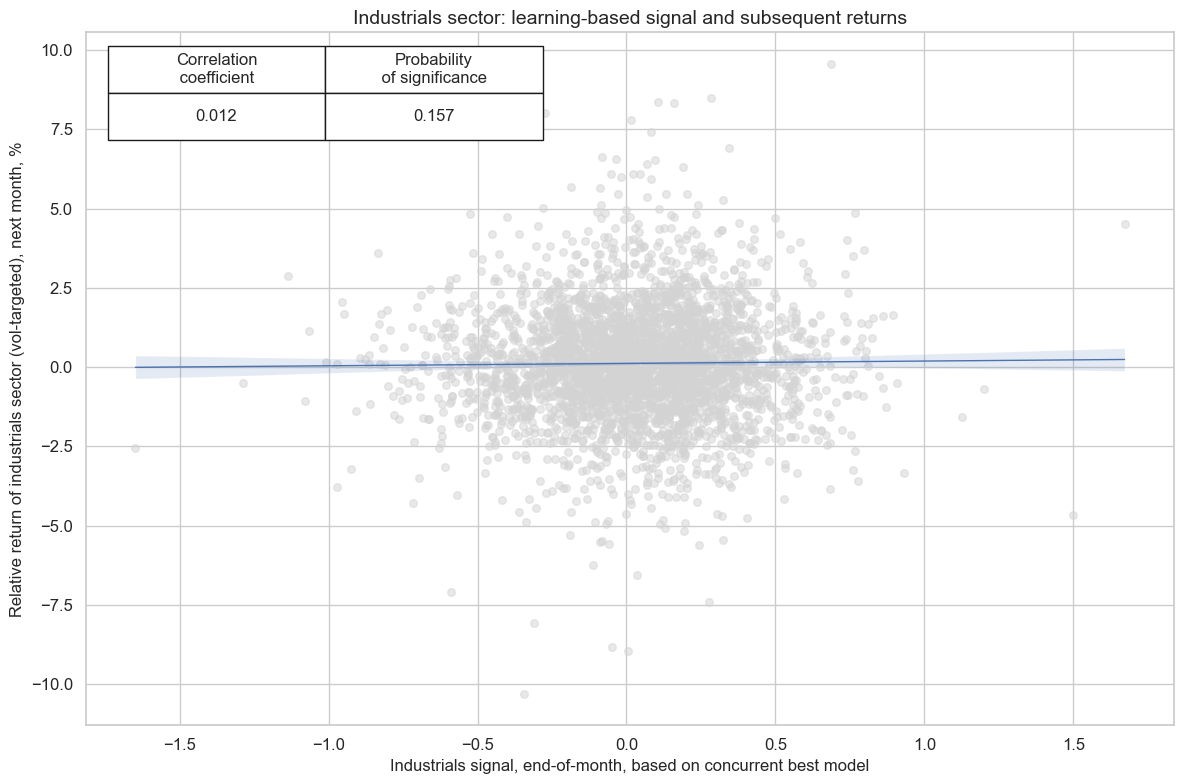

In [169]:
xcatx = [ind_dict["signal_name"], ind_dict["ret"]]
cidx = ind_dict["cidx"]
secname = ind_dict["sector_name"]

cr_ind = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=ind_dict["freq"],
    blacklist=ind_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_ind.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

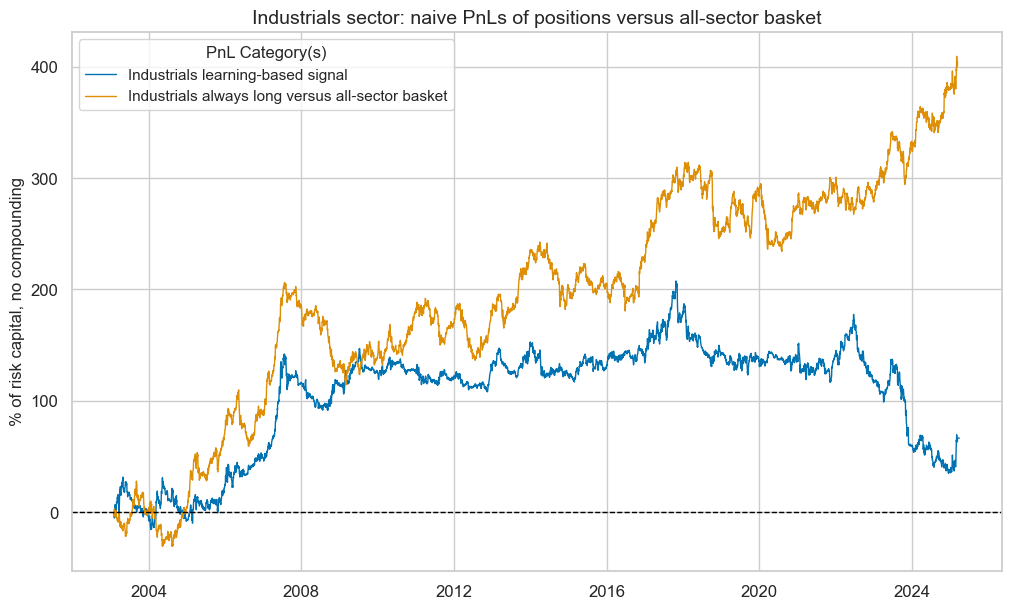

xcat                     Industrials learning-based signal  \
Return %                                           2.99681   
St. Dev. %                                       27.296944   
Sharpe Ratio                                      0.109786   
Sortino Ratio                                     0.155486   
Max 21-Day Draw %                               -35.858828   
Max 6-Month Draw %                              -77.279286   
Peak to Trough Draw %                           -172.77989   
Top 5% Monthly PnL Share                           3.59211   
USD_EQXR_NSA correl                              -0.001896   
Traded Months                                          267   

xcat                     Industrials always long versus all-sector basket  
Return %                                                        18.300281  
St. Dev. %                                                      31.947543  
Sharpe Ratio                                                     0.572823  
Sortino Ratio                                                    0.819209  
Max 21-Day Draw %                                              -54.172009  
Max 6-Month Draw %                                             -63.203195  
Peak to Trough Draw %                                          -91.886853  
Top 5% Monthly PnL Share                                         0.794551  
USD_EQXR_NSA correl                                              0.263312  
Traded Months                                                         267

In [170]:
xcatx = [ind_dict["signal_name"]]
cidx = ind_dict["cidx"]
secname = ind_dict["sector_name"]
pnl_name = ind_dict["pnl_name"]

pnl_ind = msn.NaivePnL(
    df=dfx,
    ret=ind_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    bms=["USD_EQXR_NSA"],
    blacklist=ind_dict["black"],
)

for xcat in xcatx:
    pnl_ind.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )

    pnl_ind.make_long_pnl(
        vol_scale=None, label=f"{secname} always long versus all-sector basket"
    )

pnl_ind.plot_pnls(
    pnl_cats=pnl_ind.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

ind_dict["pnls"] = pnl_ind
pnl_ind.evaluate_pnls(pnl_cats=pnl_ind.pnl_names)

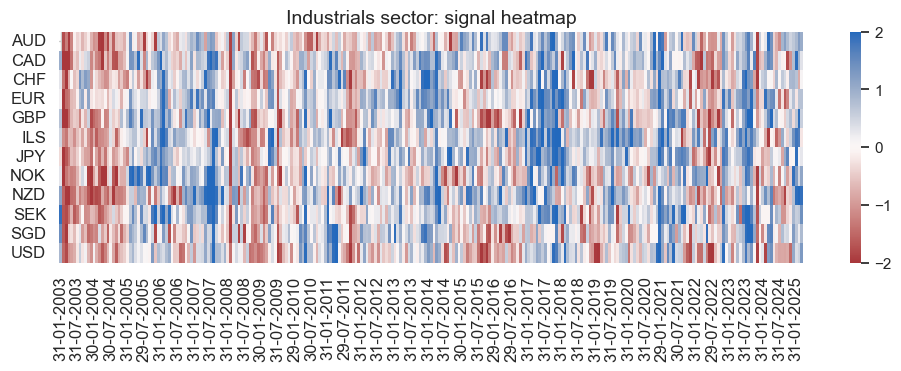

In [171]:
xcatx = ind_dict["signal_name"]
pnl_ind.signal_heatmap(
    pnl_name=f"{secname} learning-based signal",
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Consumer discretionary

#### Factor selection and signal generation

In [174]:
sector = "COD"

cod_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [175]:
xcatx = cod_dict["xcatx"] + [cod_dict["ret"]]
cidx = cod_dict["cidx"]

so_cod = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=cod_dict["black"],
    freq=cod_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

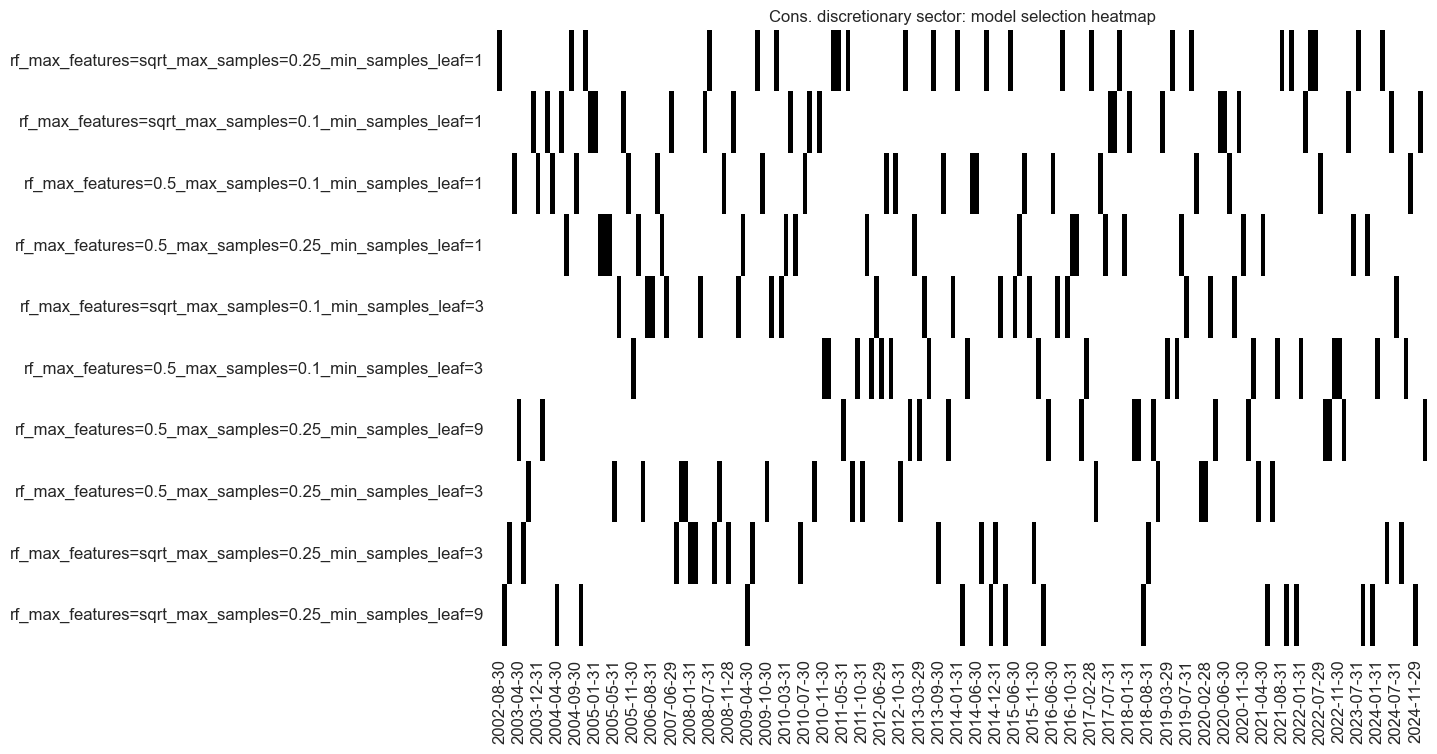

In [176]:
secname = cod_dict["sector_name"]
signal_name = cod_dict["signal_name"]

so_cod.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_cod.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_cod.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [177]:
cod_importances = (
    so_cod.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

cod_importances

XGGDGDPRATIOX10_NSA_ZN  BMLCOCRY_SAVT10_21DMA_ZN  CXPI_NSA_P1M12ML1_ZN  \
count              271.000000                271.000000            271.000000   
mean                 0.023720                  0.022884              0.021065   
min                  0.005425                  0.004415              0.012036   
25%                  0.020339                  0.020078              0.018426   
50%                  0.023477                  0.022541              0.020640   
75%                  0.026788                  0.025686              0.022816   
max                  0.043029                  0.042228              0.038962   
std                  0.005174                  0.005089              0.004082   

       SBCSCORE_SA_WG_ZN  XRWAGES_NSA_P1M1ML12_ZN  REEROADJ_NSA_P1M12ML1_ZN  \
count         271.000000               271.000000                271.000000   
mean            0.020744                 0.020660                  0.020552   
min             0.002538                 0.009775                  0.008190   
25%             0.018718                 0.018207                  0.018561   
50%             0.020686                 0.020199                  0.020335   
75%             0.022753                 0.022655                  0.022469   
max             0.031806                 0.044011                  0.036594   
std             0.004021                 0.004167                  0.003641   

       REFIXINVCSCORE_SA_ZN  RYLDIRS05Y_NSA_ZN  RYLDIRS02Y_NSA_ZN  \
count            271.000000         271.000000         271.000000   
mean               0.020328           0.020307           0.020209   
min                0.008505           0.008254           0.010714   
25%                0.017812           0.017741           0.017637   
50%                0.020242           0.020563           0.019872   
75%                0.022743           0.022598           0.022159   
max                0.035118           0.034091           0.055859   
std                0.004283           0.004323           0.004684   

       XCSTR_SA_P1M1ML12_3MMA_ZN  ...  XIP_SA_P1M1ML12_3MMA_ZN  \
count                 271.000000  ...               271.000000   
mean                    0.020147  ...                 0.016136   
min                     0.008822  ...                 0.009056   
25%                     0.017676  ...                 0.014114   
50%                     0.019740  ...                 0.016033   
75%                     0.021900  ...                 0.017760   
max                     0.036420  ...                 0.043016   
std                     0.004086  ...                 0.003433   

       CMPI_NSA_P1M12ML1_ZN  XRRSALES_SA_P1M1ML12_3MMA_WG_ZN  \
count            271.000000                       271.000000   
mean               0.016098                         0.016097   
min                0.006869                         0.000000   
25%                0.013944                         0.014115   
50%                0.015886                         0.015470   
75%                0.018247                         0.017740   
max                0.025852                         0.040442   
std                0.003143                         0.003898   

       XRPCONS_SA_P1M1ML12_3MMA_ZN  XEMPL_NSA_P1M1ML12_3MMA_ZN  \
count                   271.000000                  271.000000   
mean                      0.015706                    0.015676   
min                       0.006480                    0.000000   
25%                       0.014244                    0.013938   
50%                       0.015748                    0.015579   
75%                       0.017207                    0.018010   
max                       0.024967                    0.032890   
std                       0.002873                    0.003687   

       MBCSCORE_SA_WG_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_ZN  \
count         271.000000                     271.000000   
mean            0.015588                       0.015326   

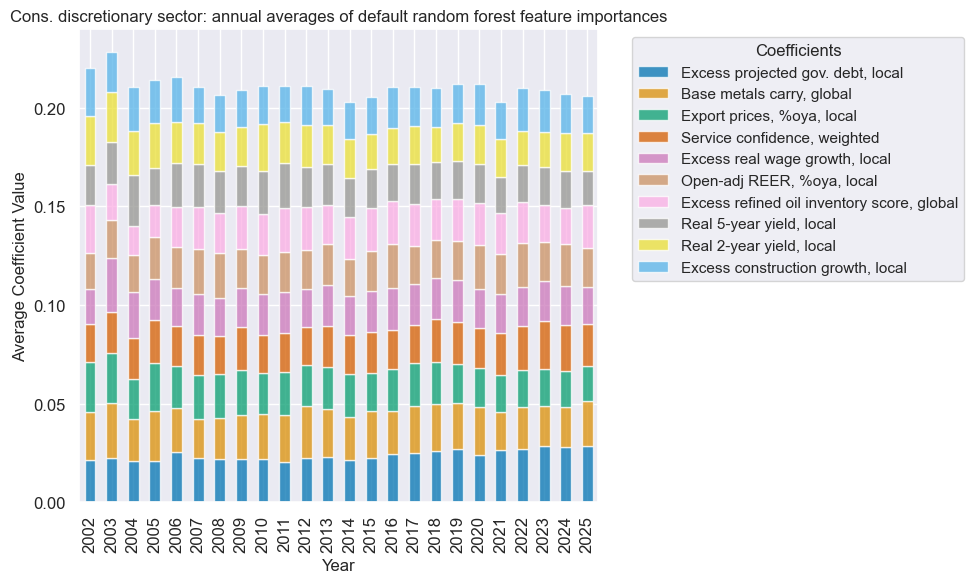

In [178]:
xcatx = cod_dict["signal_name"]
secname = cod_dict["sector_name"]

so_cod.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(cod_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

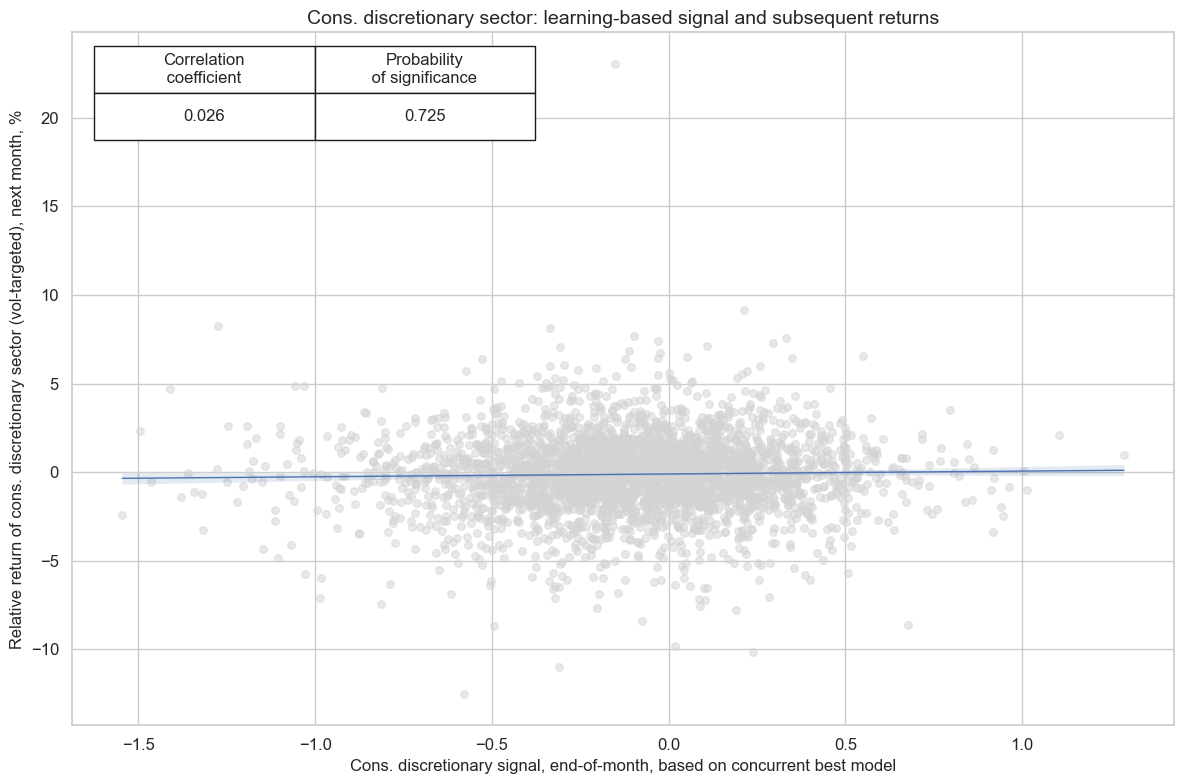

In [179]:
xcatx = [cod_dict["signal_name"], cod_dict["ret"]]
cidx = cod_dict["cidx"]
signal_name = cod_dict["signal_name"]

cr_cod = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=cod_dict["freq"],
    blacklist=cod_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_cod.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

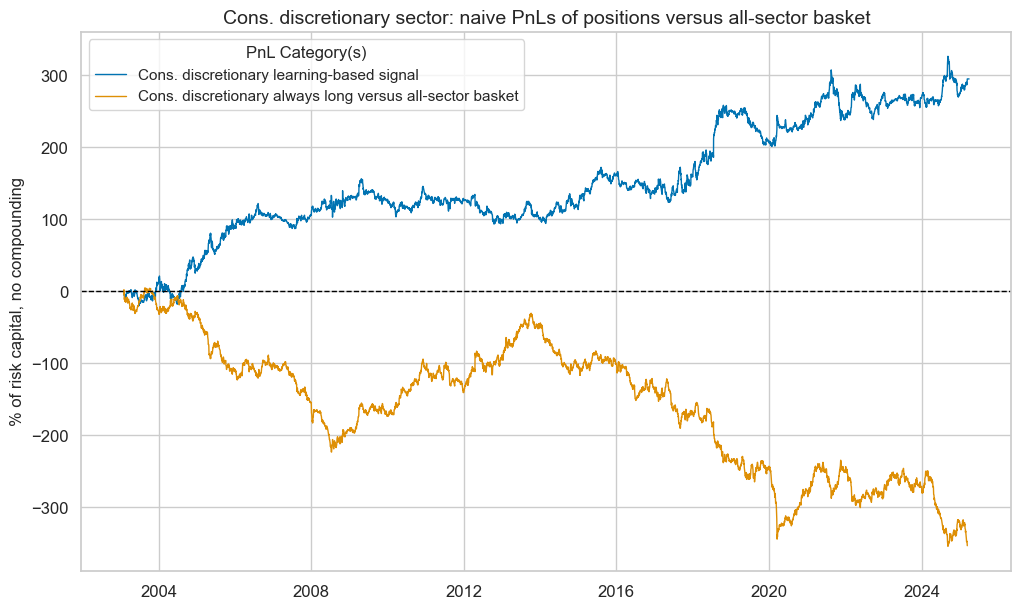

xcat                     Cons. discretionary learning-based signal  \
Return %                                                 13.310832   
St. Dev. %                                               31.809486   
Sharpe Ratio                                              0.418455   
Sortino Ratio                                             0.611507   
Max 21-Day Draw %                                       -36.940937   
Max 6-Month Draw %                                      -58.975361   
Peak to Trough Draw %                                   -70.278802   
Top 5% Monthly PnL Share                                   1.04814   
USD_EQXR_NSA correl                                      -0.006917   
Traded Months                                                  267   

xcat                     Cons. discretionary always long versus all-sector basket  
Return %                                                         -15.978518        
St. Dev. %                                                        31.322219        
Sharpe Ratio                                                      -0.510134        
Sortino Ratio                                                     -0.705453        
Max 21-Day Draw %                                                -68.480798        
Max 6-Month Draw %                                               -96.360886        
Peak to Trough Draw %                                           -358.531109        
Top 5% Monthly PnL Share                                          -0.737259        
USD_EQXR_NSA correl                                                0.095431        
Traded Months                                                           267

In [180]:
xcatx = [cod_dict["signal_name"]]
cidx = cod_dict["cidx"]
secname = cod_dict["sector_name"]
signal_name = cod_dict["signal_name"]
pnl_name = cod_dict["pnl_name"]

pnl_cod = msn.NaivePnL(
    df=dfx,
    ret=cod_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=cod_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_cod.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_cod.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_cod.plot_pnls(
    pnl_cats=pnl_cod.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

cod_dict["pnls"] = pnl_cod
pnl_cod.evaluate_pnls(pnl_cats=pnl_cod.pnl_names)

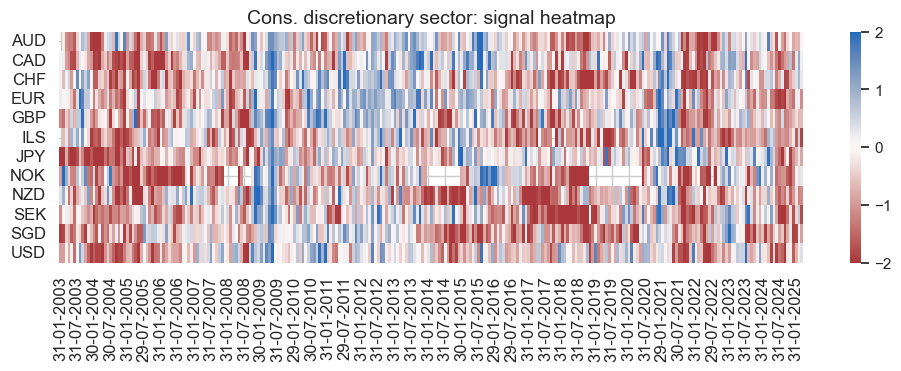

In [181]:
pnl_name = cod_dict["pnl_name"]
secname = cod_dict["sector_name"]

pnl_cod.signal_heatmap(
    pnl_name=f"{secname} learning-based signal",
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Consumer staples

#### Factor selection and signal generation

In [182]:
sector = "COS"

cos_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [183]:
xcatx = cos_dict["xcatx"] + [cos_dict["ret"]]
cidx = cos_dict["cidx"]

so_cos = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=cos_dict["black"],
    freq=cos_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

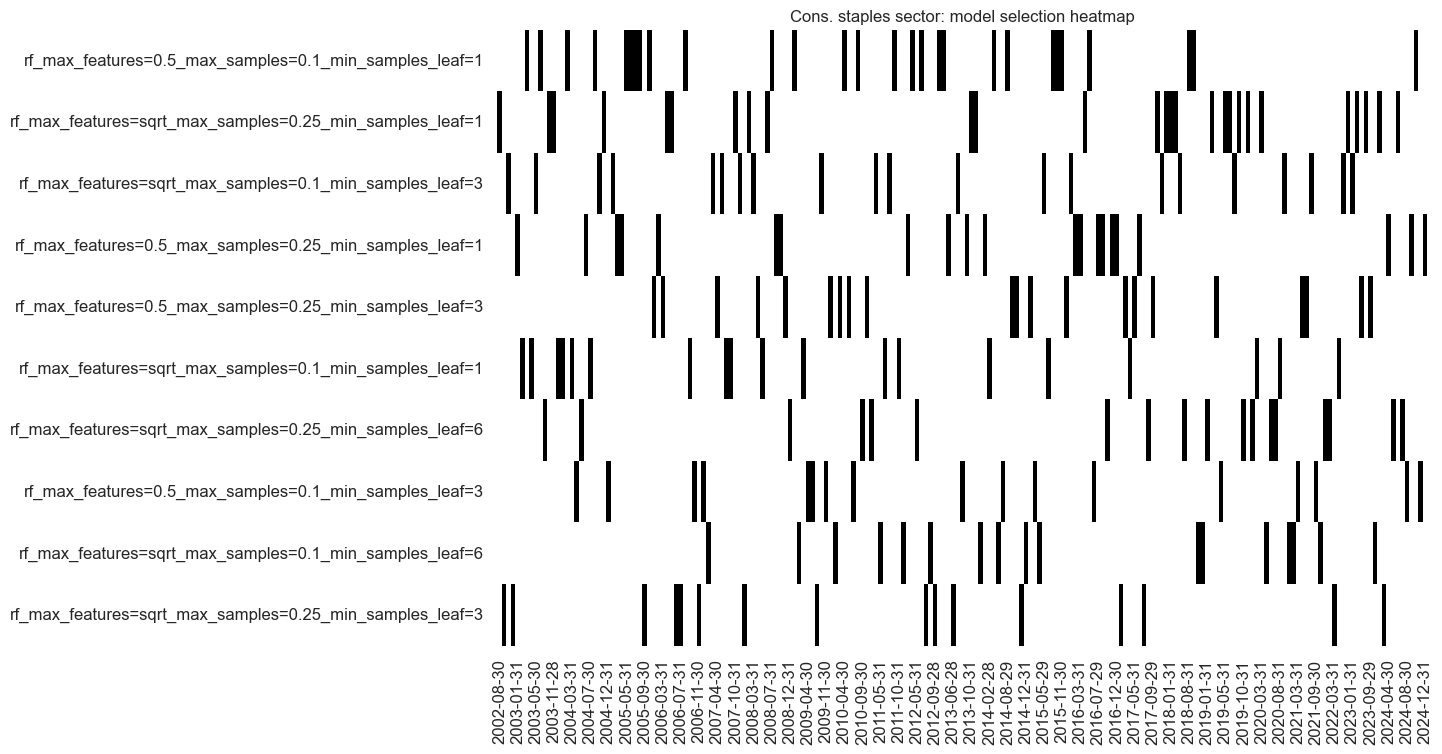

In [184]:
secname = cos_dict["sector_name"]
signal_name = cos_dict["signal_name"]

so_cos.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_cos.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_cos.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [185]:
cos_importances = (
    so_cos.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

cos_importances

BMLCOCRY_SAVT10_21DMA_ZN  CCSCORE_SA_WG_ZN  REEROADJ_NSA_P1M12ML1_ZN  \
count                271.000000        271.000000                271.000000   
mean                   0.030157          0.024069                  0.023923   
min                    0.013596          0.015575                  0.014411   
25%                    0.025807          0.020668                  0.021228   
50%                    0.029968          0.022965                  0.023401   
75%                    0.034097          0.026491                  0.026160   
max                    0.049511          0.044102                  0.052365   
std                    0.006278          0.005038                  0.004585   

       XCPIF_SA_P1M1ML12_WG_ZN  XGGDGDPRATIOX10_NSA_ZN  RYLDIRS02Y_NSA_ZN  \
count               271.000000              271.000000         271.000000   
mean                  0.022014                0.020905           0.020691   
min                   0.011093                0.003462           0.009548   
25%                   0.018115                0.017665           0.016654   
50%                   0.020101                0.021223           0.020174   
75%                   0.024199                0.024560           0.024059   
max                   0.065414                0.038626           0.042761   
std                   0.006757                0.005430           0.005823   

       RYLDIRS05Y_NSA_ZN  XIP_SA_P1M1ML12_3MMA_WG_ZN  \
count         271.000000                  271.000000   
mean            0.020386                    0.019763   
min             0.011545                    0.011905   
25%             0.018259                    0.016571   
50%             0.020438                    0.018308   
75%             0.022173                    0.021438   
max             0.040571                    0.045291   
std             0.003647                    0.005054   

       XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN  SBCSCORE_SA_D3M3ML3_WG_ZN  ...  \
count                        271.000000                 271.000000  ...   
mean                           0.019729                   0.018906  ...   
min                            0.008197                   0.008619  ...   
25%                            0.015770                   0.016757  ...   
50%                            0.017930                   0.019150  ...   
75%                            0.021581                   0.021054  ...   
max                            0.062926                   0.029366  ...   
std                            0.006634                   0.003355  ...   

       UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  INTLIQGDP_NSA_D1M1ML6_ZN  \
count                          271.000000                271.000000   
mean                             0.016139                  0.016108   
min                              0.008253                  0.009533   
25%                              0.013540                  0.013454   
50%                              0.015510                  0.015275   
75%                              0.018204                  0.018512   
max                              0.035063                  0.026862   
std                              0.003841                  0.003531   

       XRPCONS_SA_P1M1ML12_3MMA_ZN  XPPIH_NSA_P1M1ML12_ZN  \
count                   271.000000             271.000000   
mean                      0.016090               0.016060   
min                       0.007149               0.007429   
25%                       0.014459               0.014369   
50%                       0.016031               0.016081   
75%                       0.017752               0.017601   
max                       0.028448               0.031605   
std                       0.002808               0.002854   

       XEMPL_NSA_P1M1ML12_3MMA_ZN  XRPCONS_SA_P1M1ML12_3MMA_WG_ZN  \
count                  271.000000                      271.000000   
mean                     0.015942                        0.015932   
min                    

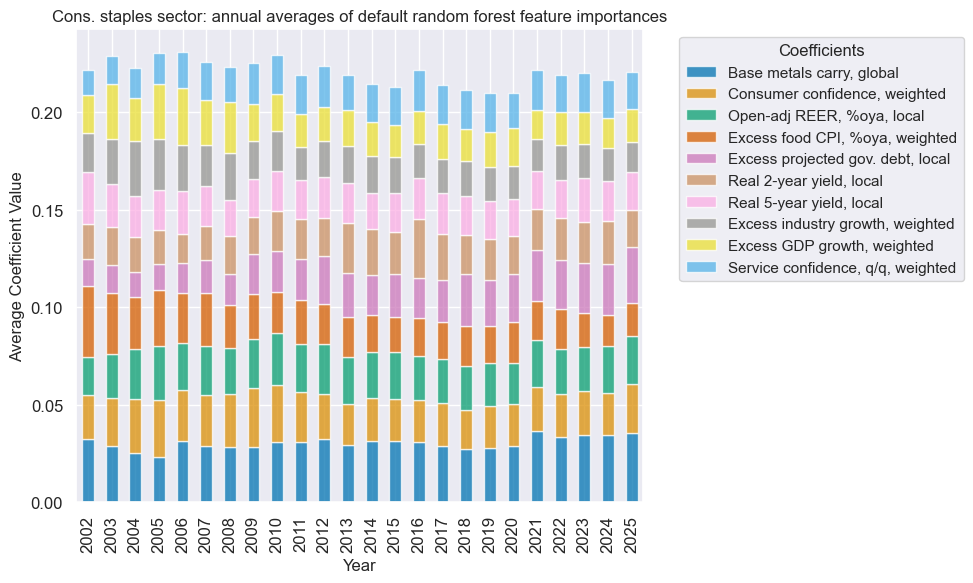

In [186]:
xcatx = cos_dict["signal_name"]
secname = cos_dict["sector_name"]

so_cos.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(cos_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

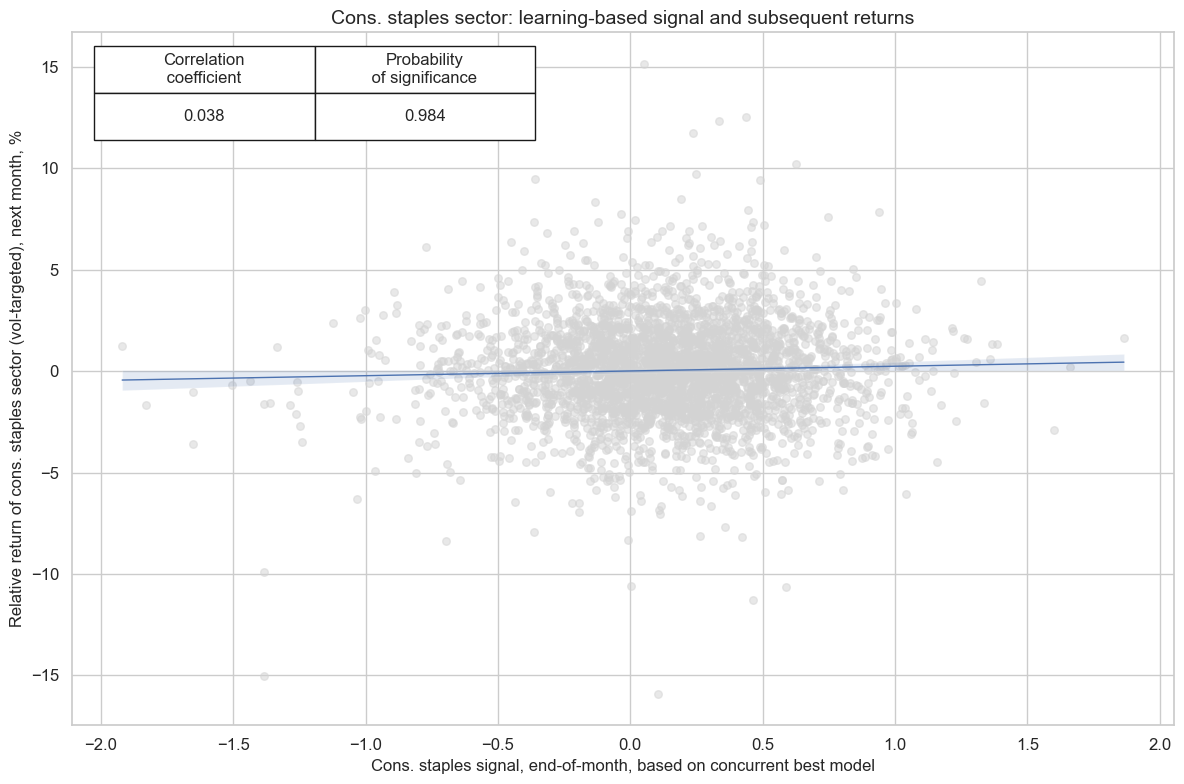

In [187]:
xcatx = [cos_dict["signal_name"], cos_dict["ret"]]
cidx = cos_dict["cidx"]
secname = cos_dict["sector_name"]

cr_cos = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=cos_dict["freq"],
    blacklist=cos_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_cos.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

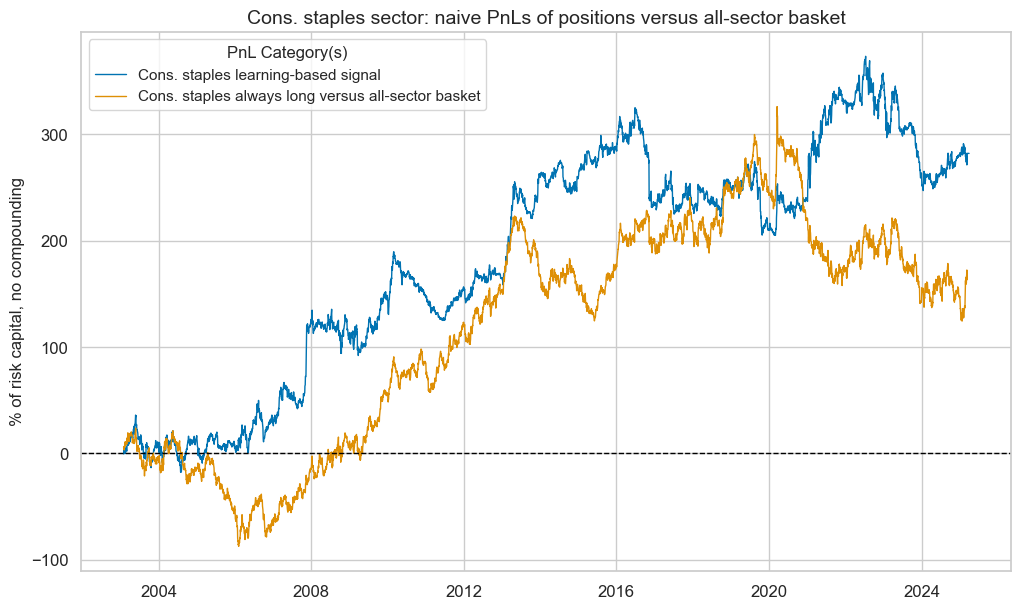

xcat                     Cons. staples learning-based signal  \
Return %                                           12.729819   
St. Dev. %                                         37.829007   
Sharpe Ratio                                        0.336509   
Sortino Ratio                                       0.478747   
Max 21-Day Draw %                                 -52.720556   
Max 6-Month Draw %                                -90.375119   
Peak to Trough Draw %                             -126.18286   
Top 5% Monthly PnL Share                            1.438746   
USD_EQXR_NSA correl                                -0.064439   
Traded Months                                            267   

xcat                     Cons. staples always long versus all-sector basket  
Return %                                                           7.386778  
St. Dev. %                                                        37.762289  
Sharpe Ratio                                                       0.195613  
Sortino Ratio                                                      0.281357  
Max 21-Day Draw %                                                -33.681565  
Max 6-Month Draw %                                               -93.828486  
Peak to Trough Draw %                                           -201.569822  
Top 5% Monthly PnL Share                                           2.354328  
USD_EQXR_NSA correl                                               -0.138678  
Traded Months                                                           267

In [188]:
xcatx = [cos_dict["signal_name"]]
cidx = cos_dict["cidx"]
secname = cos_dict["sector_name"]
signal_name = cos_dict["signal_name"]
pnl_name = cos_dict["pnl_name"]

pnl_cos = msn.NaivePnL(
    df=dfx,
    ret=cos_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=cos_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_cos.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_cos.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_cos.plot_pnls(
    pnl_cats=pnl_cos.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

cos_dict["pnls"] = pnl_cos
pnl_cos.evaluate_pnls(pnl_cats=pnl_cos.pnl_names)

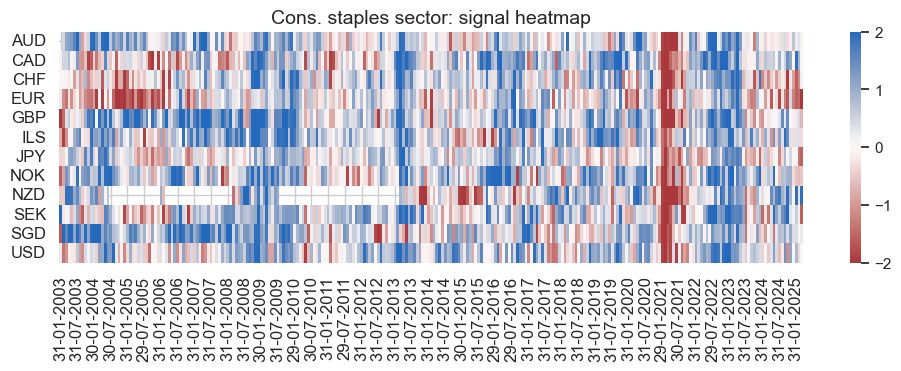

In [189]:
pnl_name = cos_dict["pnl_name"]
secname = cos_dict["sector_name"]

pnl_cos.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Healthcare

#### Factor selection and signal generation

In [190]:
sector = "HLC"

hlc_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [191]:
xcatx = hlc_dict["xcatx"] + [hlc_dict["ret"]]
cidx = hlc_dict["cidx"]

so_hlc = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=hlc_dict["black"],
    freq=hlc_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

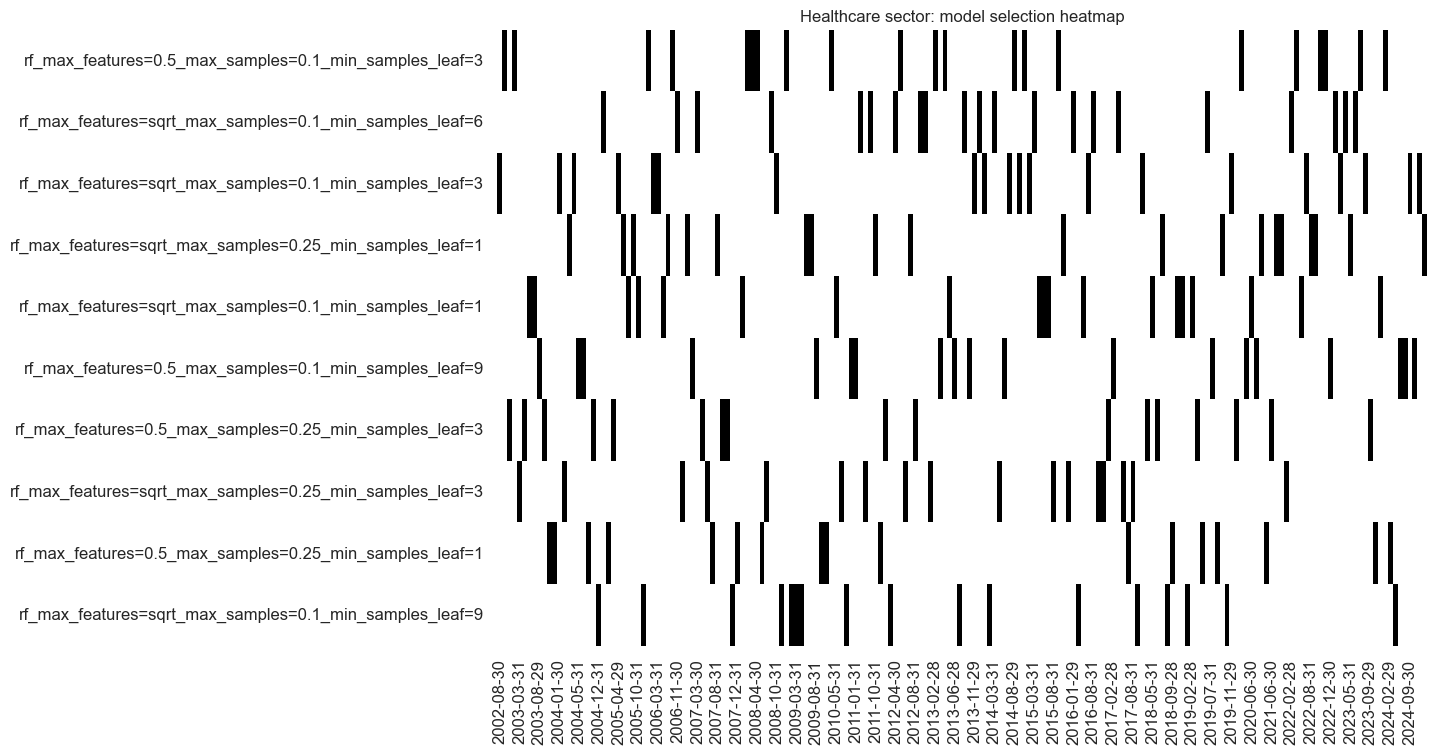

In [192]:
secname = hlc_dict["sector_name"]
signal_name = hlc_dict["signal_name"]

so_hlc.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_hlc.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_hlc.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [193]:
hlc_importances = (
    so_hlc.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

hlc_importances

BMLCOCRY_SAVT10_21DMA_ZN  XRWAGES_NSA_P1M1ML12_ZN  \
count                271.000000               271.000000   
mean                   0.028836                 0.022154   
min                    0.010444                 0.011627   
25%                    0.023714                 0.019355   
50%                    0.026868                 0.021686   
75%                    0.031702                 0.023954   
max                    0.069668                 0.051637   
std                    0.008301                 0.004621   

       REFIXINVCSCORE_SA_ZN  XCPIC_SA_P1M1ML12_ZN  XGGDGDPRATIOX10_NSA_ZN  \
count            271.000000            271.000000              271.000000   
mean               0.021328              0.021144                0.021050   
min                0.000000              0.001824                0.005830   
25%                0.017098              0.018512                0.018416   
50%                0.021552              0.020574                0.020974   
75%                0.024864              0.023787                0.023622   
max                0.038789              0.034993                0.035036   
std                0.006325              0.004370                0.004210   

       BMLXINVCSCORE_SA_ZN  REEROADJ_NSA_P1M12ML1_ZN  XCPIF_SA_P1M1ML12_WG_ZN  \
count           271.000000                271.000000               271.000000   
mean              0.019896                  0.019867                 0.019775   
min               0.005647                  0.006950                 0.010341   
25%               0.016864                  0.017720                 0.017549   
50%               0.020205                  0.019845                 0.019464   
75%               0.023262                  0.021969                 0.021538   
max               0.031932                  0.030898                 0.039004   
std               0.005067                  0.003405                 0.003782   

       INTLIQGDP_NSA_D1M1ML6_ZN  XCSTR_SA_P1M1ML12_3MMA_ZN  ...  \
count                271.000000                 271.000000  ...   
mean                   0.019761                   0.019534  ...   
min                    0.006135                   0.010893  ...   
25%                    0.014760                   0.017126  ...   
50%                    0.017453                   0.019279  ...   
75%                    0.023129                   0.021409  ...   
max                    0.057846                   0.040786  ...   
std                    0.007294                   0.004089  ...   

       XPCREDITBN_SJA_P1M1ML12_WG_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_ZN  \
count                     271.000000                     271.000000   
mean                        0.015664                       0.015538   
min                         0.004780                       0.003910   
25%                         0.013829                       0.013552   
50%                         0.015973                       0.015623   
75%                         0.017566                       0.017730   
max                         0.028892                       0.028128   
std                         0.003141                       0.003377   

       XEMPL_NSA_P1M1ML12_3MMA_ZN  UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  \
count                  271.000000                          271.000000   
mean                     0.015405                            0.015398   
min                      0.003051                            0.004595   
25%                      0.013630                            0.013150   
50%                      0.015585                            0.014772   
75%                      0.017440                            0.017121   
max                      0.024407                            0.035665   
std                      0.003157                            0.003827   

       UNEMPLRATE_SA_3MMAv5YMA_WG_ZN  XEMPL_NSA_P1M1ML12_3MMA_WG_ZN  \
count                     271.000000                     271.000000  

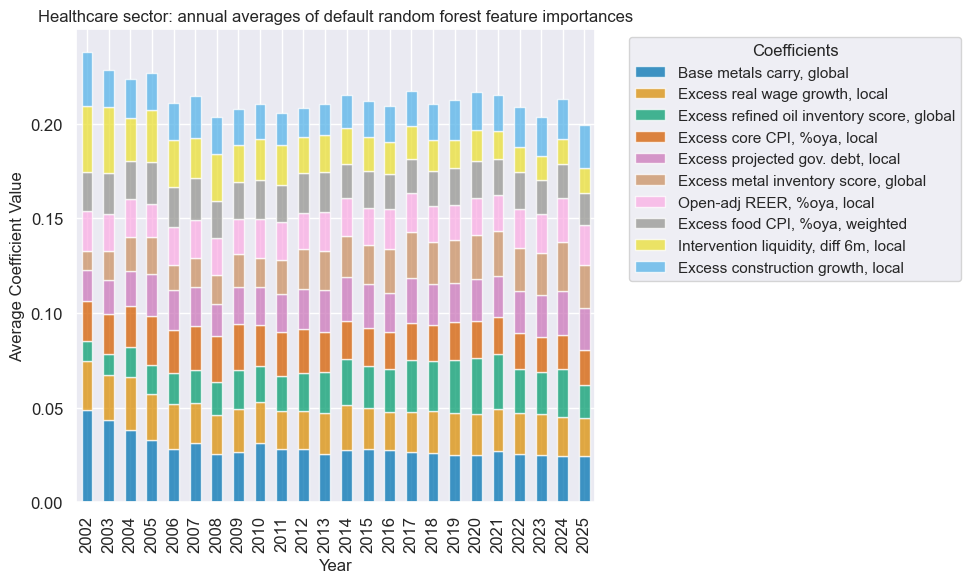

In [194]:
xcatx = hlc_dict["signal_name"]
secname = hlc_dict["sector_name"]

so_hlc.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(hlc_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

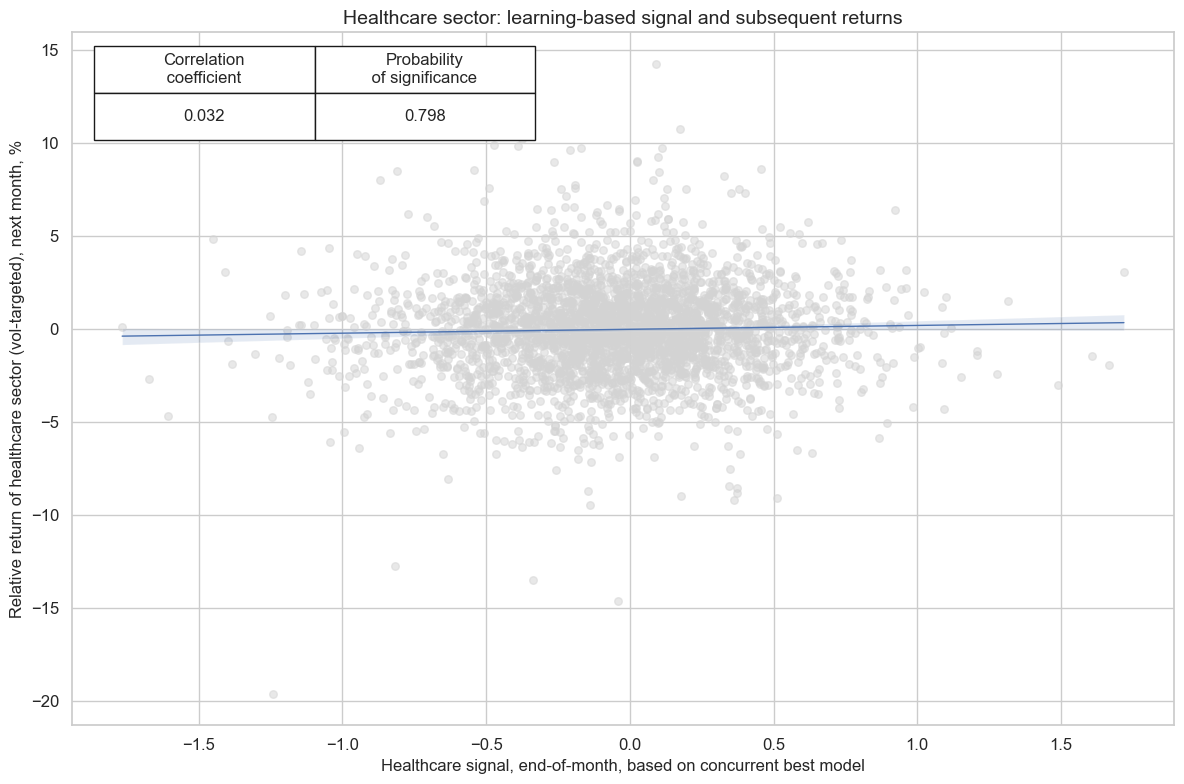

In [195]:
xcatx = [hlc_dict["signal_name"], hlc_dict["ret"]]
cidx = hlc_dict["cidx"]
secname = hlc_dict["sector_name"]

cr_hlc = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=hlc_dict["freq"],
    blacklist=hlc_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_hlc.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

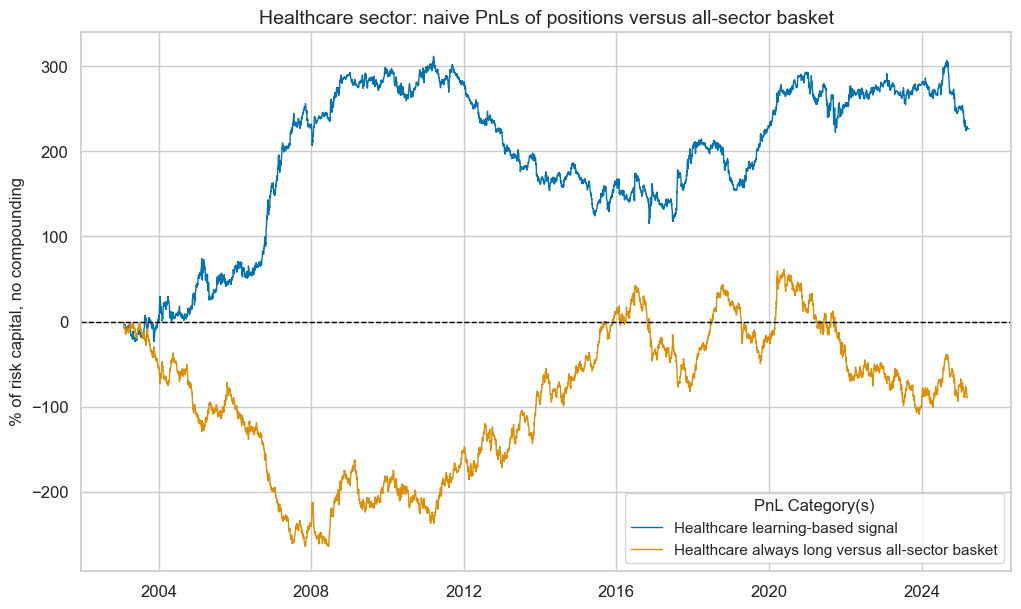

xcat                     Healthcare learning-based signal  \
Return %                                        10.222537   
St. Dev. %                                      36.745511   
Sharpe Ratio                                     0.278198   
Sortino Ratio                                    0.398907   
Max 21-Day Draw %                              -40.391137   
Max 6-Month Draw %                             -82.460974   
Peak to Trough Draw %                         -196.363809   
Top 5% Monthly PnL Share                         1.461796   
USD_EQXR_NSA correl                              0.025846   
Traded Months                                         267   

xcat                     Healthcare always long versus all-sector basket  
Return %                                                       -4.044239  
St. Dev. %                                                      38.50816  
Sharpe Ratio                                                   -0.105023  
Sortino Ratio                                                  -0.150517  
Max 21-Day Draw %                                             -47.409795  
Max 6-Month Draw %                                            -93.207315  
Peak to Trough Draw %                                        -262.724098  
Top 5% Monthly PnL Share                                       -4.156891  
USD_EQXR_NSA correl                                            -0.159044  
Traded Months                                                        267

In [196]:
xcatx = [hlc_dict["signal_name"]]
cidx = hlc_dict["cidx"]
secname = hlc_dict["sector_name"]
signal_name = hlc_dict["signal_name"]
pnl_name = hlc_dict["pnl_name"]

pnl_hlc = msn.NaivePnL(
    df=dfx,
    ret=hlc_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=hlc_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_hlc.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_hlc.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_hlc.plot_pnls(
    pnl_cats=pnl_hlc.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

hlc_dict["pnls"] = pnl_hlc
pnl_hlc.evaluate_pnls(pnl_cats=pnl_hlc.pnl_names)

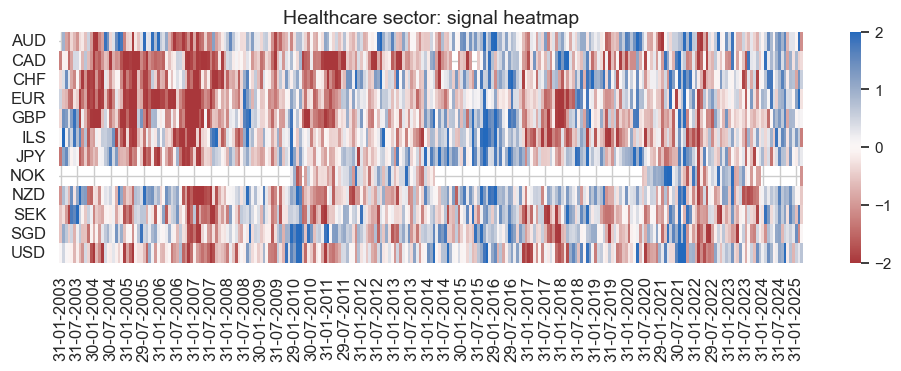

In [197]:
pnl_name = hlc_dict["pnl_name"]
secname = hlc_dict["sector_name"]

pnl_hlc.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Financials

#### Factor selection and signal generation

In [198]:
sector = "FIN"

fin_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [199]:
xcatx = fin_dict["xcatx"] + [fin_dict["ret"]]
cidx = fin_dict["cidx"]

so_fin = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=fin_dict["black"],
    freq=fin_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

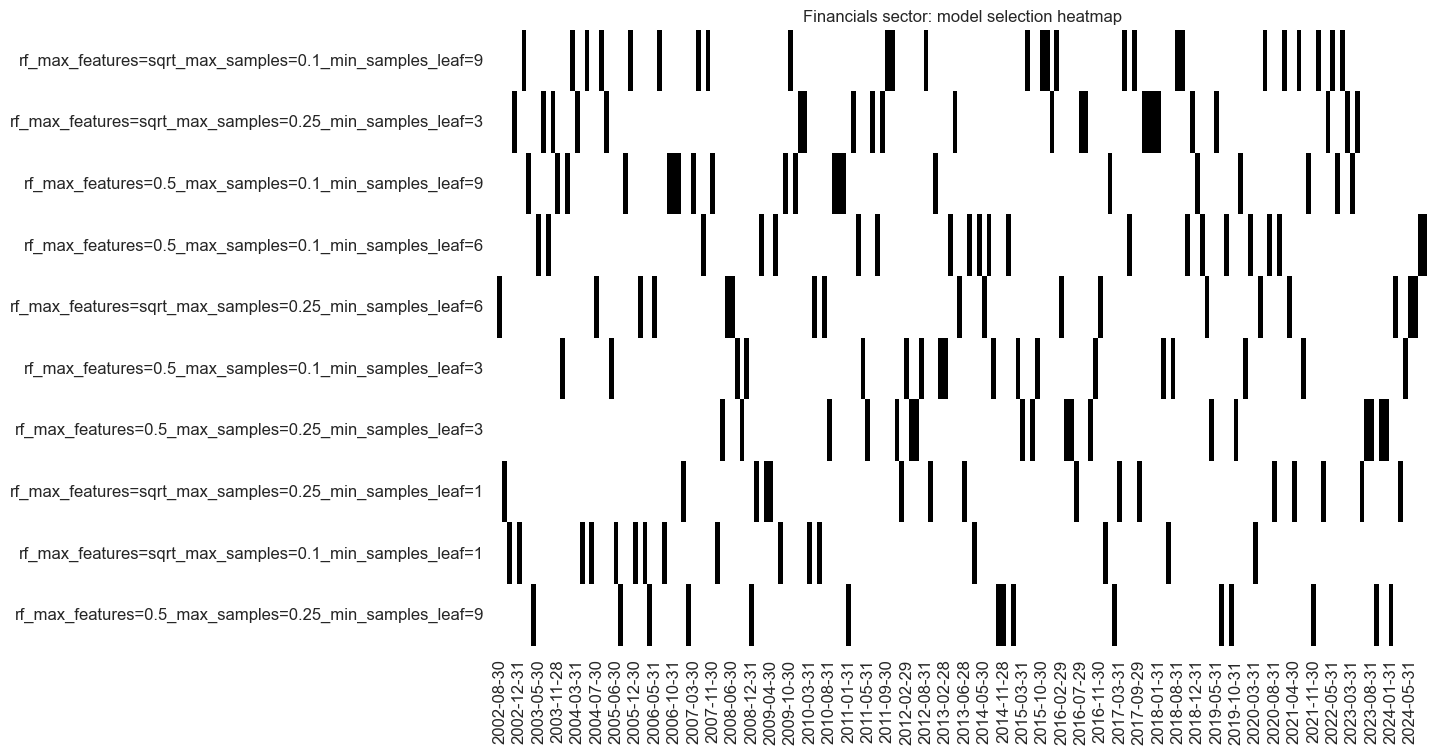

In [200]:
secname = fin_dict["sector_name"]
signal_name = fin_dict["signal_name"]

so_fin.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_fin.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_fin.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [201]:
fin_importances = (
    so_fin.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

fin_importances

BMLCOCRY_SAVT10_21DMA_ZN  XGGDGDPRATIOX10_NSA_ZN  \
count                271.000000              271.000000   
mean                   0.033372                0.025287   
min                    0.010865                0.004436   
25%                    0.027656                0.021381   
50%                    0.031273                0.023962   
75%                    0.037369                0.027731   
max                    0.077338                0.055350   
std                    0.009122                0.006131   

       REEROADJ_NSA_P1M12ML1_ZN  REFIXINVCSCORE_SA_ZN  CCSCORE_SA_ZN  \
count                271.000000            271.000000     271.000000   
mean                   0.023579              0.023166       0.021470   
min                    0.009034              0.003472       0.005645   
25%                    0.019419              0.017802       0.018313   
50%                    0.021537              0.023353       0.021124   
75%                    0.025729              0.027977       0.024535   
max                    0.060381              0.038759       0.036812   
std                    0.007212              0.007033       0.005216   

       XNRSALES_SA_P1M1ML12_3MMA_ZN  CXPI_NSA_P1M12ML1_ZN  \
count                    271.000000            271.000000   
mean                       0.021100              0.020746   
min                        0.006083              0.006847   
25%                        0.018005              0.018185   
50%                        0.020685              0.020399   
75%                        0.023980              0.023038   
max                        0.043096              0.037422   
std                        0.004871              0.004253   

       XRRSALES_SA_P1M1ML12_3MMA_WG_ZN  XCPIC_SA_P1M1ML12_ZN  \
count                       271.000000            271.000000   
mean                          0.020217              0.020046   
min                           0.005977              0.000000   
25%                           0.017301              0.017408   
50%                           0.019593              0.019095   
75%                           0.022346              0.021670   
max                           0.060037              0.037514   
std                           0.004962              0.004339   

       RYLDIRS05Y_NSA_ZN  ...  XRPCONS_SA_P1M1ML12_3MMA_ZN  \
count         271.000000  ...                   271.000000   
mean            0.019836  ...                     0.015416   
min             0.005035  ...                     0.004102   
25%             0.016759  ...                     0.013452   
50%             0.019420  ...                     0.015217   
75%             0.022126  ...                     0.017081   
max             0.045437  ...                     0.036349   
std             0.005024  ...                     0.003325   

       UNEMPLRATE_SA_3MMAv5YMA_WG_ZN  RIR_NSA_ZN  \
count                     271.000000  271.000000   
mean                        0.015063    0.015060   
min                         0.002416    0.004604   
25%                         0.013413    0.012890   
50%                         0.015100    0.015275   
75%                         0.016805    0.017201   
max                         0.025588    0.026185   
std                         0.003413    0.003587   

       XRGDPTECH_SA_P1M1ML12_3MMA_ZN  UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  \
count                     271.000000                          271.000000   
mean                        0.015057                            0.014955   
min                         0.003904                            0.000000   
25%                         0.013293                            0.012199   
50%                         0.014994                            0.014086   
75%                         0.016782                            0.017015   
max                         0.030416                            0.039819   
std                         0.003272                           

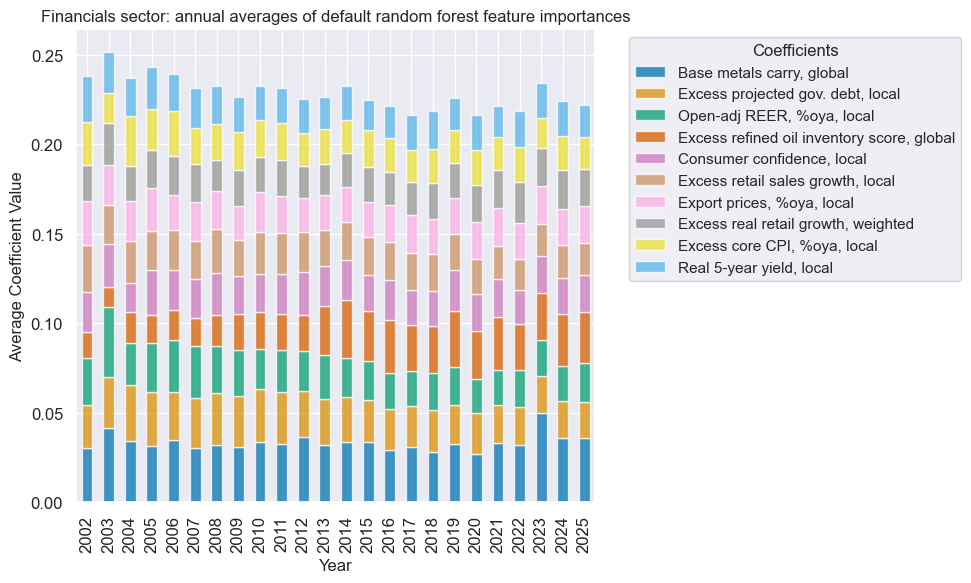

In [202]:
xcatx = fin_dict["signal_name"]
secname = fin_dict["sector_name"]

so_fin.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(fin_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

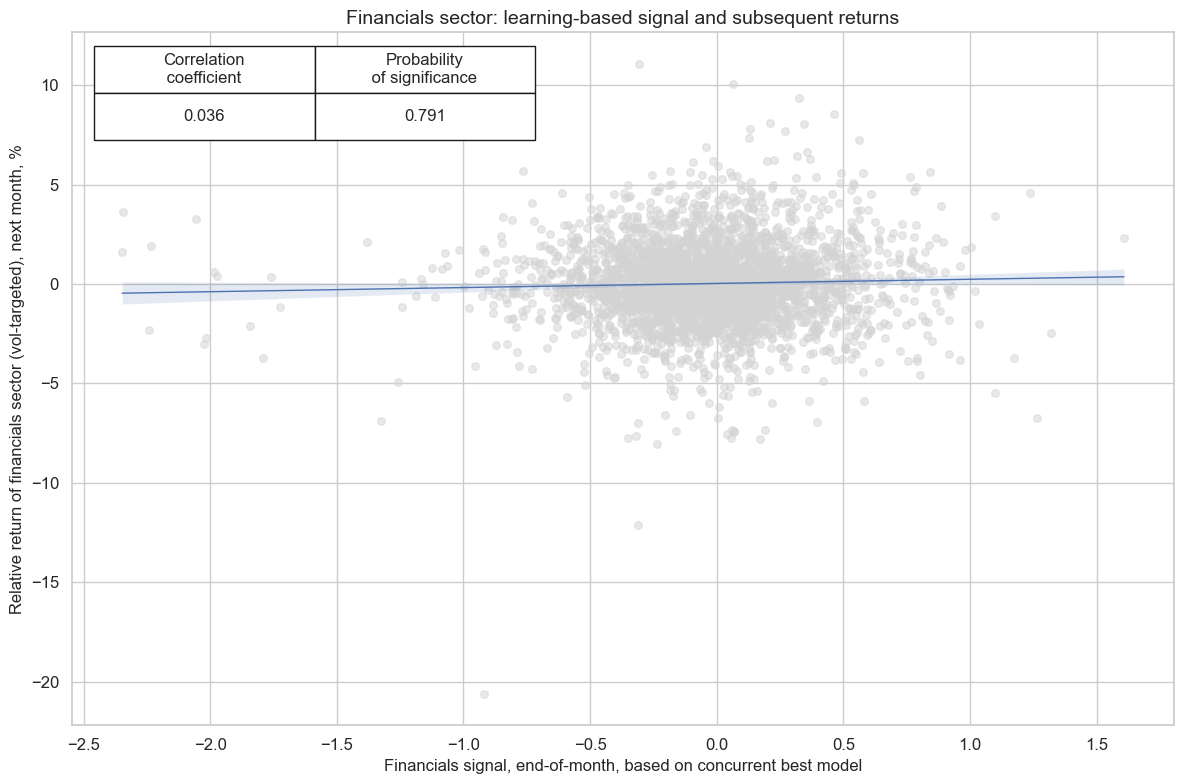

In [203]:
xcatx = [fin_dict["signal_name"], fin_dict["ret"]]
cidx = fin_dict["cidx"]
secname = fin_dict["sector_name"]

cr_fin = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=fin_dict["freq"],
    blacklist=fin_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_fin.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

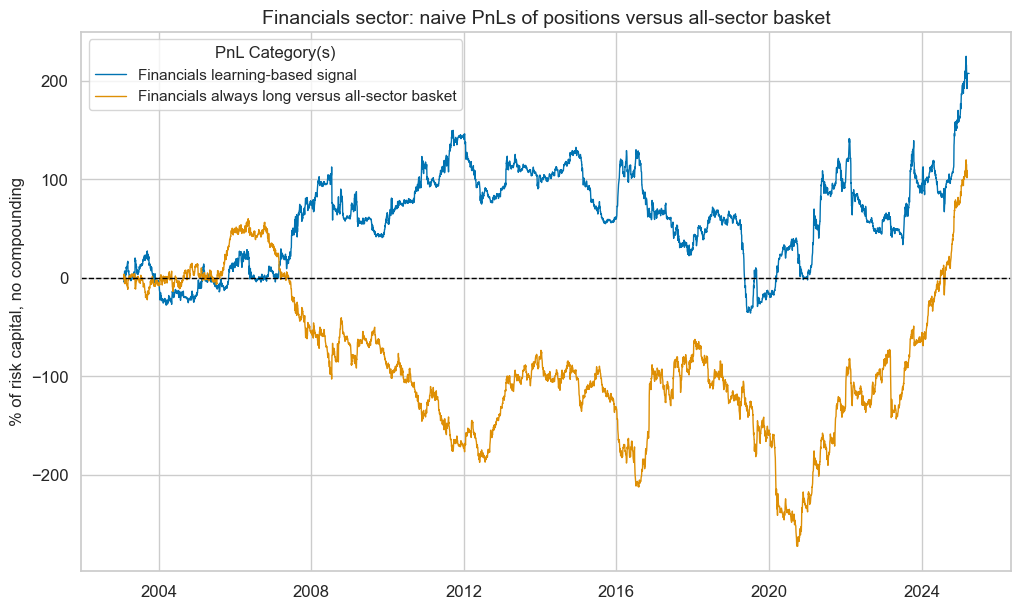

xcat                     Financials learning-based signal  \
Return %                                         9.365027   
St. Dev. %                                      37.156358   
Sharpe Ratio                                     0.252044   
Sortino Ratio                                    0.354122   
Max 21-Day Draw %                              -73.040887   
Max 6-Month Draw %                            -102.512582   
Peak to Trough Draw %                         -185.572225   
Top 5% Monthly PnL Share                         2.115025   
USD_EQXR_NSA correl                             -0.062463   
Traded Months                                         267   

xcat                     Financials always long versus all-sector basket  
Return %                                                        4.921724  
St. Dev. %                                                     38.288158  
Sharpe Ratio                                                    0.128544  
Sortino Ratio                                                   0.187923  
Max 21-Day Draw %                                             -76.126375  
Max 6-Month Draw %                                            -96.122679  
Peak to Trough Draw %                                        -332.744644  
Top 5% Monthly PnL Share                                        3.978115  
USD_EQXR_NSA correl                                             0.220494  
Traded Months                                                        267

In [204]:
xcatx = [fin_dict["signal_name"]]
cidx = fin_dict["cidx"]
secname = fin_dict["sector_name"]
signal_name = fin_dict["signal_name"]
pnl_name = fin_dict["pnl_name"]

pnl_fin = msn.NaivePnL(
    df=dfx,
    ret=fin_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=fin_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_fin.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_fin.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_fin.plot_pnls(
    pnl_cats=pnl_fin.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

fin_dict["pnls"] = pnl_fin
pnl_fin.evaluate_pnls(pnl_cats=pnl_fin.pnl_names)

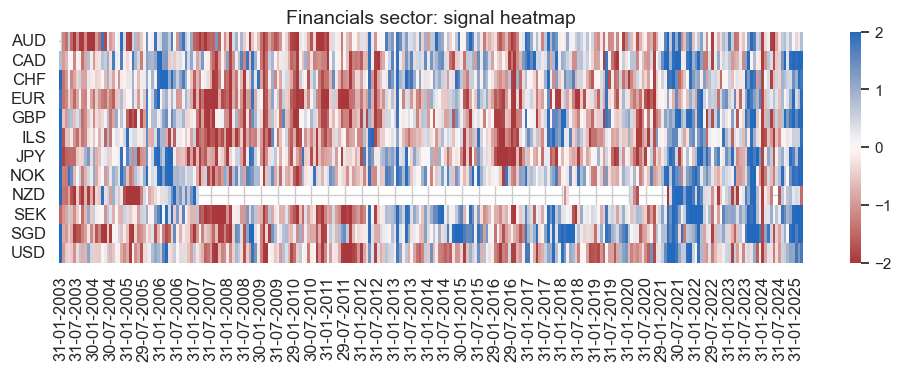

In [205]:
xcatx = fin_dict["signal_name"]
pnl_name = fin_dict["pnl_name"]
secname = fin_dict["sector_name"]

pnl_fin.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Technology

#### Factor selection and signal generation

In [206]:
sector = "ITE"

ite_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [207]:
xcatx = ite_dict["xcatx"] + [ite_dict["ret"]]
cidx = ite_dict["cidx"]

so_ite = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=ite_dict["black"],
    freq=ite_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

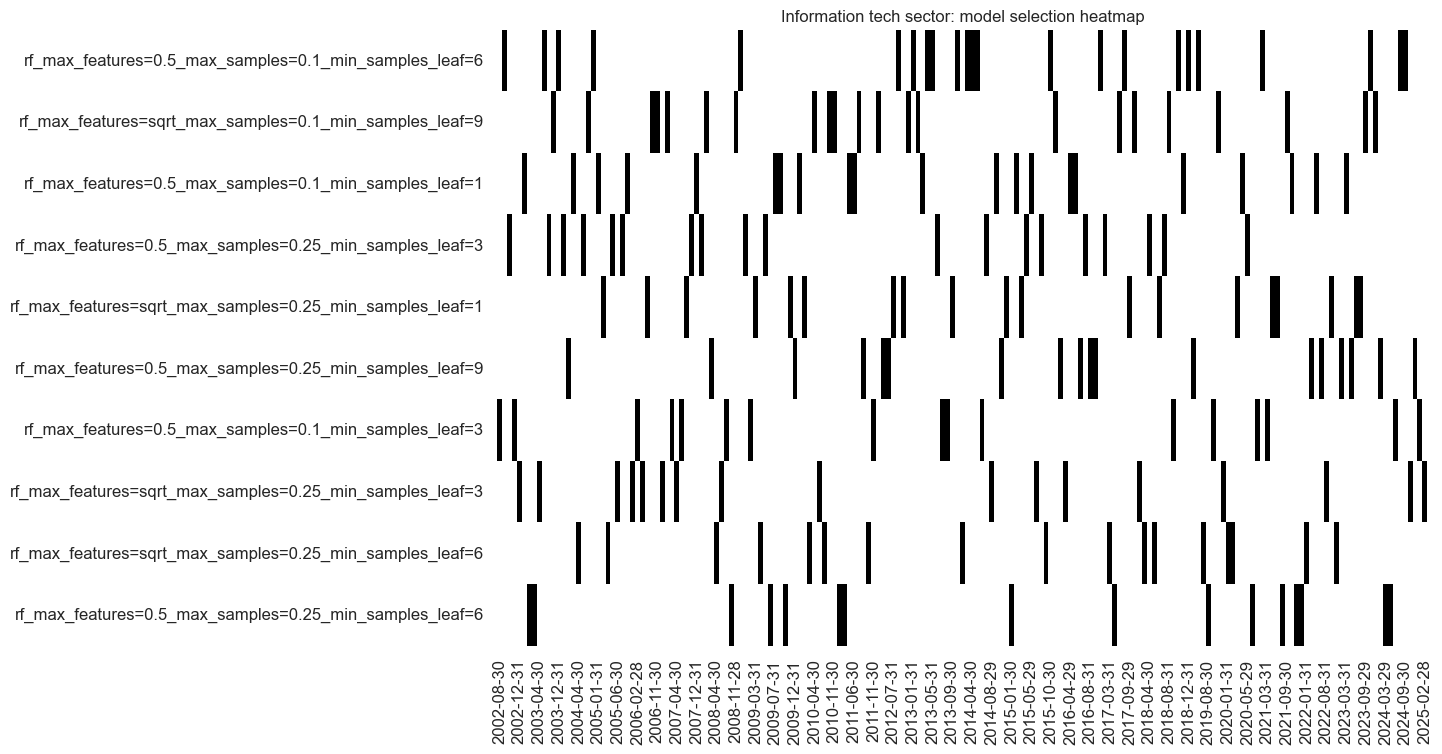

In [208]:
secname = ite_dict["sector_name"]
signal_name = ite_dict["signal_name"]

so_ite.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_ite.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_ite.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [209]:
ite_importances = (
    so_ite.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

ite_importances

CCSCORE_SA_WG_ZN  CCSCORE_SA_ZN  BASEXINVCSCORE_SA_ZN  \
count        271.000000     271.000000            271.000000   
mean           0.030261       0.024013              0.023329   
min            0.001367       0.008941              0.003188   
25%            0.023197       0.019194              0.020209   
50%            0.027825       0.022868              0.023367   
75%            0.034228       0.027893              0.026217   
max            0.084165       0.056244              0.041380   
std            0.010217       0.006499              0.005452   

       RYLDIRS05Y_NSA_ZN  XCPIC_SA_P1M1ML12_ZN  BMLCOCRY_SAVT10_21DMA_ZN  \
count         271.000000            271.000000                271.000000   
mean            0.022619              0.021590                  0.021239   
min             0.008631              0.000000                  0.007969   
25%             0.017678              0.019226                  0.018037   
50%             0.021071              0.021651                  0.020599   
75%             0.024486              0.023901                  0.023165   
max             0.077280              0.034307                  0.069902   
std             0.008363              0.004174                  0.006465   

       XRWAGES_NSA_P1M1ML12_ZN  CCSCORE_SA_D3M3ML3_ZN  \
count               271.000000             271.000000   
mean                  0.020491               0.020355   
min                   0.001486               0.011236   
25%                   0.017841               0.017503   
50%                   0.020715               0.019846   
75%                   0.023632               0.022112   
max                   0.033888               0.048929   
std                   0.004914               0.004525   

       XCSTR_SA_P1M1ML12_3MMA_ZN  RYLDIRS02Y_NSA_ZN  ...  \
count                 271.000000         271.000000  ...   
mean                    0.020341           0.020250  ...   
min                     0.003893           0.006764  ...   
25%                     0.018101           0.016691  ...   
50%                     0.020271           0.020051  ...   
75%                     0.022773           0.023418  ...   
max                     0.044928           0.055986  ...   
std                     0.004095           0.006028  ...   

       XRPCONS_SA_P1M1ML12_3MMA_ZN  UNEMPLRATE_NSA_3MMA_D1M1ML12_ZN  \
count                   271.000000                       271.000000   
mean                      0.015429                         0.015360   
min                       0.002832                         0.002292   
25%                       0.013621                         0.013347   
50%                       0.015666                         0.015124   
75%                       0.017126                         0.016941   
max                       0.026680                         0.044387   
std                       0.003263                         0.004046   

       XPCREDITBN_SJA_P1M1ML12_WG_ZN  CMPI_NSA_P1M12ML1_ZN  \
count                     271.000000            271.000000   
mean                        0.015276              0.015233   
min                         0.000000              0.003810   
25%                         0.013101              0.013465   
50%                         0.015139              0.015402   
75%                         0.017525              0.017263   
max                         0.029174              0.040348   
std                         0.003689              0.003768   

       XEMPL_NSA_P1M1ML12_3MMA_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN  \
count                  271.000000                        271.000000   
mean                     0.014980                          0.014925   
min                      0.003766                          0.000000   
25%                      0.012837                          0.012859   
50%                      0.015002                          0.014911   
75%                      0.016794                          0.0169

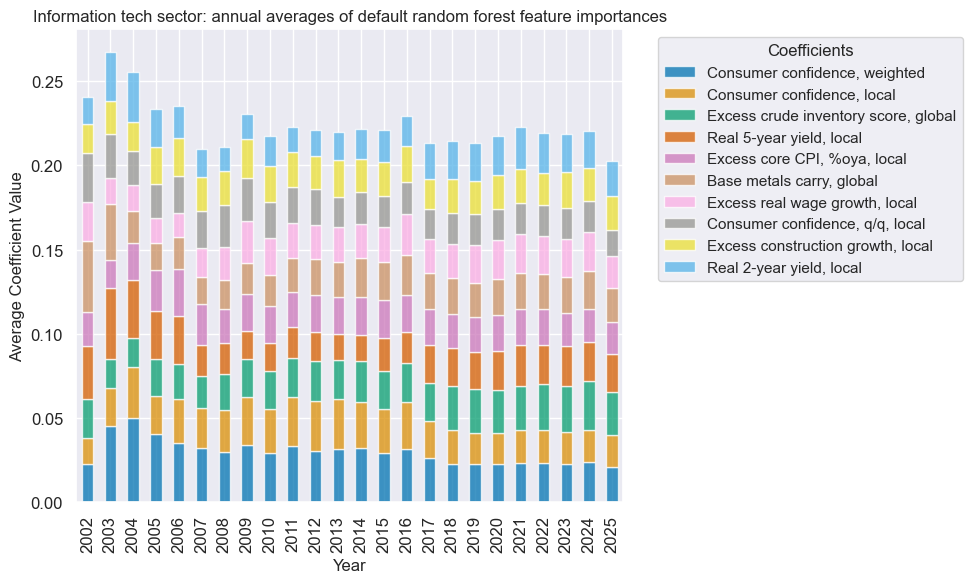

In [210]:
xcatx = ite_dict["signal_name"]
secname = ite_dict["sector_name"]

so_ite.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(ite_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

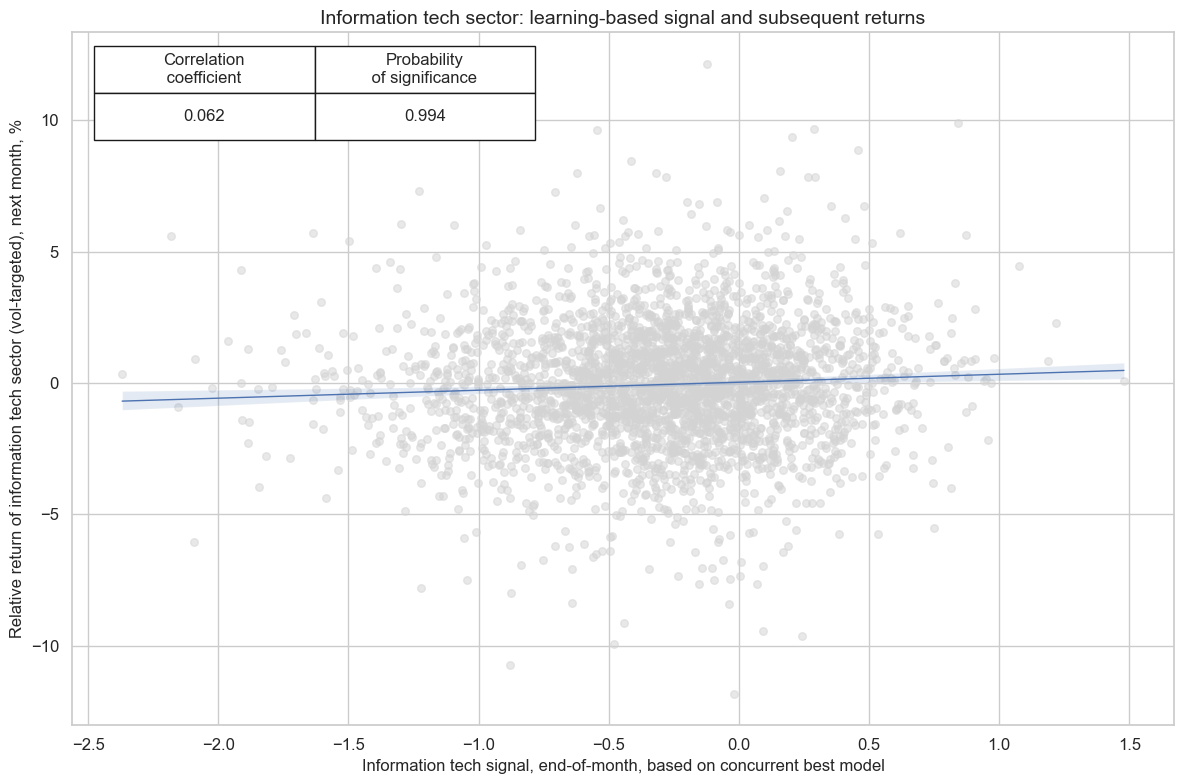

In [211]:
xcatx = [ite_dict["signal_name"], ite_dict["ret"]]
cidx = ite_dict["cidx"]
secname = ite_dict["sector_name"]

cr_ite = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=ite_dict["freq"],
    blacklist=ite_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_ite.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

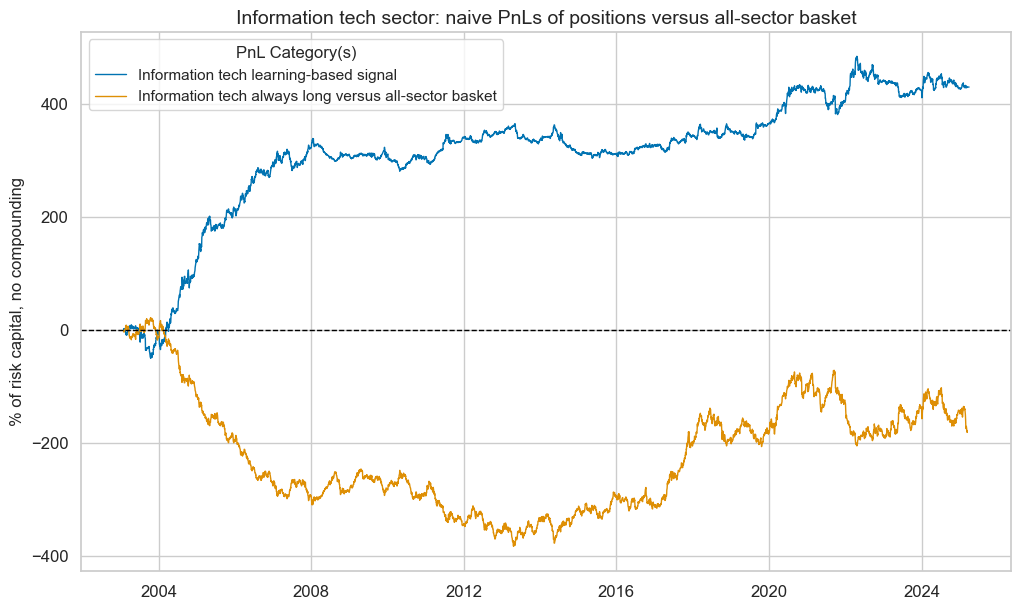

xcat                     Information tech learning-based signal  \
Return %                                              19.387719   
St. Dev. %                                            29.531038   
Sharpe Ratio                                            0.65652   
Sortino Ratio                                          0.947428   
Max 21-Day Draw %                                    -33.439709   
Max 6-Month Draw %                                   -55.095888   
Peak to Trough Draw %                                -73.379864   
Top 5% Monthly PnL Share                               0.801098   
USD_EQXR_NSA correl                                   -0.010929   
Traded Months                                               267   

xcat                     Information tech always long versus all-sector basket  
Return %                                                          -8.140115     
St. Dev. %                                                        37.685315     
Sharpe Ratio                                                      -0.216002     
Sortino Ratio                                                     -0.298073     
Max 21-Day Draw %                                                -44.700924     
Max 6-Month Draw %                                              -116.166222     
Peak to Trough Draw %                                           -404.663283     
Top 5% Monthly PnL Share                                          -2.012503     
USD_EQXR_NSA correl                                                0.034275     
Traded Months                                                           267

In [212]:
xcatx = [ite_dict["signal_name"]]
cidx = ite_dict["cidx"]
secname = ite_dict["sector_name"]
signal_name = ite_dict["signal_name"]
pnl_name = ite_dict["pnl_name"]

pnl_ite = msn.NaivePnL(
    df=dfx,
    ret=ite_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=ite_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_ite.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_ite.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_ite.plot_pnls(
    pnl_cats=pnl_ite.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

ite_dict["pnls"] = pnl_ite
pnl_ite.evaluate_pnls(pnl_cats=pnl_ite.pnl_names)

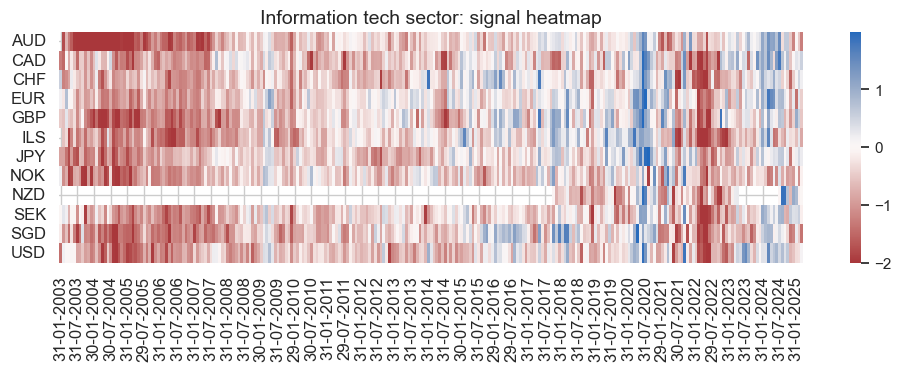

In [213]:
pnl_name = ite_dict["pnl_name"]
secname = ite_dict["sector_name"]

pnl_ite.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Communication

#### Factor selection and signal generation

In [214]:
sector = "CSR"

csr_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [215]:
xcatx = csr_dict["xcatx"] + [csr_dict["ret"]]
cidx = csr_dict["cidx"]

so_csr = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=csr_dict["black"],
    freq=csr_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

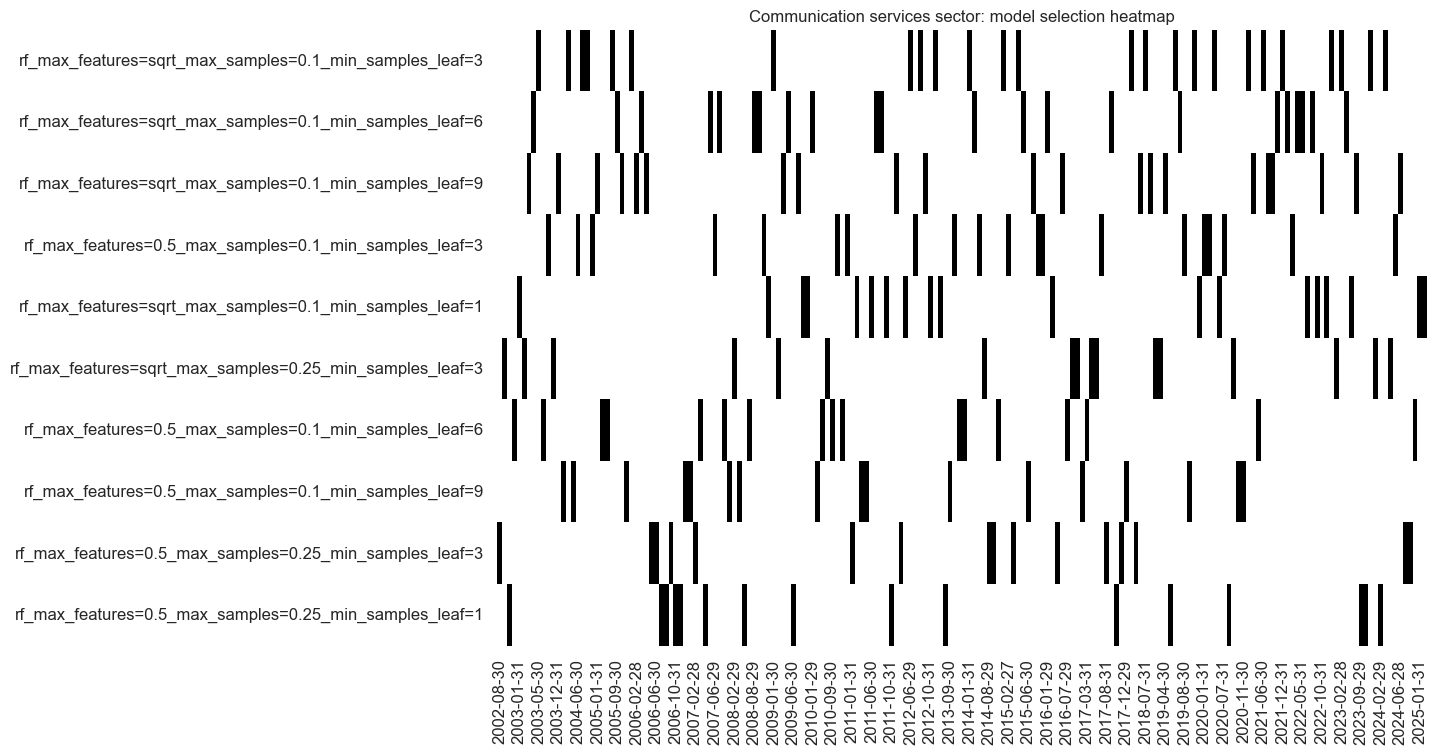

In [216]:
secname = csr_dict["sector_name"]
signal_name = csr_dict["signal_name"]

so_csr.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_csr.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_csr.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [217]:
csr_importances = (
    so_csr.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

csr_importances

BMLCOCRY_SAVT10_21DMA_ZN  BASEXINVCSCORE_SA_ZN  BMLXINVCSCORE_SA_ZN  \
count                271.000000            271.000000           271.000000   
mean                   0.036693              0.024477             0.021401   
min                    0.017953              0.007102             0.005521   
25%                    0.027478              0.020074             0.018817   
50%                    0.032192              0.024018             0.021243   
75%                    0.039888              0.029479             0.024336   
max                    0.106062              0.045552             0.032073   
std                    0.014006              0.007156             0.004529   

       REEROADJ_NSA_P1M12ML1_ZN  XCPIF_SA_P1M1ML12_WG_ZN  \
count                271.000000               271.000000   
mean                   0.021264                 0.021232   
min                    0.009010                 0.007010   
25%                    0.018998                 0.018816   
50%                    0.021064                 0.020305   
75%                    0.023413                 0.022853   
max                    0.035086                 0.052603   
std                    0.003621                 0.005087   

       XCPIC_SA_P1M1ML12_ZN  REFIXINVCSCORE_SA_ZN  SBCSCORE_SA_D3M3ML3_ZN  \
count            271.000000            271.000000              271.000000   
mean               0.019959              0.019796                0.019587   
min                0.008086              0.003762                0.005060   
25%                0.018079              0.017863                0.017368   
50%                0.019843              0.019769                0.019381   
75%                0.022015              0.021920                0.021557   
max                0.029376              0.037136                0.036590   
std                0.003306              0.004092                0.003989   

       CCSCORE_SA_WG_ZN  XGGDGDPRATIOX10_NSA_ZN  ...  RYLDIRS02Y_NSA_ZN  \
count        271.000000              271.000000  ...         271.000000   
mean           0.019304                0.018930  ...           0.016126   
min            0.006814                0.008000  ...           0.005501   
25%            0.017367                0.016708  ...           0.013961   
50%            0.019102                0.019062  ...           0.015962   
75%            0.021270                0.021513  ...           0.018421   
max            0.049853                0.031693  ...           0.040416   
std            0.003802                0.003992  ...           0.003831   

       XPCREDITBN_SJA_P1M1ML12_ZN  RIR_NSA_ZN  XRPCONS_SA_P1M1ML12_3MMA_ZN  \
count                  271.000000  271.000000                   271.000000   
mean                     0.016100    0.015976                     0.015905   
min                      0.004550    0.000000                     0.007630   
25%                      0.013990    0.013771                     0.014191   
50%                      0.015885    0.016558                     0.015977   
75%                      0.017812    0.018606                     0.017574   
max                      0.031015    0.023952                     0.025420   
std                      0.003526    0.003775                     0.002850   

       XRRSALES_SA_P1M1ML12_3MMA_WG_ZN  UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  \
count                       271.000000                          271.000000   
mean                          0.015837                            0.015744   
min                           0.005802                            0.004954   
25%                           0.013955                            0.013567   
50%                           0.015562                            0.015107   
75%                           0.017475                            0.017389   
max                           0.037431                            0.032887   
std                           0.003414                            

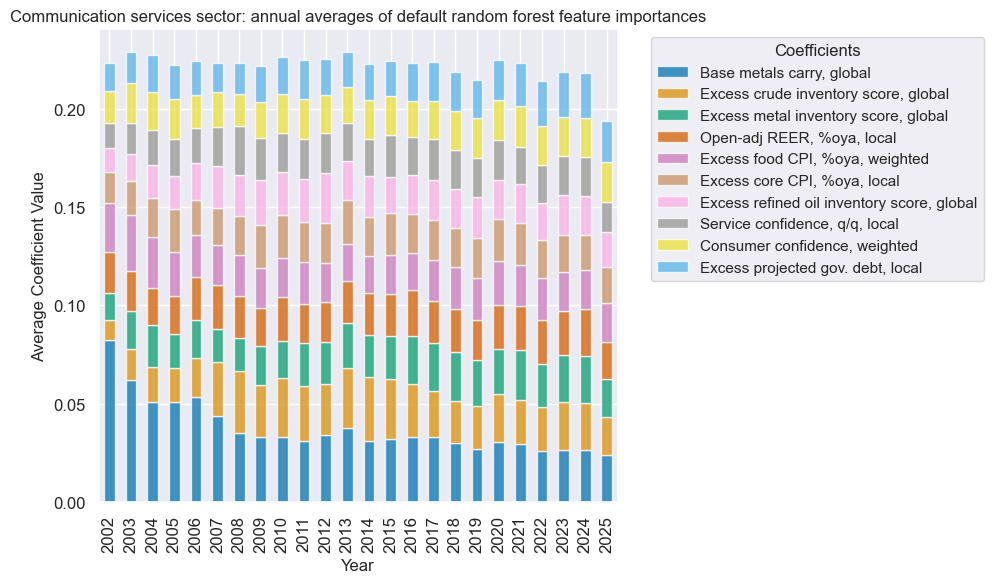

In [218]:
xcatx = csr_dict["signal_name"]
secname = csr_dict["sector_name"]

so_csr.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(csr_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

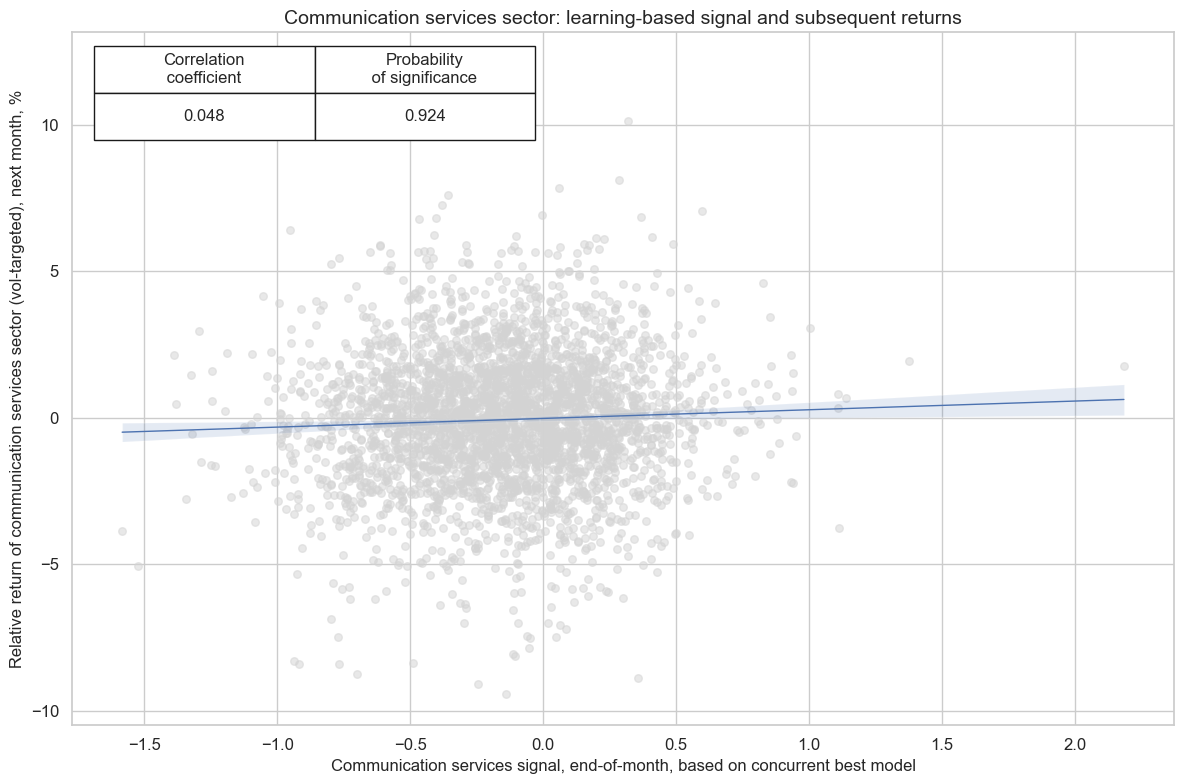

In [219]:
xcatx = [csr_dict["signal_name"], csr_dict["ret"]]
cidx = csr_dict["cidx"]
secname = csr_dict["sector_name"]

cr_csr = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=csr_dict["freq"],
    blacklist=csr_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_csr.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

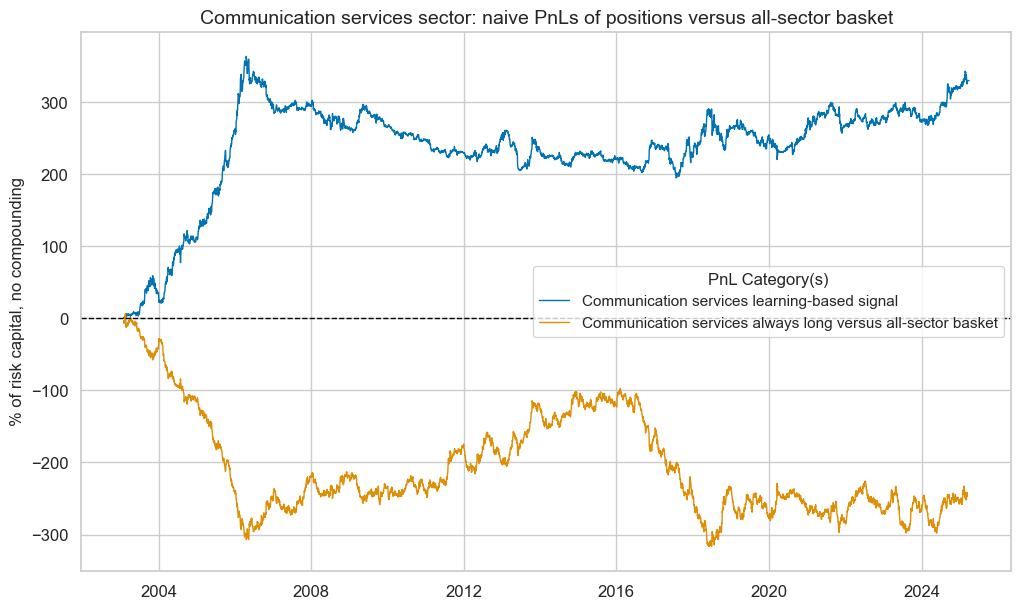

xcat                     Communication services learning-based signal  \
Return %                                                    14.888869   
St. Dev. %                                                  31.790794   
Sharpe Ratio                                                 0.468339   
Sortino Ratio                                                0.675637   
Max 21-Day Draw %                                          -35.326814   
Max 6-Month Draw %                                         -52.062922   
Peak to Trough Draw %                                      -168.65979   
Top 5% Monthly PnL Share                                     1.177937   
USD_EQXR_NSA correl                                         -0.002595   
Traded Months                                                     267   

xcat                     Communication services always long versus all-sector basket  
Return %                                                         -11.148616           
St. Dev. %                                                         35.84342           
Sharpe Ratio                                                      -0.311037           
Sortino Ratio                                                     -0.440682           
Max 21-Day Draw %                                                 -41.34344           
Max 6-Month Draw %                                              -110.518234           
Peak to Trough Draw %                                           -322.629621           
Top 5% Monthly PnL Share                                           -1.32878           
USD_EQXR_NSA correl                                               -0.043378           
Traded Months                                                           267

In [221]:
xcatx = [csr_dict["signal_name"]]
cidx = csr_dict["cidx"]
secname = csr_dict["sector_name"]
signal_name = csr_dict["signal_name"]
pnl_name = csr_dict["pnl_name"]

pnl_csr = msn.NaivePnL(
    df=dfx,
    ret=csr_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=csr_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_csr.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_csr.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_csr.plot_pnls(
    pnl_cats=pnl_csr.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

csr_dict["pnls"] = pnl_csr
pnl_csr.evaluate_pnls(pnl_cats=pnl_csr.pnl_names)

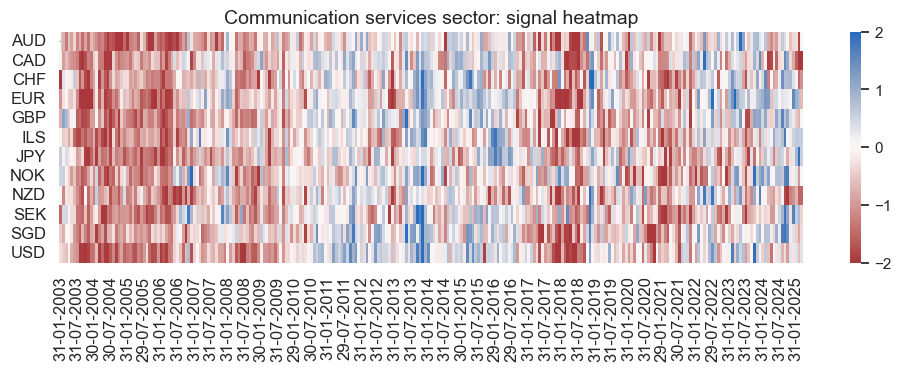

In [222]:
pnl_name = csr_dict["pnl_name"]
secname = csr_dict["sector_name"]

pnl_csr.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Utilities

#### Factor selection and signal generation

In [223]:
sector = "UTL"

utl_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [224]:
xcatx = utl_dict["xcatx"] + [utl_dict["ret"]]
cidx = utl_dict["cidx"]

so_utl = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=utl_dict["black"],
    freq=utl_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

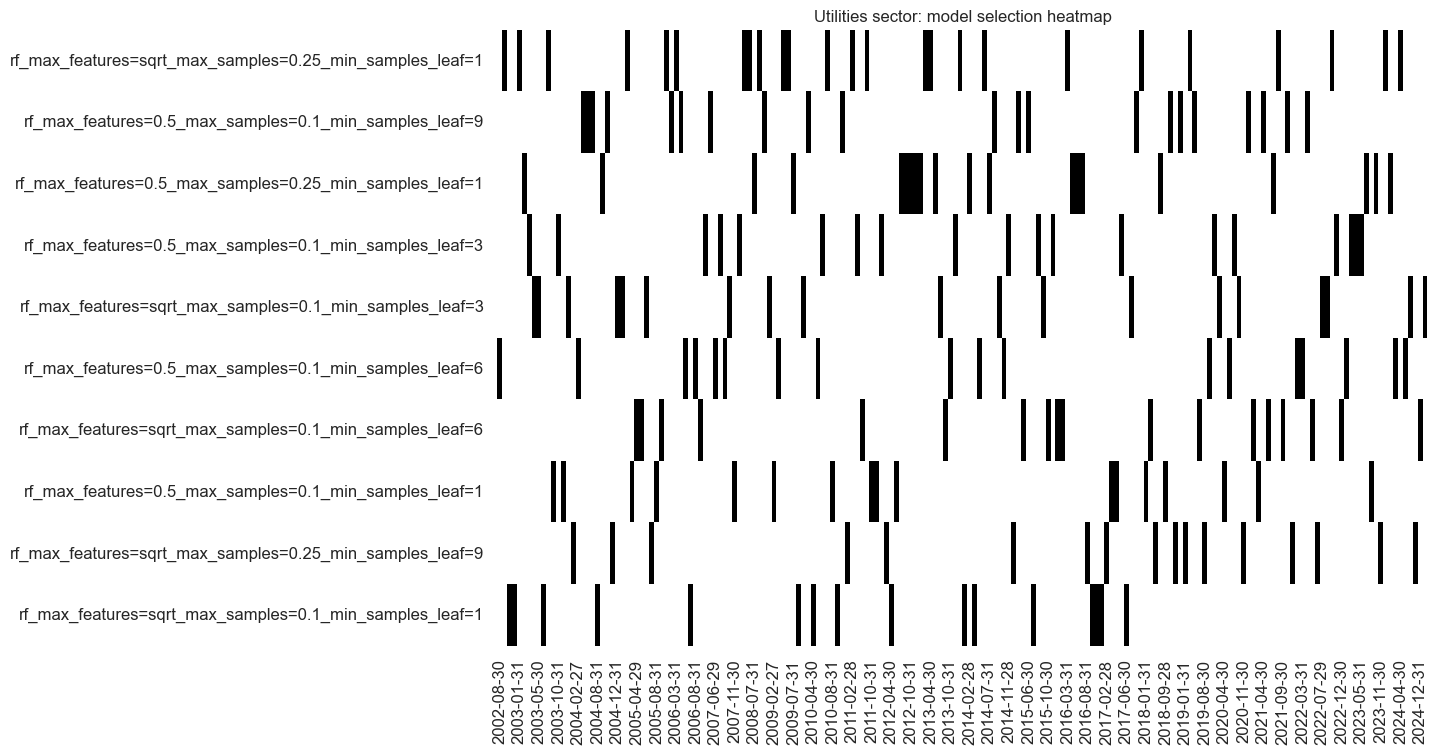

In [225]:
secname = utl_dict["sector_name"]
signal_name = utl_dict["signal_name"]

so_utl.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_utl.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_utl.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [226]:
utl_importances = (
    so_utl.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

utl_importances

XCPIC_SA_P1M1ML12_ZN  XGGDGDPRATIOX10_NSA_ZN  REEROADJ_NSA_P1M12ML1_ZN  \
count            271.000000              271.000000                271.000000   
mean               0.024699                0.022147                  0.021922   
min                0.000000                0.009021                  0.004621   
25%                0.021077                0.018753                  0.019286   
50%                0.024948                0.021813                  0.021636   
75%                0.028483                0.024660                  0.024206   
max                0.039321                0.045679                  0.045228   
std                0.006037                0.005227                  0.004880   

       BMLXINVCSCORE_SA_ZN  BASEXINVCSCORE_SA_ZN  CCSCORE_SA_WG_ZN  \
count           271.000000            271.000000        271.000000   
mean              0.021921              0.021238          0.021040   
min               0.000000              0.002127          0.010302   
25%               0.016556              0.018523          0.017831   
50%               0.022302              0.021292          0.020335   
75%               0.027384              0.024114          0.023360   
max               0.040423              0.034466          0.045139   
std               0.007543              0.005092          0.005045   

       CCSCORE_SA_D3M3ML3_ZN  BMLCOCRY_SAVT10_21DMA_ZN  SBCSCORE_SA_ZN  \
count             271.000000                271.000000      271.000000   
mean                0.020656                  0.020600        0.020064   
min                 0.007687                  0.008099        0.003351   
25%                 0.017319                  0.018326        0.017675   
50%                 0.019818                  0.020575        0.019748   
75%                 0.022784                  0.022789        0.022146   
max                 0.047516                  0.041862        0.051541   
std                 0.005222                  0.004027        0.004425   

       XCSTR_SA_P1M1ML12_3MMA_ZN  ...  XPPIH_NSA_P1M1ML12_ZN  \
count                 271.000000  ...             271.000000   
mean                    0.019866  ...               0.016128   
min                     0.000000  ...               0.005405   
25%                     0.017419  ...               0.013696   
50%                     0.019223  ...               0.015647   
75%                     0.022070  ...               0.017834   
max                     0.037113  ...               0.034939   
std                     0.004469  ...               0.003867   

       XNRSALES_SA_P1M1ML12_3MMA_WG_ZN  RIR_NSA_ZN  \
count                       271.000000  271.000000   
mean                          0.015954    0.015927   
min                           0.003963    0.000000   
25%                           0.013317    0.013528   
50%                           0.015594    0.016061   
75%                           0.017979    0.018652   
max                           0.035284    0.042584   
std                           0.004197    0.004503   

       UNEMPLRATE_NSA_3MMA_D1M1ML12_WG_ZN  XCPIE_SA_P1M1ML12_ZN  \
count                          271.000000            271.000000   
mean                             0.015291              0.015114   
min                              0.000000              0.003377   
25%                              0.012997              0.013192   
50%                              0.015143              0.015275   
75%                              0.017200              0.017344   
max                              0.033917              0.026552   
std                              0.003987              0.003473   

       XEMPL_NSA_P1M1ML12_3MMA_WG_ZN  XRGDPTECH_SA_P1M1ML12_3MMA_WG_ZN  \
count                     271.000000                        271.000000   
mean                        0.014828                          0.014549   
min                         0.005392                          0.002376   
25%            

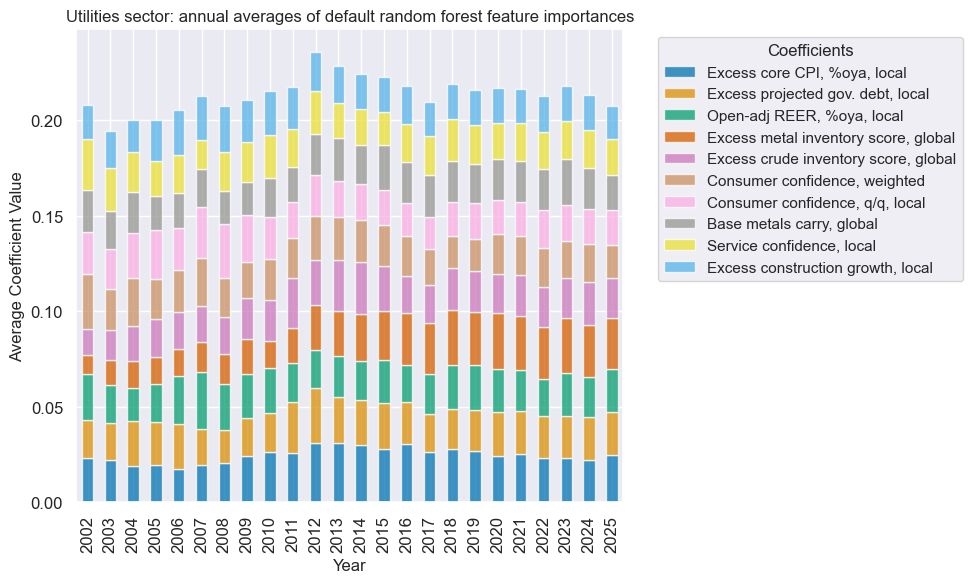

In [227]:
xcatx = utl_dict["signal_name"]
secname = utl_dict["sector_name"]

so_utl.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(utl_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

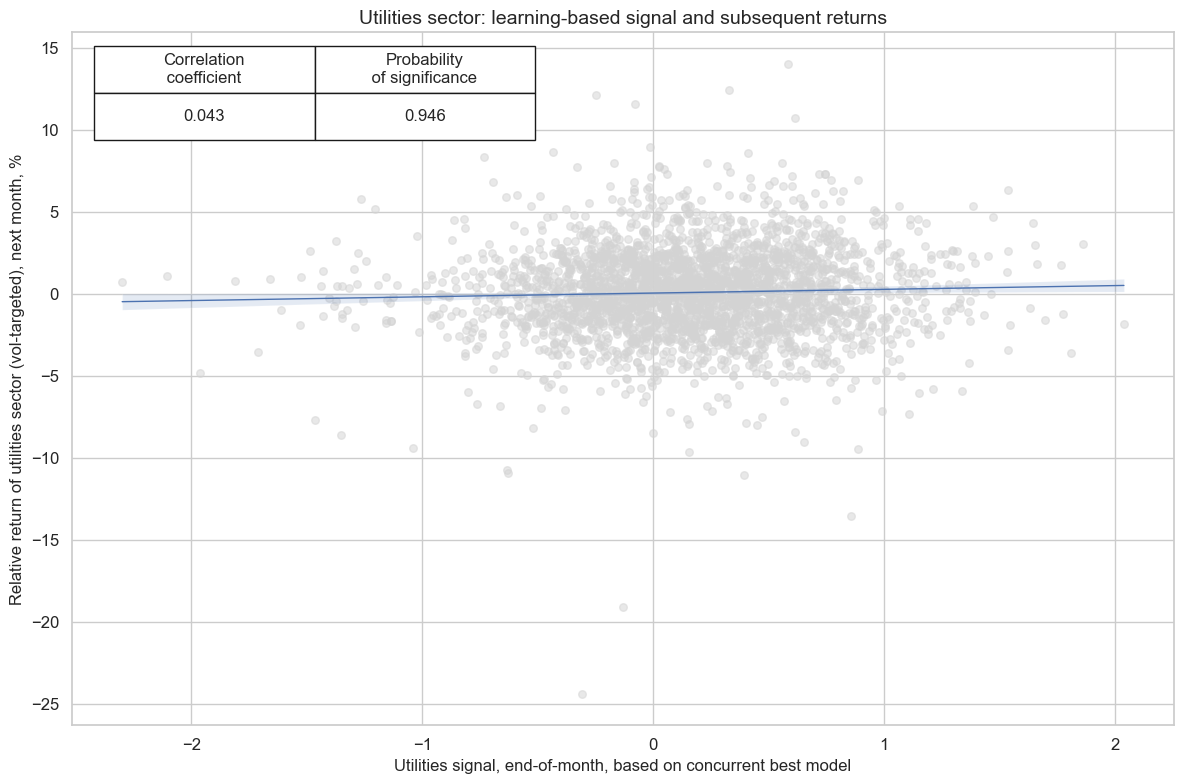

In [228]:
xcatx = [utl_dict["signal_name"], utl_dict["ret"]]
cidx = utl_dict["cidx"]
secname = utl_dict["sector_name"]

cr_utl = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=utl_dict["freq"],
    blacklist=utl_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_utl.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)

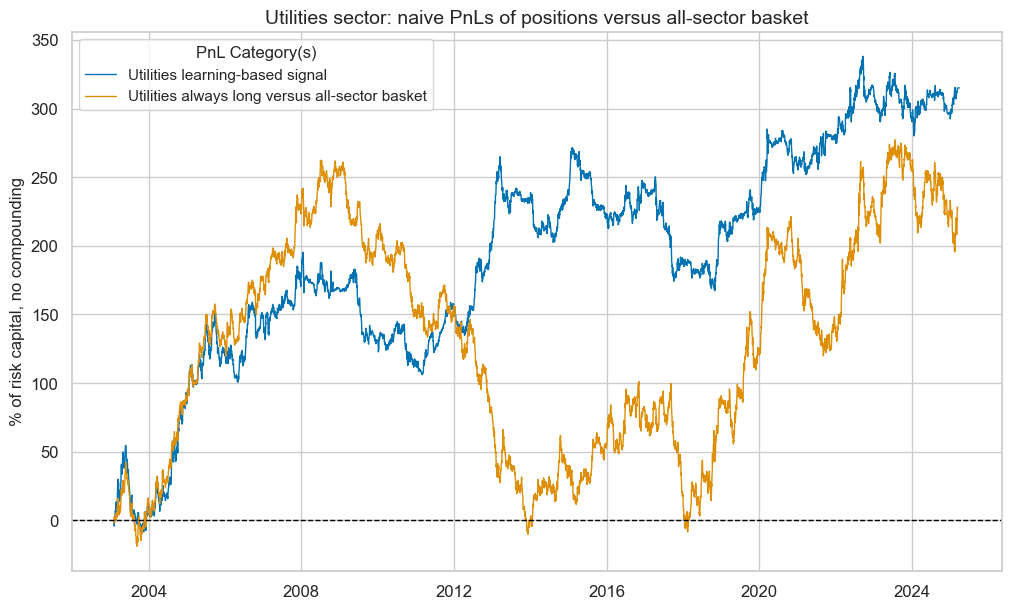

xcat                     Utilities learning-based signal  \
Return %                                       14.221555   
St. Dev. %                                     32.206642   
Sharpe Ratio                                    0.441572   
Sortino Ratio                                   0.634653   
Max 21-Day Draw %                             -34.741035   
Max 6-Month Draw %                            -76.122475   
Peak to Trough Draw %                        -104.192426   
Top 5% Monthly PnL Share                        1.124063   
USD_EQXR_NSA correl                            -0.094479   
Traded Months                                        267   

xcat                     Utilities always long versus all-sector basket  
Return %                                                      10.241575  
St. Dev. %                                                    39.653484  
Sharpe Ratio                                                   0.258277  
Sortino Ratio                                                  0.377312  
Max 21-Day Draw %                                            -45.235513  
Max 6-Month Draw %                                           -93.980448  
Peak to Trough Draw %                                       -272.563373  
Top 5% Monthly PnL Share                                       1.843926  
USD_EQXR_NSA correl                                           -0.196373  
Traded Months                                                       267

In [229]:
xcatx = [utl_dict["signal_name"]]
cidx = utl_dict["cidx"]
secname = utl_dict["sector_name"]
signal_name = utl_dict["signal_name"]
pnl_name = utl_dict["pnl_name"]

pnl_utl = msn.NaivePnL(
    df=dfx,
    ret=utl_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=utl_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_utl.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=2,
        pnl_name=pnl_name,
    )
pnl_utl.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_utl.plot_pnls(
    pnl_cats=pnl_utl.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

utl_dict["pnls"] = pnl_utl
pnl_utl.evaluate_pnls(pnl_cats=pnl_utl.pnl_names)

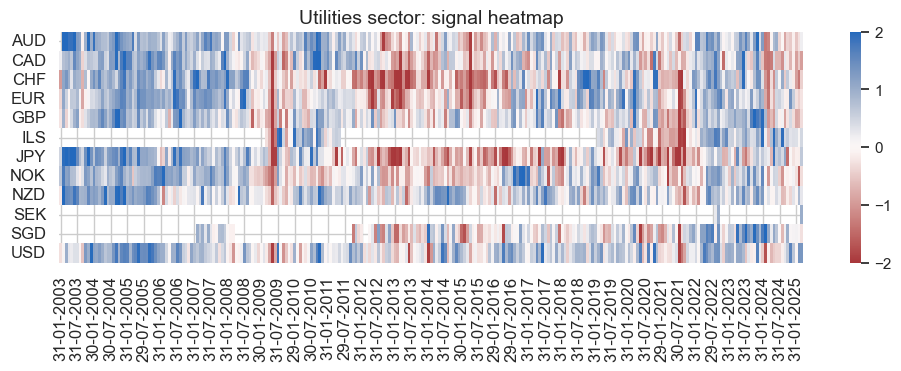

In [230]:
pnl_name = utl_dict["pnl_name"]
secname = utl_dict["sector_name"]

pnl_utl.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Real estate

#### Factor selection and signal generation

In [231]:
sector = "REL"

rel_dict = {
    "sector_name": sector_labels[sector],
    "signal_name": f"{sector}SOL",
    "pnl_name": f"{sector_labels[sector]} learning-based signal",
    "xcatx": macroz,
    "cidx": cids_eq,
    "ret": f"EQC{sector}{default_target_type}",
    "freq": "M",
    "black": sector_blacklist[sector],
    "srr": None,
    "pnls": None,
}

In [232]:
xcatx = rel_dict["xcatx"] + [rel_dict["ret"]]
cidx = rel_dict["cidx"]

so_rel = msl.SignalOptimizer(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    blacklist=rel_dict["black"],
    freq=rel_dict["freq"],
    lag=1,
    xcat_aggs=["last", "sum"],
)

  0%|          | 0/271 [00:00<?, ?it/s]

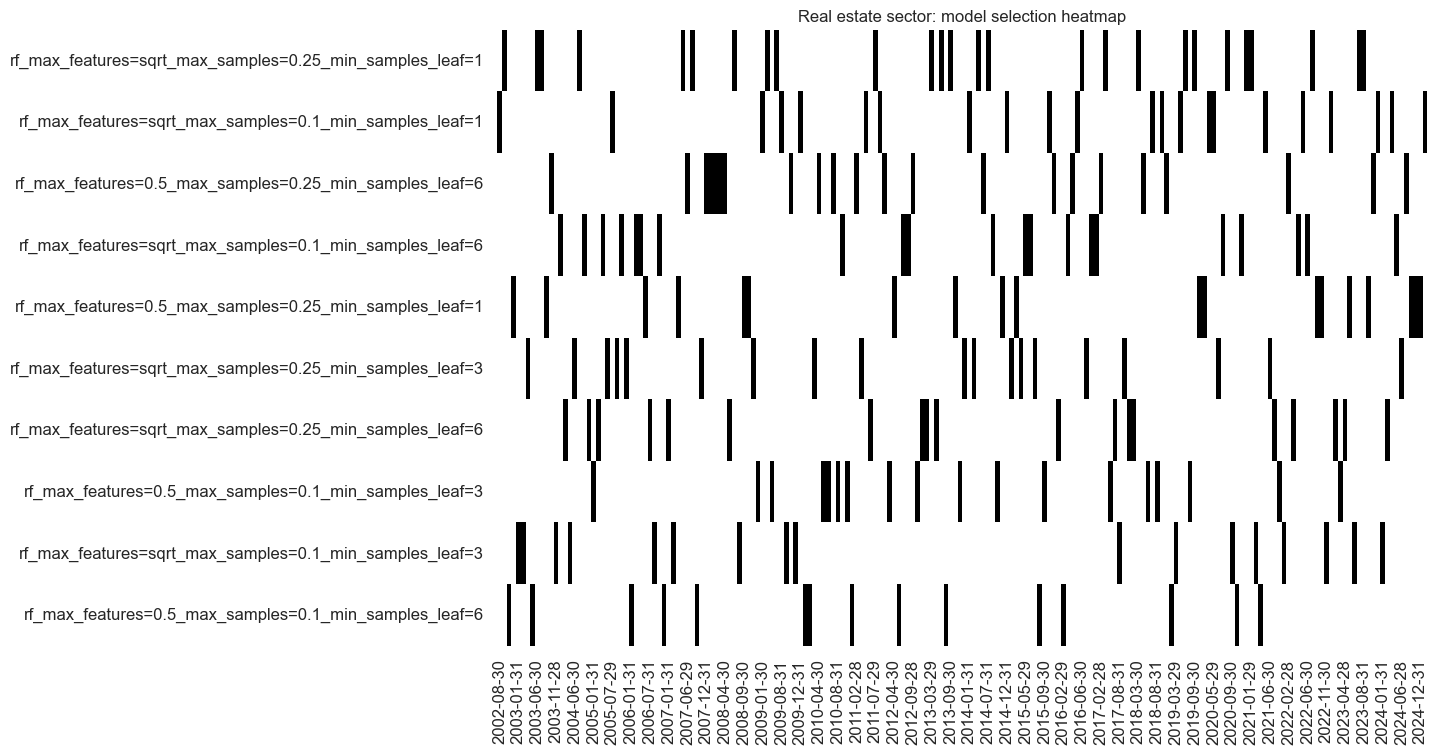

In [233]:
secname = rel_dict["sector_name"]
signal_name = rel_dict["signal_name"]

so_rel.calculate_predictions(
    name=signal_name,
    models=default_models,
    scorers=default_metric,
    hyperparameters=default_hparam_grid,
    inner_splitters=default_splitter,
    test_size=default_test_size,
    min_cids=default_min_cids,
    min_periods=default_min_periods,
    n_jobs_outer=-1,
    split_functions=default_split_functions,
)
so_rel.models_heatmap(
    signal_name,
    cap=10,
    title=f"{secname} sector: model selection heatmap",
)

# Store signals
dfa = so_rel.get_optimized_signals()
dfx = msm.update_df(dfx, dfa)

In [234]:
rel_importances = (
    so_rel.feature_importances.describe()
    .iloc[:, 1:]
    .sort_values(by="mean", axis=1, ascending=False)
)

rel_importances

BMLCOCRY_SAVT10_21DMA_ZN  RSLOPEMIDDLE_NSA_ZN  BASEXINVCSCORE_SA_ZN  \
count                271.000000           271.000000            271.000000   
mean                   0.031318             0.024617              0.021564   
min                    0.007034             0.012426              0.005993   
25%                    0.026673             0.019865              0.018143   
50%                    0.030136             0.022131              0.021660   
75%                    0.035547             0.026537              0.024795   
max                    0.056073             0.092364              0.040660   
std                    0.008259             0.008476              0.005603   

       SBCSCORE_SA_D3M3ML3_ZN  REEROADJ_NSA_P1M12ML1_ZN  \
count              271.000000                271.000000   
mean                 0.021460                  0.020621   
min                  0.007465                  0.007313   
25%                  0.018675                  0.018359   
50%                  0.020941                  0.020229   
75%                  0.023576                  0.022556   
max                  0.039646                  0.041894   
std                  0.004297                  0.004220   

       CCSCORE_SA_D3M3ML3_WG_ZN  CCSCORE_SA_D3M3ML3_ZN  \
count                271.000000             271.000000   
mean                   0.020412               0.020273   
min                    0.011612               0.009965   
25%                    0.017410               0.017667   
50%                    0.019427               0.019686   
75%                    0.022009               0.022120   
max                    0.048476               0.040364   
std                    0.005154               0.004282   

       XCPIE_SA_P1M1ML12_WG_ZN  BMLXINVCSCORE_SA_ZN  XGGDGDPRATIOX10_NSA_ZN  \
count               271.000000           271.000000              271.000000   
mean                  0.019713             0.019438                0.019259   
min                   0.008585             0.002531                0.002839   
25%                   0.017177             0.016867                0.016309   
50%                   0.019713             0.020495                0.018169   
75%                   0.022094             0.022770                0.020903   
max                   0.030912             0.031073                0.040282   
std                   0.003956             0.005136                0.004923   

       ...  MBCSCORE_SA_ZN  XNRSALES_SA_P1M1ML12_3MMA_WG_ZN  \
count  ...      271.000000                       271.000000   
mean   ...        0.015914                         0.015854   
min    ...        0.002635                         0.004350   
25%    ...        0.013856                         0.014016   
50%    ...        0.016362                         0.016012   
75%    ...        0.018224                         0.017562   
max    ...        0.024917                         0.026088   
std    ...        0.003455                         0.002902   

       CTOT_NSA_P1M12ML1_ZN  XNRSALES_SA_P1M1ML12_3MMA_ZN  \
count            271.000000                    271.000000   
mean               0.015844                      0.015843   
min                0.007116                      0.005200   
25%                0.014196                      0.014047   
50%                0.015593                      0.015797   
75%                0.017066                      0.017594   
max                0.035300                      0.025686   
std                0.003159                      0.002932   

       XPPIH_NSA_P1M1ML12_ZN  XRPCONS_SA_P1M1ML12_3MMA_ZN  \
count             271.000000                   271.000000   
mean                0.015795                     0.015708   
min                 0.002624                     0.008284   
25%                 0.014329                     0.013423   
50%                 0.015672                     0.015429   
75%                 0.017679                     0.01

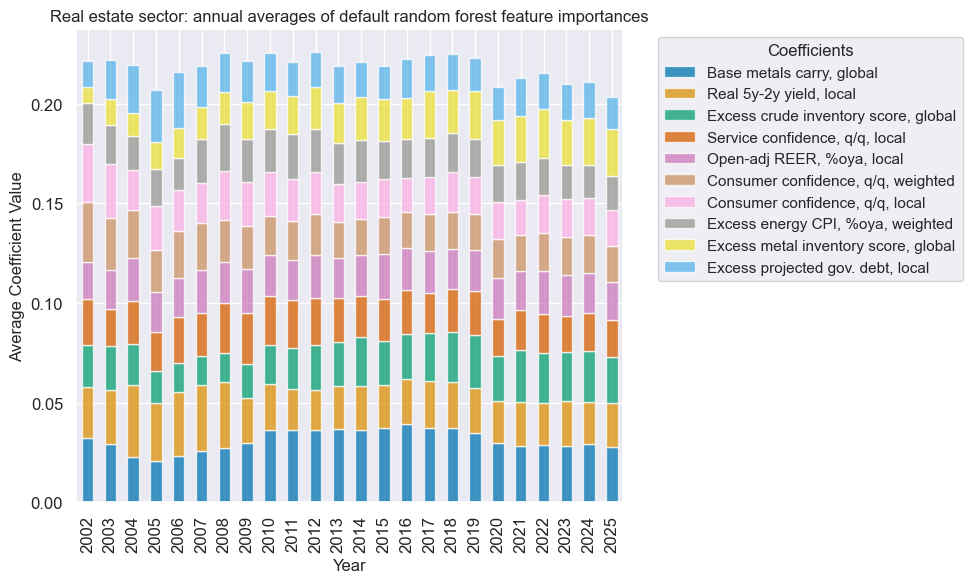

In [235]:
xcatx = rel_dict["signal_name"]
secname = rel_dict["sector_name"]

so_rel.coefs_stackedbarplot(
    name=xcatx,
    ftrs=list(rel_importances.columns[:10]),
    ftrs_renamed=cat_label_dict,
    title=f"{secname} sector: annual averages of default random forest feature importances",
)

#### Signal quality check

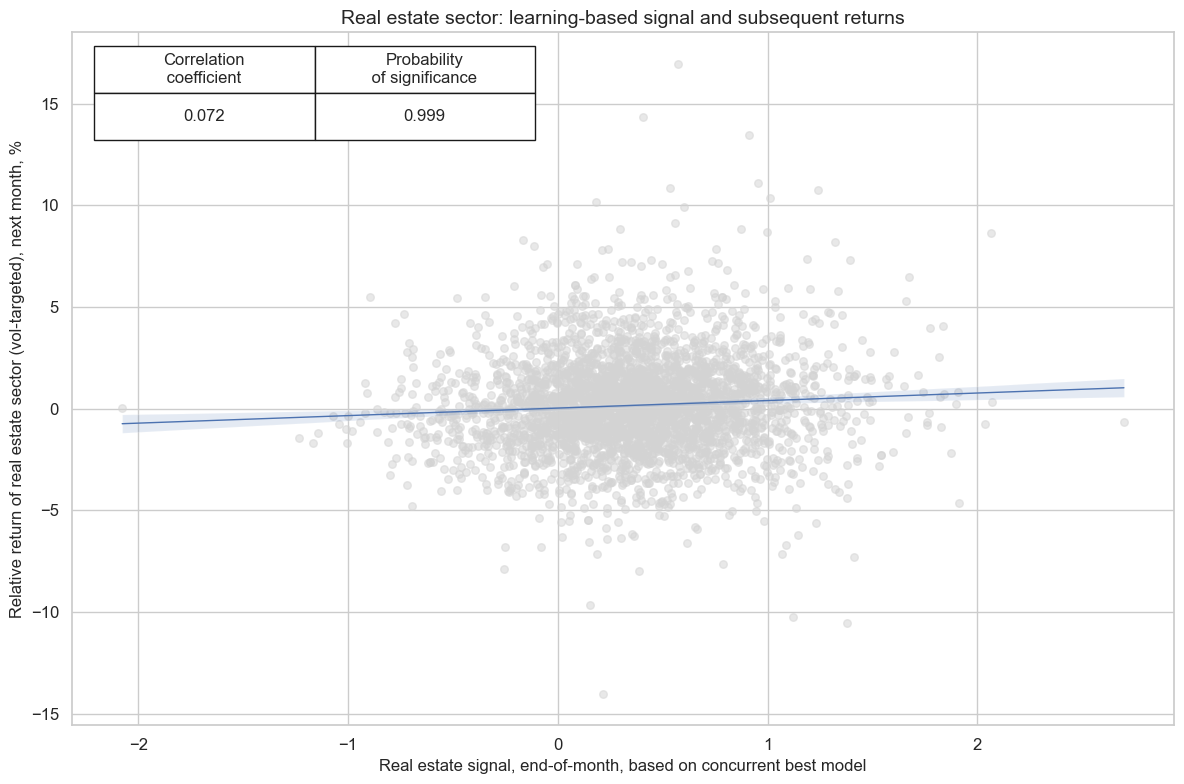

In [236]:
xcatx = [rel_dict["signal_name"], rel_dict["ret"]]
cidx = rel_dict["cidx"]
secname = rel_dict["sector_name"]

cr_rel = msp.CategoryRelations(
    df=dfx,
    xcats=xcatx,
    cids=cidx,
    freq=rel_dict["freq"],
    blacklist=rel_dict["black"],
    lag=1,
    xcat_aggs=["last", "sum"],
    slip=1,
)

cr_rel.reg_scatter(
    title=f"{secname} sector: learning-based signal and subsequent returns",
    labels=False,
    prob_est="map",
    xlab=f"{secname} signal, end-of-month, based on concurrent best model",
    ylab=f"Relative return of {secname.lower()} sector (vol-targeted), next month, %",
    coef_box="upper left",
    size=(12, 8),
)


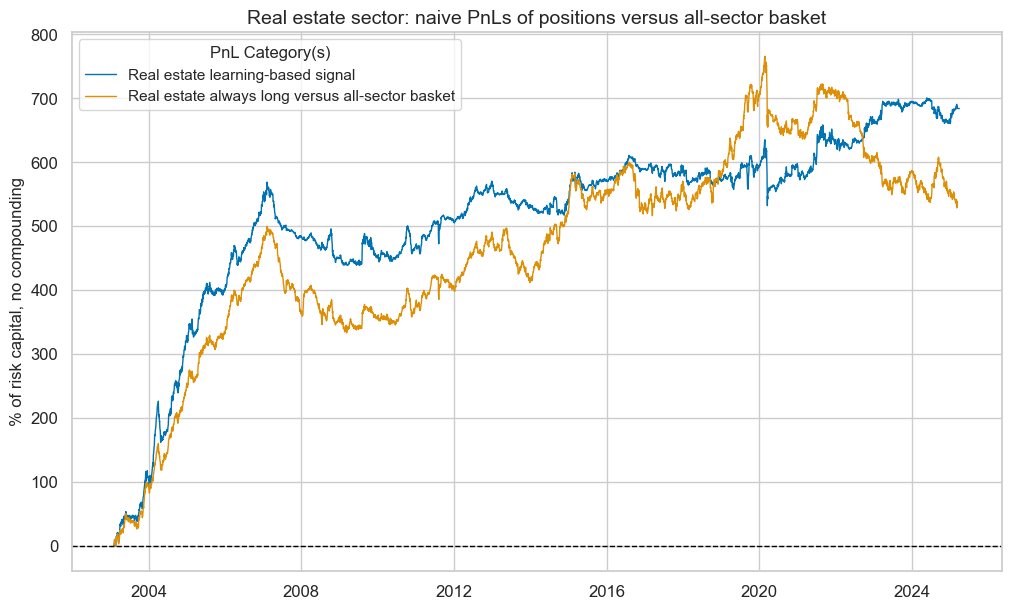

xcat                     Real estate learning-based signal  \
Return %                                         30.862946   
St. Dev. %                                       37.173338   
Sharpe Ratio                                      0.830244   
Sortino Ratio                                     1.212027   
Max 21-Day Draw %                               -93.712629   
Max 6-Month Draw %                              -67.848759   
Peak to Trough Draw %                          -130.190976   
Top 5% Monthly PnL Share                          0.739336   
USD_EQXR_NSA correl                              -0.045183   
Traded Months                                          267   

xcat                     Real estate always long versus all-sector basket  
Return %                                                         24.25139  
St. Dev. %                                                      42.658717  
Sharpe Ratio                                                     0.568498  
Sortino Ratio                                                    0.811584  
Max 21-Day Draw %                                             -107.121602  
Max 6-Month Draw %                                            -123.928869  
Peak to Trough Draw %                                         -237.128421  
Top 5% Monthly PnL Share                                         0.949022  
USD_EQXR_NSA correl                                             -0.054054  
Traded Months                                                         267

In [237]:
xcatx = [rel_dict["signal_name"]]
cidx = rel_dict["cidx"]
secname = rel_dict["sector_name"]
signal_name = rel_dict["signal_name"]
pnl_name = rel_dict["pnl_name"]

pnl_rel = msn.NaivePnL(
    df=dfx,
    ret=rel_dict["ret"],
    sigs=xcatx,
    cids=cidx,
    start=default_start_date,
    blacklist=rel_dict["black"],
    bms=["USD_EQXR_NSA"],
)

for xcat in xcatx:
    pnl_rel.make_pnl(
        sig=xcat,
        sig_op="zn_score_pan",
        rebal_freq="monthly",
        neutral="zero",
        rebal_slip=1,
        vol_scale=None,
        thresh=3,
        pnl_name=pnl_name,
    )
pnl_rel.make_long_pnl(
    vol_scale=None, label=f"{secname} always long versus all-sector basket"
)

pnl_rel.plot_pnls(
    pnl_cats=pnl_rel.pnl_names,
    title=f"{secname} sector: naive PnLs of positions versus all-sector basket",
    title_fontsize=14,
)

rel_dict["pnls"] = pnl_rel
pnl_rel.evaluate_pnls(pnl_cats=pnl_rel.pnl_names)

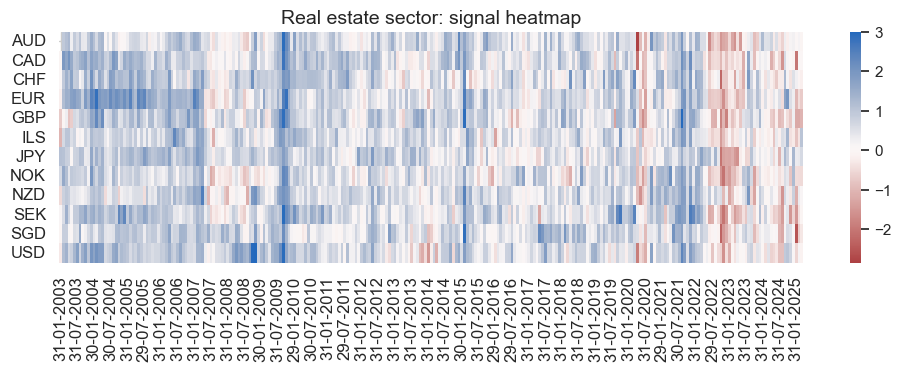

In [238]:
pnl_name = rel_dict["pnl_name"]
secname = rel_dict["sector_name"]

pnl_rel.signal_heatmap(
    pnl_name=pnl_name,
    figsize=(12, 3),
    title=f"{secname} sector: signal heatmap",
)

### Summary

### Sector-specific signals and returns

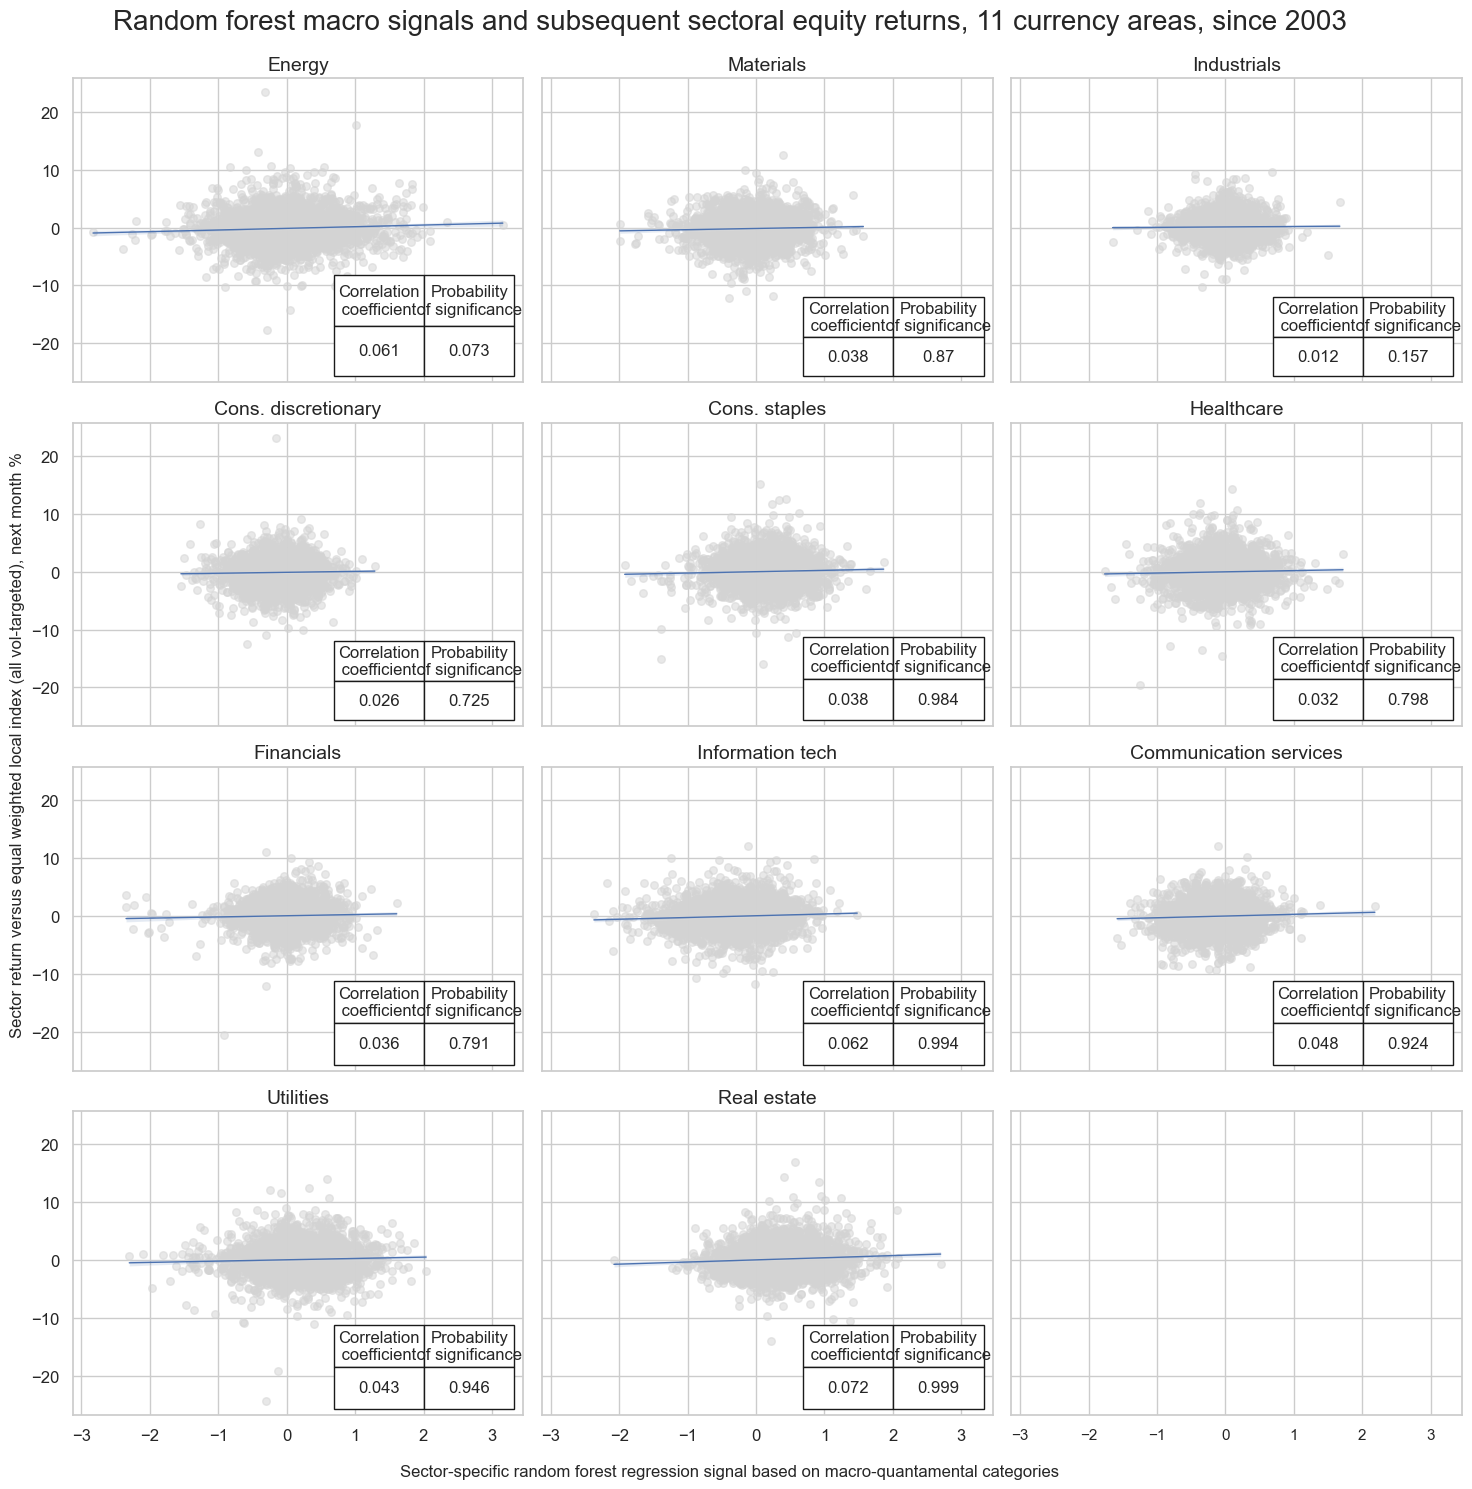

In [239]:
sec_catregs = {
    "enr": cr_enr,
    "mat": cr_mat,
    "ind": cr_ind,
    "cod": cr_cod, 
    "cos": cr_cos,
    "hlc": cr_hlc,
    "fin": cr_fin,
    "ite": cr_ite, 
    "csr": cr_csr,
    "utl": cr_utl, 
    "rel": cr_rel,
}


msv.multiple_reg_scatter(
    cat_rels=list(sec_catregs.values()),
    ncol=3,
    nrow=4,
    figsize=(15, 15),
    title="Random forest macro signals and subsequent sectoral equity returns, 11 currency areas, since 2003",
    title_xadj=0.5,
    title_yadj=0.99,
    title_fontsize=20,
    xlab="Sector-specific random forest regression signal based on macro-quantamental categories",
    ylab="Sector return versus equal weighted local index (all vol-targeted), next month %",
    coef_box="lower right",
    prob_est="map",
    single_chart=True,
    subplot_titles=[sector_labels[sector.upper()] for sector in sec_catregs.keys()],
)

### Combined cross-sector trading PnL

In [240]:
sec_pnls = {
    "enr": pnl_enr,
    "mat": pnl_mat,
    "ind": pnl_ind,
    "cod": pnl_cod,
    "cos": pnl_cos,
    "hlc": pnl_hlc,
    "fin": pnl_fin,
    "ite": pnl_ite,
    "csr": pnl_csr,
    "utl": pnl_utl,
    "rel": pnl_rel,
}

ma_pnl = msn.MultiPnL()
for sec, pnl in sec_pnls.items():
    ma_pnl.add_pnl(
        pnl, pnl_xcats=[f"{sector_labels[sec.upper()]} learning-based signal"]
    )

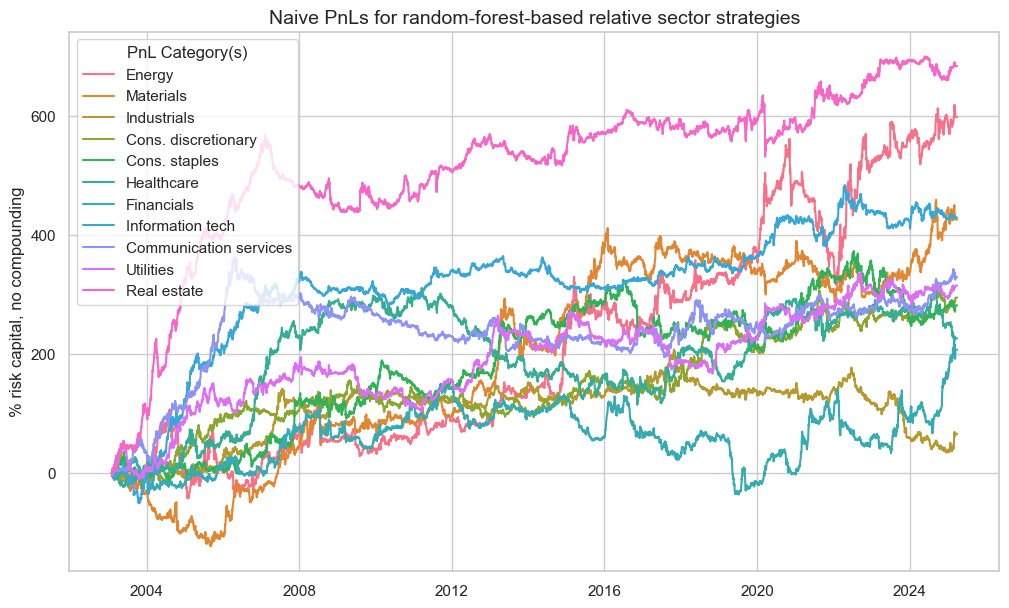

In [241]:
ma_pnl.plot_pnls(
    pnl_xcats=[
        f"{sector_labels[sec.upper()]} learning-based signal" for sec in sec_pnls.keys()
    ],
    title="Naive PnLs for random-forest-based relative sector strategies",
    xcat_labels=[sector_labels[sec.upper()] for sec in sec_pnls.keys()],
)

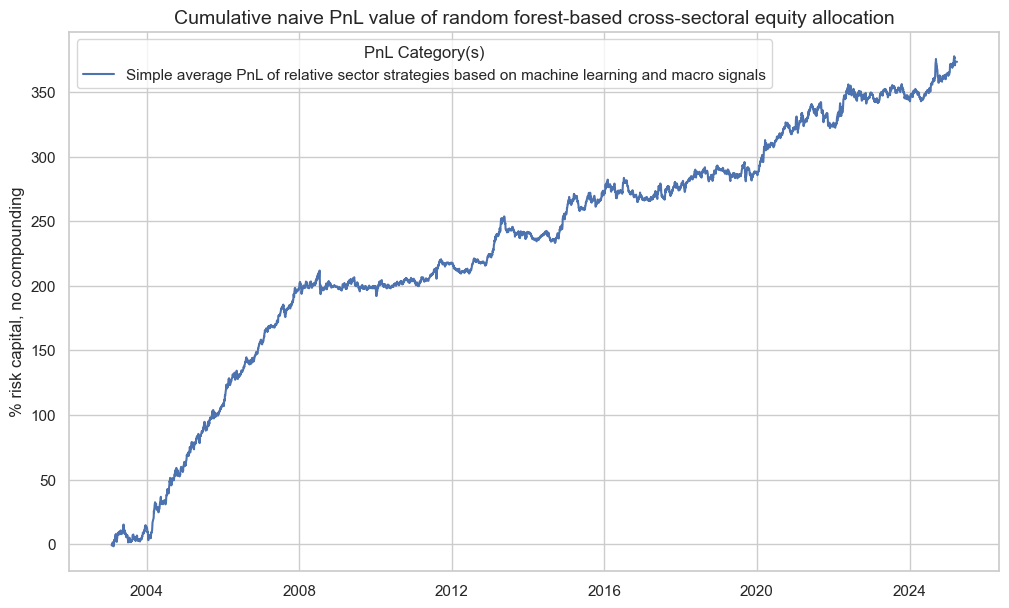

In [242]:
cpname = "Simple average PnL of relative sector strategies based on machine learning and macro signals"

macro_sector_pnl = ma_pnl.combine_pnls(
    pnl_xcats=[
        f"{sector_labels[sec.upper()]} learning-based signal" for sec in sec_pnls.keys()
    ],
    composite_pnl_xcat=cpname,
    weights=None,
)
ma_pnl.plot_pnls(
    [cpname],
    title="Cumulative naive PnL value of random forest-based cross-sectoral equity allocation",
)

In [243]:
tbr = ma_pnl.evaluate_pnls()
tbr = tbr.rename(
    columns={
        **{
            f"{sector_labels[sec.upper()]} learning-based signal/EQC{sec.upper()}R_VT10vALL": f"{sector_labels[sec.upper()]}"
            for sec in sec_pnls.keys()
        },
        **{
            "Simple average PnL of relative sector strategies based on machine learning and macro signals": "Simple average"
        },
    }
)

# selected_rows = ["Return %", "St. Dev. %", "Sharpe Ratio", "Sortino Ratio", "USD_EQXR_NSA correl"]
selected_columns = ["Simple average"] + [
    sector_labels[sec.upper()] for sec in sec_pnls.keys()
]
selected_pnl_stats = tbr.loc[:, selected_columns].T

In [244]:
selected_pnl_stats.columns

cols = [
    "Sharpe Ratio",
    "Sortino Ratio",
    "Top 5% Monthly PnL Share",
    "USD_EQXR_NSA correl",
]
display(selected_pnl_stats[cols].style.format("{:.2f}"))

## Appendix

### Appendix 1 - Macro quantamental indicators description

In [245]:
# Convert the dictionary to an HTML table with custom inline CSS
html_table = cat_labels.to_html(index=True, table_id="custom_table")

# Inject CSS to align text to the left and reduce font size
css = """
<style>
#custom_table th, #custom_table td {
    text-align: left;
    font-size: 12px; /* Adjust the font size as needed */
}
</style>
"""

In [246]:
# Display the styled HTML table
HTML(css + html_table)